In [1]:
import pandas as pd
from collections import defaultdict
from itertools import product
import matplotlib.pyplot as plt
from matplotlib import gridspec, cm
FONT_SIZE = 17

from random import shuffle, seed
SEED_NUMBER=42

from pathlib import Path

In [2]:
proj_path = Path().resolve().parent
print(proj_path)

/home/clem/Documents/Vectorpack/experiments_vector_paper/results_data


In [3]:
file_P = proj_path / "Panigrahy_multidim_OPT.csv"
file_I = proj_path / "Irregular_multidim_OPT.csv"
file_T = proj_path / "Triplet_multidim.csv"

In [4]:
family_list = ['FF',
               'FFD', 'FFD-Dyn',
               'BFD-T1', 'BFD-T1-Dyn',
               'BFD-T2', 'BFD-T2-Dyn',
               'BFD-T3', 'BFD-T3-Dyn',
               'BF', 'BF-Dyn',
               'WFD-T1', 'WFD-T1-Dyn',
               'WFD-T2', 'WFD-T2-Dyn',
               'WFD-T3', 'WFD-T3-Dyn',
               'WF', 'WF-Dyn',
               'BCS-DP1', 'BCS-DP1-Dyn', 'BCS-DP1-Bin', 
               'BCS-DP2', 'BCS-DP2-Dyn', 'BCS-DP2-Bin', 
               'BCS-DP3', 'BCS-DP3-Dyn', 'BCS-DP3-Bin', 
               'BCS-NormDP', 'BCS-NormDP-Dyn', 'BCS-NormDP-Bin',
               'BCS-L2Slacks', 'BCS-L2Slacks-Dyn', 'BCS-L2Slacks-Bin',
               'BCS-TFSum', 'BCS-TFSum-Dyn', 'BCS-TFSum-Bin',
               'BCS-TFMin', 'BCS-TFMin-Dyn', 'BCS-TFMin-Bin',
               
               'BC', 'BC-Dyn', 'BC-Bin',
               'MB-Pairing', 'MB-Pairing-Dyn', 'MB-Pairing-Bin',
               'MB-WFD', 'MB-WFD-Dyn',
               
               'meta'
              ]

def get_family(alg_name):
    ssplit = alg_name.split('-')
    s = ssplit[0]
    if s == 'MB':
        if (ssplit[1] == "BFD") or (ssplit[1] == "WFD"):
            s+= "-WFD"
        elif ssplit[1] == "Pairing":
            s+= "-" + ssplit[1]
        
        if ("Dyn" in alg_name) or ("Ratio" in alg_name):
            s+="-Dyn"
        elif ("Bin" in alg_name):
            s+="-Bin"
        
    elif s == 'BC':
        if ("Dyn" in alg_name) or ("Ratio" in alg_name):
            s+="-Dyn"
        elif ("Bin" in alg_name):
            s+="-Bin"

    else:
        if "T1" in alg_name:
            s+= "-T1"
        elif "T2" in alg_name:
            s+= "-T2"
        elif "T3" in alg_name:
            s+= "-T3"
            
        if "Rank" in alg_name:
            s = "Fit-Rank"
        
        if ("Dyn" in alg_name) or ("Ratio" in alg_name):
            s+="-Dyn"
    
    if s in family_list:
        return s
    else:
        print("Unknown algo name", alg_name, s)
        return -1
    
def is_family(alg_name, family_name):
    fam = get_family(alg_name)
    return fam == family_name

def create_family_dict(alg_list):
    d = defaultdict(list)
    
    for alg_name in alg_list:
        fam = get_family(alg_name)
        if fam != -1:
            d[fam].append(alg_name)
        
    return d

def get_simple_family(alg_name):
    ssplit = alg_name.split('-')
    s = ssplit[0]
    
    if s == 'MB':
        if ssplit[1] == "Pairing":
            return s+"-Pairing"
        else:
            return s+"-WFD"
    else:
        return s
    
def create_simple_family_dict(alg_list):
    d = defaultdict(list)
    
    for alg_name in alg_list:
        fam = get_simple_family(alg_name)
        if fam != -1:
            d[fam].append(alg_name)
    return d

In [5]:
def get_score(s):
    score = 0
    if "T1" in s:
        score+= 0.1
    elif "T2" in s:
        score+= 0.2
    elif "T3" in s:
        score+= 0.3

    if s == "FF":
        score = 0
    elif s.startswith('FF'):
        score+= 1
    elif s.startswith('BF'):
        score+= 2
    elif s.startswith('WF'):
        score+= 3
    elif s.startswith('BC'):
        score+= 4
    elif s.startswith('MB-WFD') or s.startswith('MB-BFD'):
        score+= 5
    elif s.startswith('MB-Pairing'):
        score+= 6
    elif s.startswith('meta-'):
        score+=99
    return score

In [6]:
def rename_T3_dyn(alg):
    if ('-T3' in alg) and ('-Dyn' in alg):
        tmp = alg.split('_') # To keep the '_timems' in alg
        l = tmp[0].split('-')
        l.remove('Dyn')
        l.insert(4, 'Dyn')
        tmp[0] = '-'.join(l)
        alg = '_'.join(tmp)
    return alg

In [7]:
def rename_algos(algo_list):
    new_list = [x.replace("WFDm-BS", "MB-WFD").replace("BFDm-BS", "MB-BFD").replace("Pairing-BS", "MB-Pairing") for x in algo_list]
    return [rename_T3_dyn(x).replace("ReciprocAvg", "RecipAvg").replace("BCS-", "BC-").replace("L2Norm", "L2Slacks") for x in new_list]

## Get results

In [8]:
def load_df(filename, with_classes=True, **kwargs):
    df = pd.read_csv(filename, sep='\t')
    #if with_OPT:
    if "OPT" in df.columns:
        # First 3 columns are ['instance_name', 'LB', 'OPT']
        start_cols = 3
    else:
        start_cols = 2
        # First 2 columns are ['instance_name', 'LB']
    
    # Rename some algorithms
    df.columns = rename_algos(df.columns)
      
    all_column_names = df.columns[start_cols:]
    
    if (len(all_column_names) % 2) != 0:
        print(f"ERROR: {len(all_column_names)} {len(df.columns)}")

    alg_names = [x for x in all_column_names if not "_time" in x]
    nb_algos = len(alg_names)
    
    alg_names_multi = [x for x in alg_names if x.startswith("MB-")]
    
    # Complement MB results with the solutions of FF
    for alg in alg_names_multi:
        df.loc[df[alg] == -1, alg] = df['FF']
    
    for x in alg_names:
        if '.' in x:
            print("Error ALGO NAME:", x)
    
    best_LB_OPT = df["LB"].copy()
    if "OPT" in df.columns:
        # complement with optimal values
        idx = df[df["OPT"] != -1].index
        best_LB_OPT.loc[idx] = df.loc[idx]["OPT"]
        df.drop(['OPT'], axis=1, inplace=True)
    df.insert(2, 'LB_or_OPT', best_LB_OPT)
    
    df.insert(1, 'n', df['instance_name'].apply(lambda x: int(x.split('_')[1])))
    df.insert(2, 'd', df['instance_name'].apply(lambda x: int(x.split('_')[2])))
    if with_classes:
        df.insert(1, 'class', df['instance_name'].apply(lambda x: x.split('_')[0][5:]))
        
    df.drop(['instance_name'], axis=1, inplace=True)
    
    return df, alg_names, alg_names_multi

In [9]:
def get_results(df, alg_names, by_list, group_as_index=False):
    sub_df = df[by_list].copy()
    
    df["best_sol"] = df[alg_names].min(axis=1)

    time_cols = [i+'_timems' for i in alg_names]
    
    eps = df[alg_names].apply(lambda x: (round(x / df["LB_or_OPT"] - 1, 3))*100) # *100 to get a percentage value
    time = df[time_cols].apply(lambda x: round(x, 4))
    time.columns = alg_names
    diff = df[alg_names].apply(lambda x: x - df["LB_or_OPT"])
    diff_best = df[alg_names].apply(lambda x: x - df["best_sol"])
    match_LB = df[alg_names].apply(lambda x: x == df["LB"])
    
    best = df[alg_names].apply(lambda x: x == df["best_sol"])
    
    eps = pd.concat([sub_df, eps], axis=1).groupby(by=by_list, as_index=group_as_index).mean()
    time = pd.concat([sub_df, time], axis=1).groupby(by=by_list, as_index=group_as_index).mean()
    diff = pd.concat([sub_df, diff], axis=1).groupby(by=by_list, as_index=group_as_index).mean()
    diff_best = pd.concat([sub_df, diff_best], axis=1).groupby(by=by_list, as_index=group_as_index).mean()
    
    best = pd.concat([sub_df, best], axis=1).groupby(by=by_list, as_index=group_as_index).sum()
    match_LB = pd.concat([sub_df, match_LB], axis=1).groupby(by=by_list, as_index=group_as_index).sum()
    
    return eps, time, diff, diff_best, best, match_LB

In [10]:
def filter_algo_list(algo_list, remove_prefix):
    def predicate(alg, remove_prefix):
        for s in remove_prefix:
            if alg.startswith(s):
                #print("removing", alg)
                return True
        return False
    
    l = [alg for alg in algo_list if not predicate(alg, remove_prefix)]
    return l

# Load dataframes

In [11]:
df_P, all_algos, multi_algos = load_df(file_P, with_classes=True)
df_I, _, _ = load_df(file_I, with_classes=True)
df_T, _, _ = load_df(file_T, with_classes=True)

print(f"Loaded {len(all_algos)} algos including {len(multi_algos)} MB algos!")

Loaded 351 algos including 76 MB algos!


# Compare algos with Unit weights only

In [12]:
alg_names_unit = [x for x in all_algos if "-Unit" in x and not "T3" in x]
alg_names_unit.insert(0, 'FF')
print(f"There are {len(alg_names_unit)} Unit algos")

There are 34 Unit algos


In [13]:
# Filter out BF and WF algos
alg_names_unit = [x for x in alg_names_unit if not "BF-" in x and not "WF-" in x]

In [14]:
# For all Centric + Multibin algos
unit_results_P = get_results(df_P, alg_names_unit, ['class', 'n', 'd'], group_as_index=True)
unit_results_I = get_results(df_I, alg_names_unit, ['class', 'n', 'd'], group_as_index=True)
unit_results_T = get_results(df_T, alg_names_unit, ['class', 'n', 'd'], group_as_index=True)

# results contains: eps, time, diff, diff_best, best, match_LB

## Find algos consistently outperformed by others
There are none for Centric. Even BF and WF are better than DotProduct1 for some instances.

In [ ]:
df = df_T
algs = alg_names_unit

nb_instances = df.shape[0]
for algo_test in algs:
    counts = df[algs].apply(lambda x: x <= df[algo_test]).sum()
    l = list(counts[counts == nb_instances].index)
    l.remove(algo_test)
    if (len(l) > 0):
        #to_remove = to_remove.union(l)
        print(f"{algo_test}: {len(l)} are better than me")
        if (len(l) < 10):
            print('\t', l)

## Find algorithms performing equally

In [ ]:
df = df_P
algs = alg_names_unit

nb_instances = df.shape[0]
sub_list = algs.copy()
new_list = []
for i in range(len(algs)):
    algo_test = sub_list.pop(0)
    new_list.append(algo_test)
    # Find algos performing equally to algo_test
    counts = df[sub_list].apply(lambda x: x == df[algo_test]).sum()
    l = list(counts[counts == nb_instances].index)
    if (len(l) != 0):
        # If some are found, remove them from the sub_list
        print(f"{algo_test} identical to: {l}")
        sub_list = [x for x in sub_list if not x in l]
    if (len(sub_list) == 0):
        break
# Sub_list contains 'unique' algos
print(f"There are {len(new_list)} 'unique' algos")

## Find best algos for each class and parameters

In [ ]:
algs = alg_names_unit

eps = unit_results_P[0]
for c in range(1,10): # For Panigrahy dataframe
    print("\tClass", c)
    
    print("\t\tPercentage err to LB")
    eps_avg = eps.loc[str(c)][algs].mean()
    eps_avg.sort_values(ascending=True, inplace=True)
    print(eps_avg.head(10))

In [ ]:
algs = alg_names_unit

eps = unit_results_I[0]
for c in range(1,7): # For New dataframe
    print("\tClass", c)
    
    print("\t\tPercentage err to LB")
    eps_avg = eps.loc[str(c)][algs].mean()
    eps_avg.sort_values(ascending=True, inplace=True)
    print(eps_avg.head(10))

In [ ]:
algs = alg_names_unit

eps = unit_results_T[0]
for c in ['C', 'F']: # For Triplet dataframe
    print("\tClass", c)
    
    print("\t\tPercentage err to LB")
    eps_avg = eps.loc[str(c)][algs].mean()
    eps_avg.sort_values(ascending=True, inplace=True)
    print(eps_avg.head(10))

## Plots

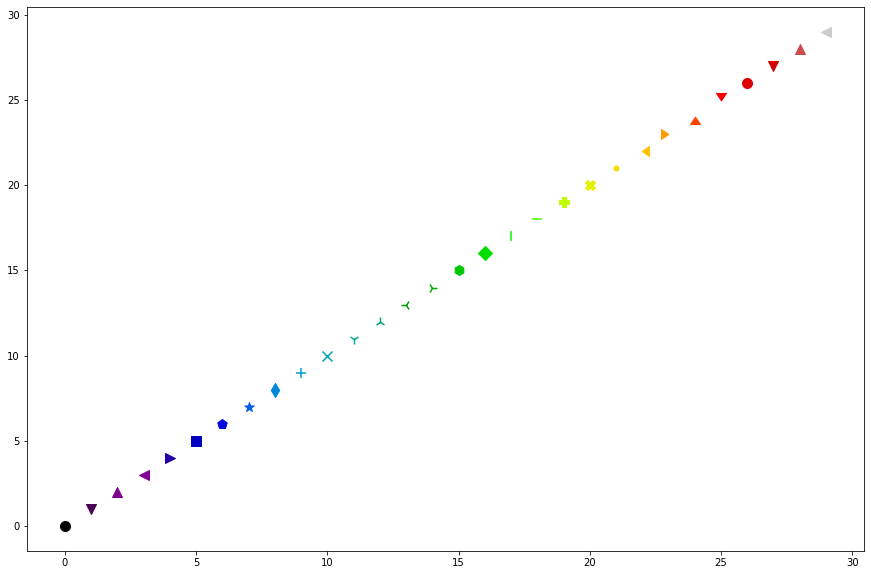

In [65]:
n = 30
l = list(range(n))

fig = plt.figure(figsize=(15,10))

marker_list = create_big_markers(n)
color_list = create_small_colors(n)

for i in range(n):
    plt.scatter(i, i, color=color_list[i], marker=marker_list[i], s=100)

plt.show()


In [15]:
def create_small_colors(n):
    cmap = cm.get_cmap('nipy_spectral')
    #cmap = cm.get_cmap('turbo')
    if n > 1:
        c = []
        for i in range(n):
            c.append(cmap(float(i/(n-1))))
        #shuffle(c)
    else:
        c = [cmap(0)]
    return c

In [16]:
MARKS = ['o', 'v', 'd', '*', '^', 'X']
MARKS2 = ['o', 'v', 'd']

def create_markers(n, short=False):
    if short:
        m = len(MARKS2)
        return [MARKS2[i%m] for i in range(n)]
    else:
        m = len(MARKS)
        return [MARKS[i%m] for i in range(n)]

In [63]:
list_all_markers = {'o': 'circle',
                    'v': 'triangle_down', '^': 'triangle_up',
                    '<': 'triangle_left', '>': 'triangle_right',
                    's': 'square', 'p': 'pentagon',
                    '*': 'star', 'd': 'thin_diamond',
                    '+': 'plus', 'x': 'x',
                    '1': 'tri_down', '2': 'tri_up',
                    '3': 'tri_left', '4': 'tri_right',
                    #'8': 'octagon',
                    
                    'h': 'hexagon1',# 'H': 'hexagon2',
                    
                    'D': 'diamond',
                    '|': 'vline', '_': 'hline',
                    'P': 'plus_filled', 'X': 'x_filled',
                    #0: 'tickleft', 1: 'tickright',
                    #2: 'tickup', 3: 'tickdown',
                    '.': 'point', 
                    4: 'caretleft', 5: 'caretright',
                    6: 'caretup', 7: 'caretdown',
                    #8: 'caretleftbase', 9: 'caretrightbase',
                    #10: 'caretupbase', 11: 'caretdownbase'
}
BIG_MARKS = [k for k in list_all_markers.keys()]
print(len(BIG_MARKS))

26


In [80]:
bo = 10
marker_size_offset = [0, 0, 0, 0, 0, # Circle + 4 triangles
                      0, 0, 0, 0, 0, 0,  # square pentagon, star, thin_diamond , plus, x
                      bo, bo, bo, bo, # 4 tri
                      0, #hexagon
                      0, bo, bo, 0, 0,
                      0, 0, 0, 0, 0
                     ]
print(len(marker_size_offset))

26


In [38]:
def create_markers_and_size(n, marker_size):
    m = len(BIG_MARKS)
    
    return [ (BIG_MARKS[i%m], marker_size+marker_size_offset[i%m]) for i in range(n) ]

In [18]:
def create_big_markers(n, short=False):
    m = len(BIG_MARKS)
    return [BIG_MARKS[i%m] for i in range(n)]
    # TODO if short=True

In [19]:
def simplify_family_dict(fam_dict):
    new_dict = defaultdict(list)
    
    for fam, fam_list in fam_dict.items():
        sp = fam.split("-")
        s = sp[0]
        if len(sp) > 1 and sp[1].startswith('T'):
            s+= "-" + sp[1]
        
        if len(sp) > 1 and sp[0] == "MB":
            s+= "-" + sp[1]
        
        new_dict[s].extend(fam_list)
        
    return new_dict

In [83]:
def plot_summary_family(x_data, y_data, alg_list,
                 stitle, xlabel, ylabel,
                 **kwargs):
    
    # kwargs parameters
    if "bbox_anchor" in kwargs:
        bbox_anchor = kwargs["bbox_anchor"]
    else:
        bbox_anchor = (kwargs.get("bbox_anchor_x", 0.5), kwargs.get("bbox_anchor_y", -0.1))
    
    ncols = kwargs.get("ncols", 5)

    if kwargs.get("do_mean", True):
        x = x_data[alg_list].mean()
        y = y_data[alg_list].mean()
    else:
        x = x_data[alg_list]
        y = y_data[alg_list]
    
    fig = plt.figure(figsize=(15,10))
    
    # To sort the algos by FFD, BFD, WFD, BCS, MB order
    alg_list.sort(key=lambda x: get_score(x))
    
    fam_dict = create_family_dict(alg_list)
    if kwargs.get("simplify_dict", True):
        fam_dict = simplify_family_dict(fam_dict)
    
    #marker_list = create_markers(len(alg_list), kwargs.get("short_markers", False))
    #marker_list = create_big_markers(len(alg_list), kwargs.get("short_markers", False))
    markers_size_list = create_markers_and_size(len(alg_list), 10)
    color_list = create_small_colors(len(fam_dict))
    seed(SEED_NUMBER)
    shuffle(color_list)
    
    i = 0
    j = 0
    legend_markers = []
    legend_names = []
    for fam, fam_list in fam_dict.items():
        n_algos = len(fam_list)
        
        for alg in fam_list:
            plt.scatter(x[alg], y[alg], color=color_list[i], marker=markers_size_list[j][0], s=10*markers_size_list[j][1])
            legend_markers.append(plt.Line2D([0,0],[0,0],color=color_list[i], marker=markers_size_list[j][0], markersize=markers_size_list[j][1], linestyle=''))
            legend_names.append(alg)
            j+=1
        i+=1
    
    plt.title(stitle, fontsize=FONT_SIZE+4)
    plt.xlabel(xlabel, fontsize=FONT_SIZE+4)
    plt.ylabel(ylabel, fontsize=FONT_SIZE+4)
    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)
    
    if kwargs.get("show_legend", True):
        legend_size = kwargs.get("legend_size", FONT_SIZE-5)
        fig.legend(legend_markers, legend_names, numpoints=1, loc='lower center',
                   fontsize=legend_size, ncol=ncols, bbox_to_anchor=bbox_anchor)
    
    if kwargs.get("log_scale", False):
        plt.xscale('log')
    plt.show()
    
    filename = kwargs.get("filename", None)
    if filename:
        fig.savefig(filename, bbox_inches='tight')

In [53]:
def plot_n_eps(x_data, y_data, c, alg_list,
               stitle, xlabel, ylabel,
               **kwargs):
    
    # kwargs parameters
    if "bbox_anchor" in kwargs:
        bbox_anchor = kwargs["bbox_anchor"]
    else:
        bbox_anchor = (kwargs.get("bbox_anchor_x", 0.5), kwargs.get("bbox_anchor_y", -0.12))
    
    ncols = kwargs.get("ncols", 5)
    
    fig = plt.figure(figsize=(15,8))
    gs = fig.add_gridspec(3, 1)
    (ax1, ax2, ax3) = gs.subplots(sharex=True, sharey=True)
    
    # To sort the algos by FFD, BFD, WFD, BCS, MB order
    alg_list.sort(key=lambda x: get_score(x))
    
    color_list = create_small_colors(len(alg_list))
    #markers = create_big_markers(len(alg_list))
    markers_size_list = create_markers_and_size(len(alg_list), 10)
    seed(SEED_NUMBER+1)
    shuffle(color_list)
    
    y1 = y_data.loc[c, :, 3]
    y2 = y_data.loc[c, :, 5]
    y3 = y_data.loc[c, :, 10]

    for i in range(len(alg_list)):
        alg = alg_list[i]
        ax1.plot(x_data, y1[alg], c=color_list[i], marker=markers_size_list[i][0], label=alg, linewidth=2, markersize=markers_size_list[i][1])
        ax2.plot(x_data, y2[alg], c=color_list[i], marker=markers_size_list[i][0], label=alg, linewidth=2, markersize=markers_size_list[i][1])
        ax3.plot(x_data, y3[alg], c=color_list[i], marker=markers_size_list[i][0], label=alg, linewidth=2, markersize=markers_size_list[i][1])
    
    #simple_names = [dict_simple_names.get(x,x) for x in alg_list]
    #markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_list]
    markers = [plt.Line2D([0,0],[0,0],color=color_list[i], marker=markers_size_list[i][0], markersize=markers_size_list[i][1], linestyle='') for i in range(len(alg_list))]
    fig.legend(markers, alg_list, numpoints=1, loc='lower center', fontsize=FONT_SIZE-4,
               ncol=ncols, bbox_to_anchor=bbox_anchor)

    plt.xticks(x_data)
    #fig.subtitle(stitle, fontsize=FONT_SIZE)
    plt.xlabel(xlabel, fontsize=FONT_SIZE)
    ax2.set_ylabel(ylabel, fontsize=FONT_SIZE+3)
    
    ax1.set_title(stitle + ", d=3", fontsize=FONT_SIZE)
    ax2.set_title("d=5", fontsize=FONT_SIZE-2)
    ax3.set_title("d=10", fontsize=FONT_SIZE-2)
    
    ax1.tick_params(axis="y", labelsize=FONT_SIZE-3)
    ax2.tick_params(axis="y", labelsize=FONT_SIZE-3)
    ax3.tick_params(axis="both", labelsize=FONT_SIZE-3)
    
    if kwargs.get("log_scale_x", False):
        plt.xscale('log')
    if kwargs.get("log_scale_y", False):
        plt.yscale('log')
    
    plt.show()
    
    filename = kwargs.get("filename", None)
    if filename:
        fig.savefig(filename, bbox_inches='tight')

In [43]:
def create_selected_list(eps, fam_dict, with_meta=False):
    l = []
    for fam, fam_list in fam_dict.items():
        if fam == "FF":
            l.append("FF")
        else:
            eps_avg = eps[fam_list].mean()
            eps_avg.sort_values(ascending=True, inplace=True)
            l.extend(eps_avg.index[:1])
    
    if with_meta:
        l = l + ["meta-centric", "meta-all"]
    return l

## Plot lines %error as a function of n

For each class a selection of algorithms is made using 'create_selected_list'

In [44]:
unit_fam_dict = create_simple_family_dict(alg_names_unit)
#del unit_fam_dict["FF"]

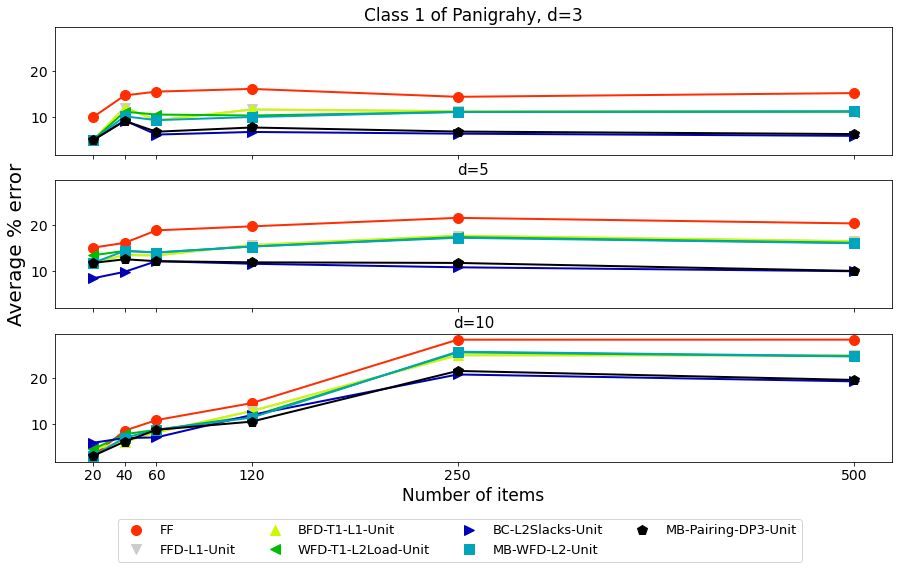

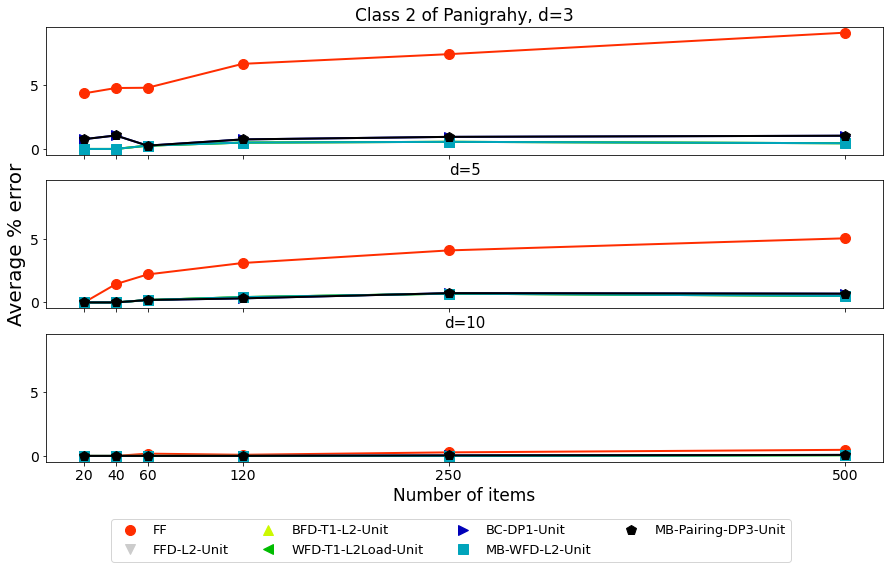

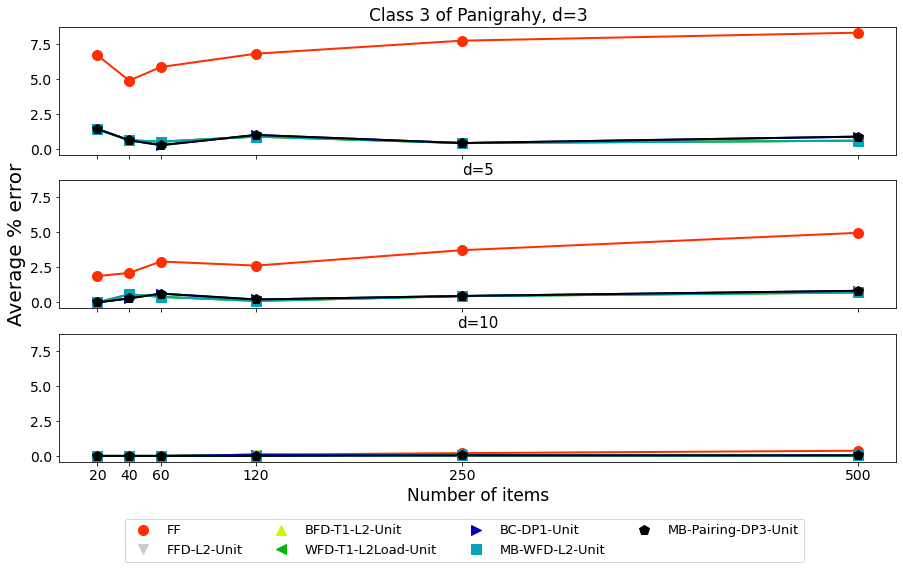

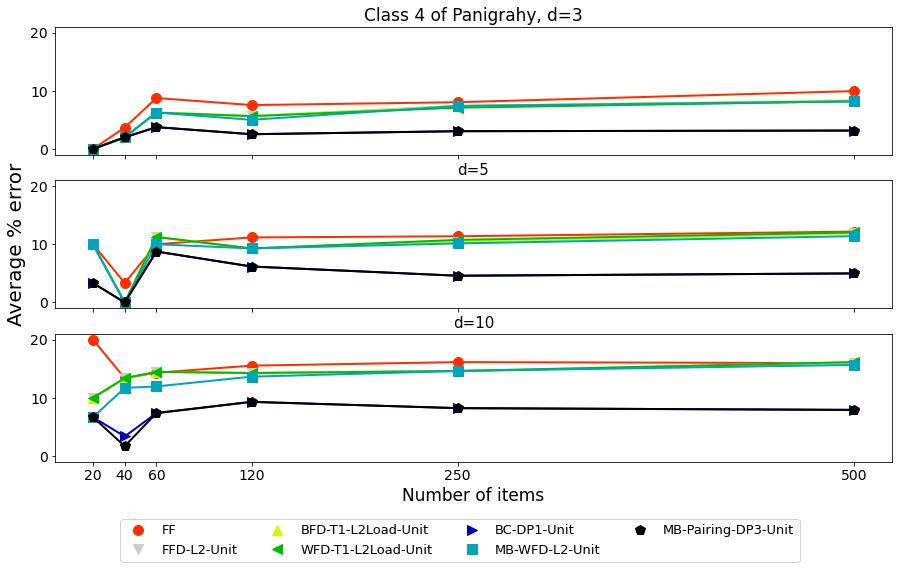

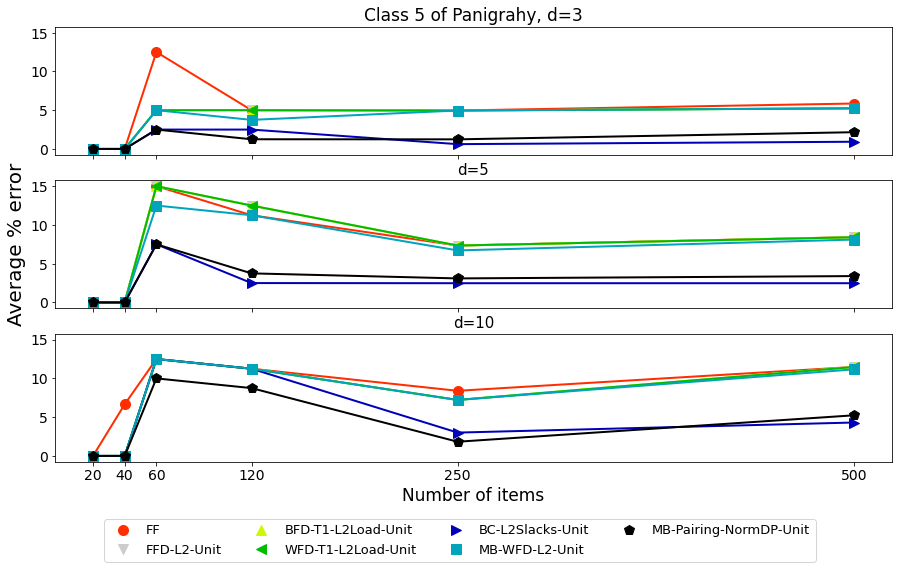

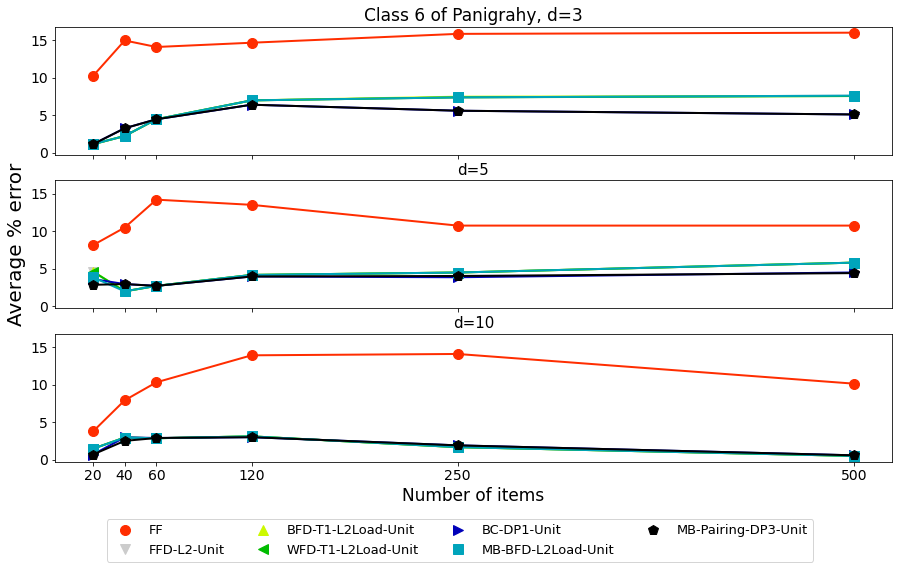

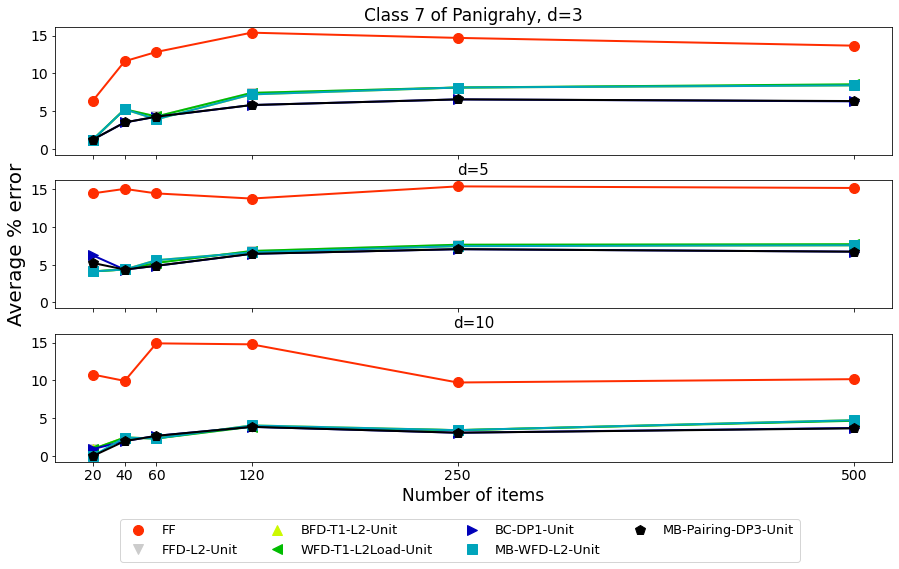

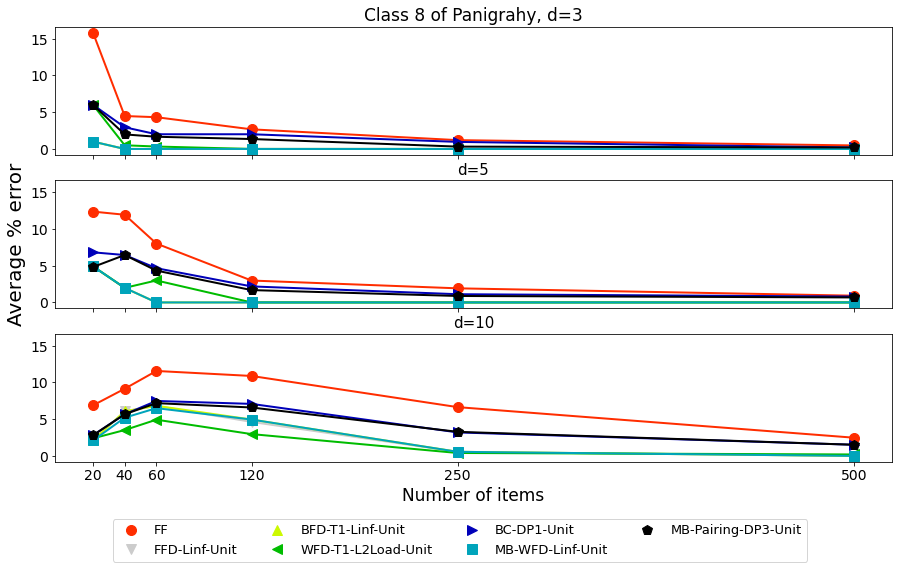

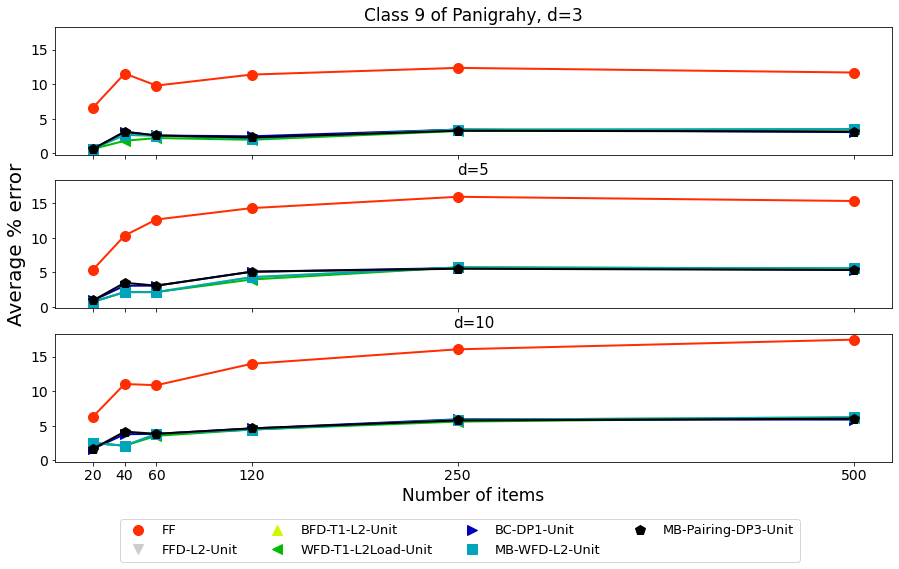

In [67]:
for c in range(1,10):
    fname = proj_path / f"plots/lines/unit_lines_P{c}.pdf"
    sel_algos_unit = create_selected_list(unit_results_P[0].loc[str(c)], unit_fam_dict, with_meta=False)
    plot_n_eps([20, 40, 60, 120, 250, 500], unit_results_P[0], str(c), sel_algos_unit,
           f"Class {c} of Panigrahy", "Number of items", "Average % error",
           ncols=4, bbox_anchor=(0.5, -0.06), filename=fname)

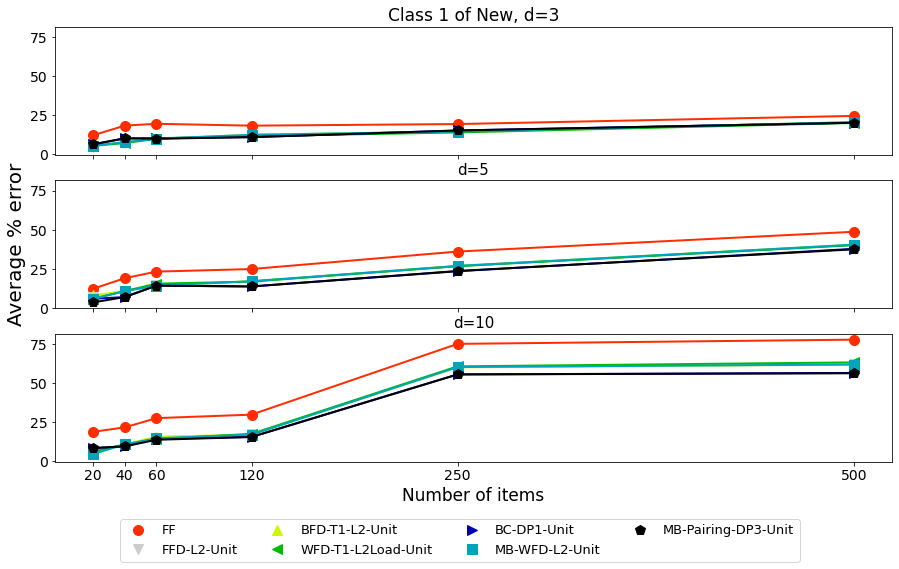

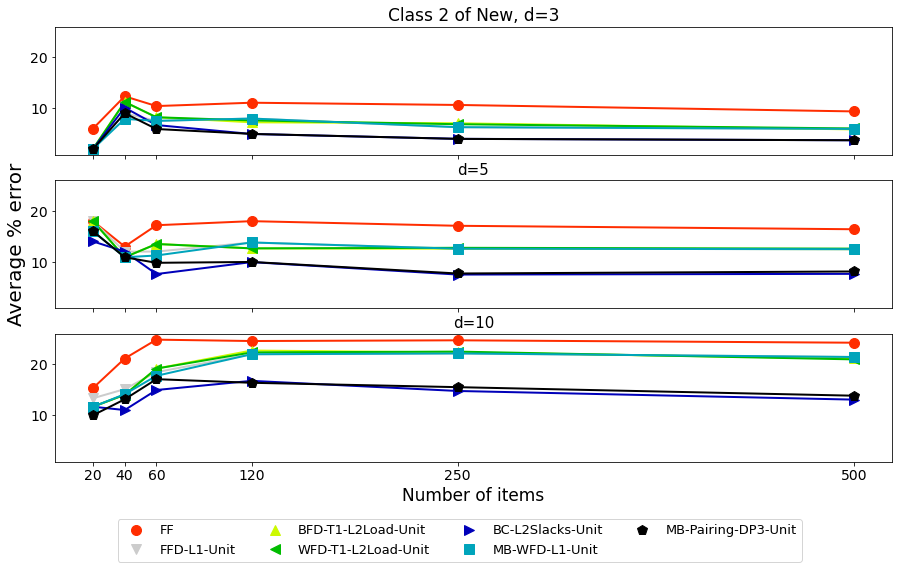

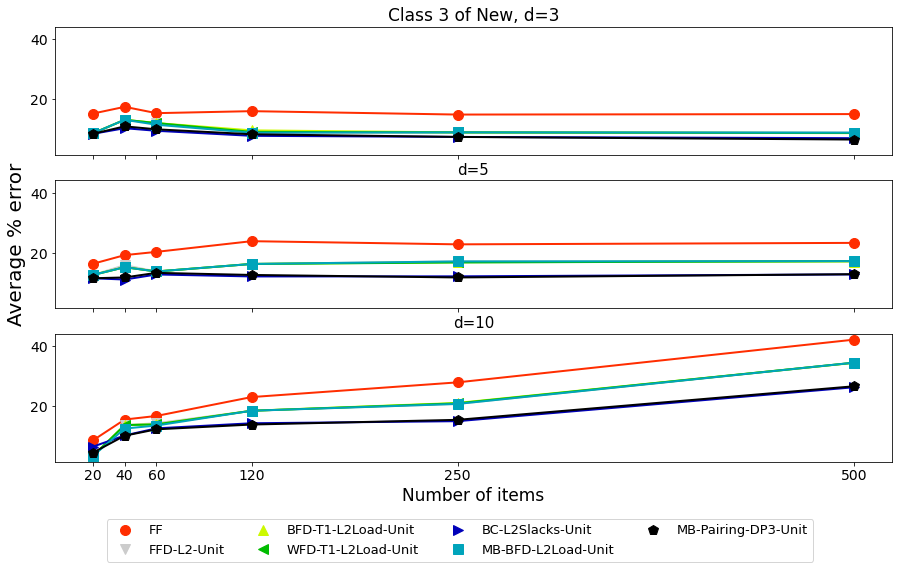

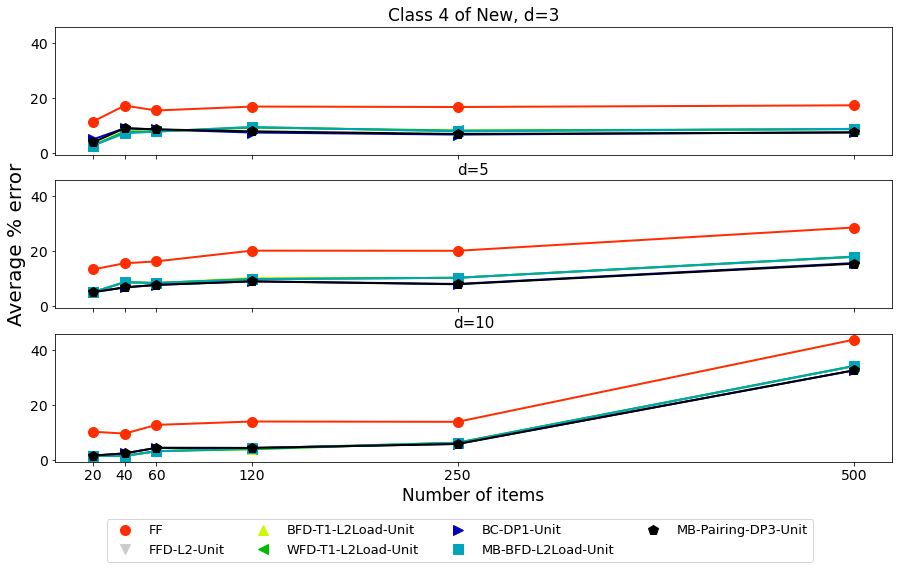

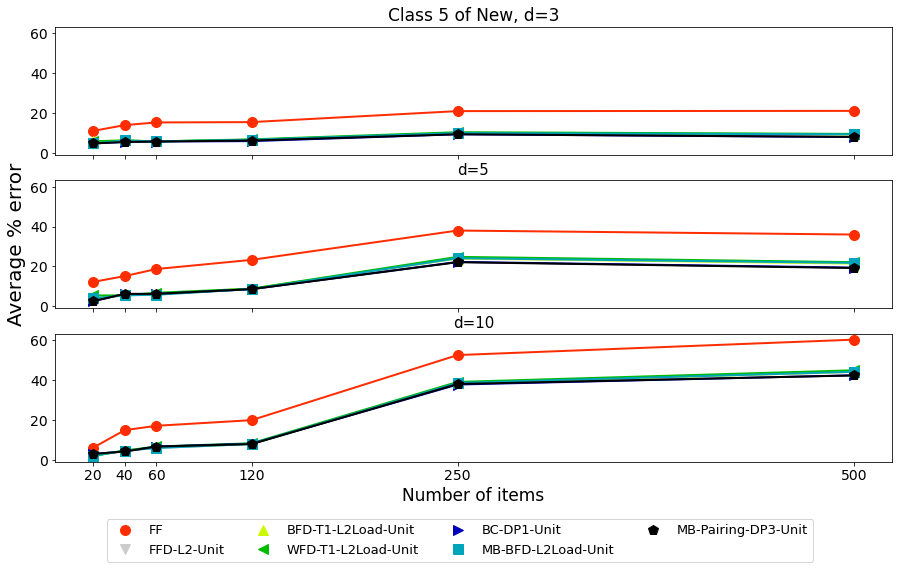

In [68]:
for c in range(1,7):
    fname = proj_path / f"plots/lines/unit_lines_I{c}.pdf"
    sel_algos_unit = create_selected_list(unit_results_I[0].loc[str(c)], unit_fam_dict, with_meta=False)
    plot_n_eps([20, 40, 60, 120, 250, 500], unit_results_I[0], str(c), sel_algos_unit,
           f"Class {c} of New", "Number of items", "Average % error",
           ncols=4, bbox_anchor=(0.5, -0.06), filename=fname)

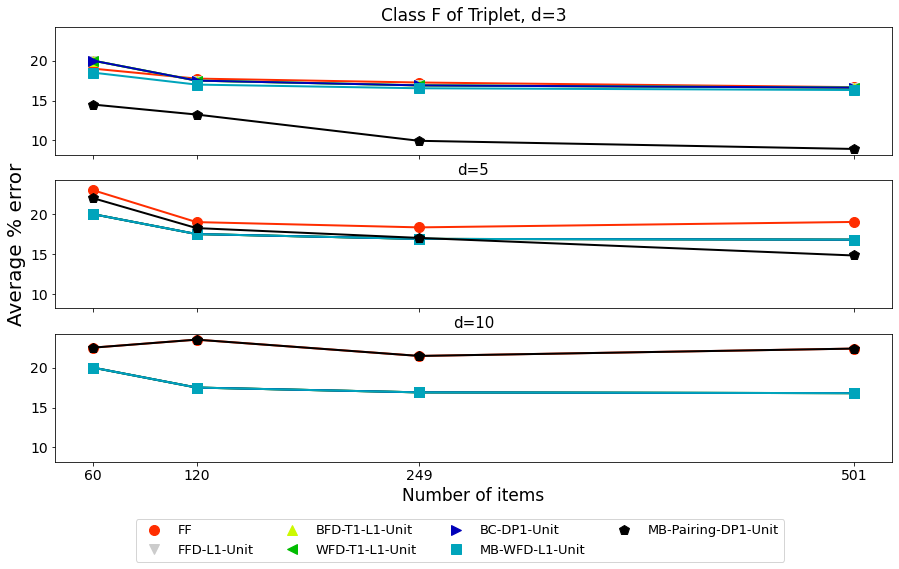

In [69]:
for c in ["F", "C"]:
    fname = proj_path / f"plots/lines/unit_lines_T{c}.pdf"
    sel_algos_unit = create_selected_list(unit_results_T[0].loc[str(c)], unit_fam_dict, with_meta=False)
    plot_n_eps([60, 120, 249, 501], unit_results_T[0], str(c), sel_algos_unit,
           f"Class {c} of Triplet", "Number of items", "Average % error",
           ncols=4, bbox_anchor=(0.5, -0.06), filename=fname)

### EPS and Time values

In [41]:
unit_results_P[1].loc[:,500,:][alg_names_unit].mean()

FF                            2.166667
FFD-L1-Unit                   2.674074
FFD-Linf-Unit                 2.548148
FFD-L2-Unit                   2.503704
BFD-T1-L1-Unit                6.959259
BFD-T1-Linf-Unit              6.822222
BFD-T1-L2-Unit                7.000000
BFD-T1-L2Load-Unit            7.025926
WFD-T1-L1-Unit                4.448148
WFD-T1-Linf-Unit              4.592593
WFD-T1-L2-Unit                4.562963
WFD-T1-L2Load-Unit            6.014815
BC-DP1-Unit                  19.622222
BC-DP2-Unit                  20.251852
BC-NormDP-Unit               27.003704
BC-L2Slacks-Unit             19.648148
BC-TFSum-Unit                19.403704
BC-TFMin-Unit                25.092593
MB-Pairing-DP1-Unit        3980.125926
MB-Pairing-DP2-Unit        7524.625926
MB-Pairing-DP3-Unit        8751.644444
MB-Pairing-NormDP-Unit    11628.062963
MB-WFD-Linf-Unit             55.948148
MB-WFD-L1-Unit               56.133333
MB-WFD-L2-Unit               57.270370
MB-BFD-L2Load-Unit       

In [42]:
unit_results_P[1][alg_names_unit].max()

FF                            6.0
FFD-L1-Unit                   6.6
FFD-Linf-Unit                 6.2
FFD-L2-Unit                   6.1
BFD-T1-L1-Unit               15.2
BFD-T1-Linf-Unit             15.1
BFD-T1-L2-Unit               15.2
BFD-T1-L2Load-Unit           15.1
WFD-T1-L1-Unit               11.3
WFD-T1-Linf-Unit             12.2
WFD-T1-L2-Unit               11.5
WFD-T1-L2Load-Unit           13.1
BC-DP1-Unit                  39.5
BC-DP2-Unit                  39.4
BC-NormDP-Unit               55.9
BC-L2Slacks-Unit             40.1
BC-TFSum-Unit                39.7
BC-TFMin-Unit                50.9
MB-Pairing-DP1-Unit       10414.3
MB-Pairing-DP2-Unit       20493.7
MB-Pairing-DP3-Unit       19202.5
MB-Pairing-NormDP-Unit    31657.9
MB-WFD-Linf-Unit             98.9
MB-WFD-L1-Unit              105.4
MB-WFD-L2-Unit              101.3
MB-BFD-L2Load-Unit           89.8
dtype: float64

##### For P5

In [43]:
sel_algos_unit_P5 = create_selected_list(unit_results_P[0].loc['5'], unit_fam_dict, with_meta=False)

In [44]:
unit_results_P[0].loc["5", 500][sel_algos_unit_P5]

FF  FFD-L2-Unit  BFD-T1-L2Load-Unit  WFD-T1-L2Load-Unit  \
d                                                                
3    5.86         5.24                5.24                5.24   
5    8.43         8.41                8.41                8.41   
10  11.48        11.47               11.47               11.47   

    BC-L2Slacks-Unit  MB-Pairing-NormDP-Unit  MB-WFD-L2-Unit  
d                                                             
3               0.93                    2.16            5.24  
5               2.48                    3.40            8.11  
10              4.31                    5.24           11.17

In [45]:
unit_results_P[1].loc['5'][sel_algos_unit_P5].mean()

FF                          0.011111
FFD-L2-Unit                 0.044444
BFD-T1-L2Load-Unit          0.166667
WFD-T1-L2Load-Unit          0.166667
BC-L2Slacks-Unit            4.666667
MB-Pairing-NormDP-Unit    613.572222
MB-WFD-L2-Unit              0.916667
dtype: float64

In [46]:
unit_results_P[1].loc['5'][sel_algos_unit_P5].max()

FF                           0.2
FFD-L2-Unit                  0.4
BFD-T1-L2Load-Unit           1.0
WFD-T1-L2Load-Unit           1.0
BC-L2Slacks-Unit            34.0
MB-Pairing-NormDP-Unit    5357.5
MB-WFD-L2-Unit               5.6
dtype: float64

##### For P8

In [28]:
sel_algos_unit_P8 = create_selected_list(unit_results_P[0].loc['8'], unit_fam_dict, with_meta=False)

In [30]:
unit_results_P[0].loc['8',500][sel_algos_unit_P8]

FF  FFD-Linf-Unit  BFD-T1-Linf-Unit  WFD-T1-L2Load-Unit  BC-DP1-Unit  \
d                                                                            
3   0.48            0.0               0.0                 0.0         0.20   
5   0.92            0.0               0.0                 0.0         0.80   
10  2.48            0.0               0.0                 0.2         1.52   

    MB-Pairing-DP3-Unit  MB-WFD-Linf-Unit  
d                                          
3                  0.20               0.0  
5                  0.68               0.0  
10                 1.52               0.0

In [132]:
unit_results_P[0].loc['8',:,5][sel_algos_unit_P8].mean()

FF                     6.353333
FFD-Linf-Unit          1.148333
BFD-T1-Linf-Unit       1.148333
WFD-T1-L2Load-Unit     1.646667
BC-DP1-Unit            3.671667
MB-WFD-Linf-Unit       1.148333
MB-Pairing-DP3-Unit    3.140000
dtype: float64

In [133]:
unit_results_P[0].loc['8',:,10][sel_algos_unit_P8].mean()

FF                     7.930000
FFD-Linf-Unit          3.363333
BFD-T1-Linf-Unit       3.416667
WFD-T1-L2Load-Unit     2.401667
BC-DP1-Unit            4.626667
MB-WFD-Linf-Unit       3.218333
MB-Pairing-DP3-Unit    4.508333
dtype: float64

In [117]:
unit_results_P[1].loc['8'][sel_algos_unit_P8].mean()

FF                        0.372222
FFD-Linf-Unit             0.416667
BFD-T1-Linf-Unit          1.216667
WFD-T1-L2Load-Unit        1.027778
BC-DP1-Unit               3.133333
MB-WFD-Linf-Unit         13.711111
MB-Pairing-DP3-Unit    1711.927778
dtype: float64

In [118]:
unit_results_P[1].loc['8'][sel_algos_unit_P8].max()

FF                         2.3
FFD-Linf-Unit              2.4
BFD-T1-Linf-Unit           6.5
WFD-T1-L2Load-Unit         5.3
BC-DP1-Unit               21.6
MB-WFD-Linf-Unit          71.3
MB-Pairing-DP3-Unit    12607.8
dtype: float64

##### For I5

In [31]:
sel_algos_unit_I5 = create_selected_list(unit_results_I[0].loc['5'], unit_fam_dict, with_meta=False)

In [32]:
unit_results_I[0].loc['5',500][sel_algos_unit_I5]

FF  FFD-L2-Unit  BFD-T1-L2Load-Unit  WFD-T1-L2Load-Unit  BC-DP1-Unit  \
d                                                                             
3   21.04         9.27                9.19                9.48         7.89   
5   36.04        21.72               21.44               22.15        19.42   
10  60.35        44.12               44.19               44.96        42.44   

    MB-Pairing-DP3-Unit  MB-BFD-L2Load-Unit  
d                                            
3                  7.96                9.27  
5                 19.21               21.80  
10                42.36               44.19

In [129]:
unit_results_I[0].loc['5',:,5][sel_algos_unit_I5].mean()

FF                     23.906667
FFD-L2-Unit            11.620000
BFD-T1-L2Load-Unit     11.655000
WFD-T1-L2Load-Unit     12.241667
BC-DP1-Unit            10.866667
MB-BFD-L2Load-Unit     11.633333
MB-Pairing-DP3-Unit    10.810000
dtype: float64

In [130]:
unit_results_I[0].loc['5',:,10][sel_algos_unit_I5].mean()

FF                     28.461667
FFD-L2-Unit            17.171667
BFD-T1-L2Load-Unit     17.213333
WFD-T1-L2Load-Unit     17.583333
BC-DP1-Unit            16.990000
MB-BFD-L2Load-Unit     17.183333
MB-Pairing-DP3-Unit    16.986667
dtype: float64

In [121]:
unit_results_I[1].loc['5'][sel_algos_unit_I5].mean()

FF                        0.411111
FFD-L2-Unit               0.594444
BFD-T1-L2Load-Unit        1.416667
WFD-T1-L2Load-Unit        1.172222
BC-DP1-Unit               3.722222
MB-BFD-L2Load-Unit       12.633333
MB-Pairing-DP3-Unit    1820.361111
dtype: float64

In [120]:
unit_results_I[1].loc['5'][sel_algos_unit_I5].max()

FF                         3.1
FFD-L2-Unit                3.6
BFD-T1-L2Load-Unit         8.5
WFD-T1-L2Load-Unit         7.3
BC-DP1-Unit               25.4
MB-BFD-L2Load-Unit        78.9
MB-Pairing-DP3-Unit    15547.7
dtype: float64

##### For TF

In [33]:
sel_algos_unit_TF = create_selected_list(unit_results_T[0].loc['F'], unit_fam_dict, with_meta=False)

In [35]:
unit_results_T[0].loc['F',501][sel_algos_unit_TF]

FF  FFD-L1-Unit  BFD-T1-L1-Unit  WFD-T1-L1-Unit  BC-DP1-Unit  \
d                                                                     
3   16.68        16.62           16.62           16.62        16.62   
5   19.02        16.80           16.80           16.80        16.80   
10  22.38        16.80           16.80           16.80        16.80   

    MB-Pairing-DP1-Unit  MB-WFD-L1-Unit  
d                                        
3                  8.94           16.32  
5                 14.82           16.80  
10                22.38           16.80

In [134]:
unit_results_T[0].loc['F',:,5][sel_algos_unit_TF].mean()

FF                     19.8400
FFD-L1-Unit            17.8000
BFD-T1-L1-Unit         17.8000
WFD-T1-L1-Unit         17.8000
BC-DP1-Unit            17.8000
MB-WFD-L1-Unit         17.8000
MB-Pairing-DP1-Unit    18.0225
dtype: float64

In [135]:
unit_results_T[0].loc['F',:,10][sel_algos_unit_TF].mean()

FF                     22.46
FFD-L1-Unit            17.80
BFD-T1-L1-Unit         17.80
WFD-T1-L1-Unit         17.80
BC-DP1-Unit            17.80
MB-WFD-L1-Unit         17.80
MB-Pairing-DP1-Unit    22.46
dtype: float64

In [123]:
unit_results_T[1].loc['F'][sel_algos_unit_TF].mean()

FF                        0.416667
FFD-L1-Unit               0.475000
BFD-T1-L1-Unit            1.608333
WFD-T1-L1-Unit            0.933333
BC-DP1-Unit               7.575000
MB-WFD-L1-Unit           14.966667
MB-Pairing-DP1-Unit    1827.658333
dtype: float64

In [124]:
unit_results_T[1].loc['F'][sel_algos_unit_TF].max()

FF                        2.0
FFD-L1-Unit               2.1
BFD-T1-L1-Unit            5.9
WFD-T1-L1-Unit            3.0
BC-DP1-Unit              36.3
MB-WFD-L1-Unit           58.2
MB-Pairing-DP1-Unit    9633.2
dtype: float64

## Plot for each class - Average with n=500

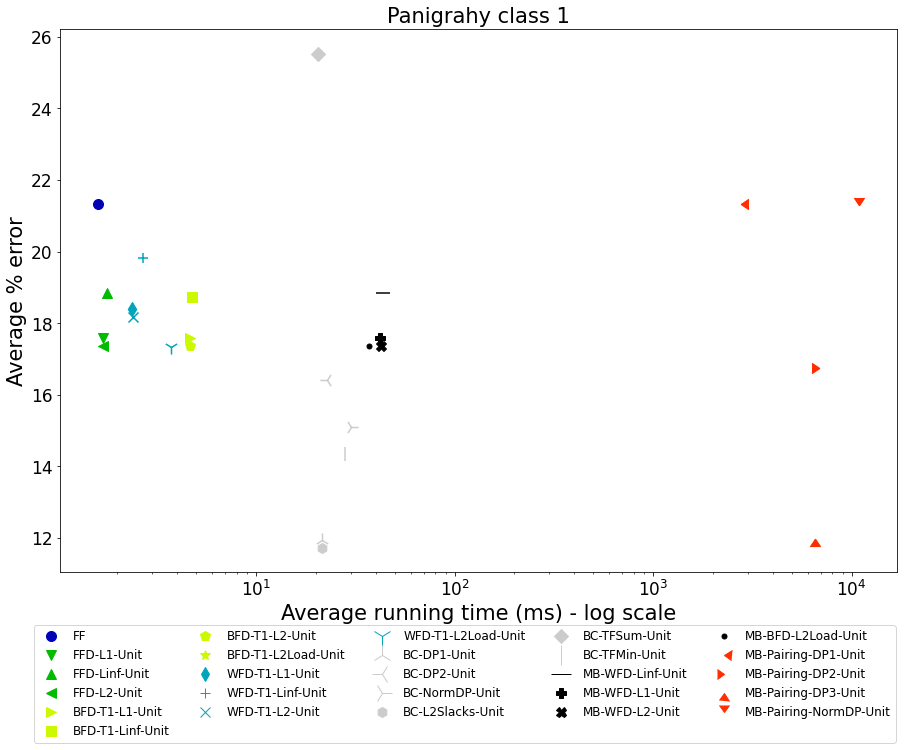

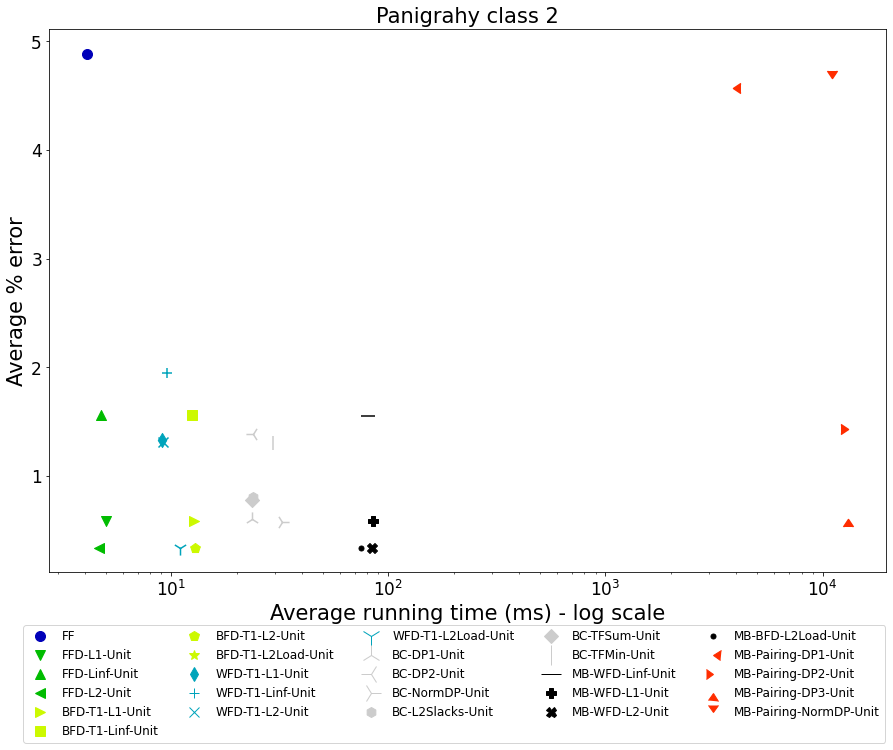

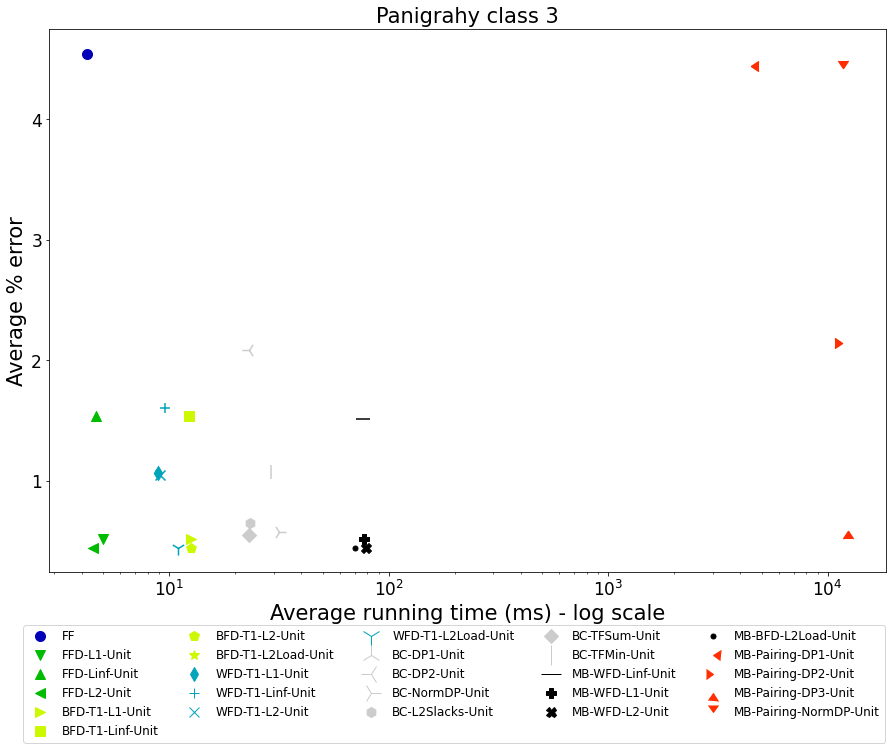

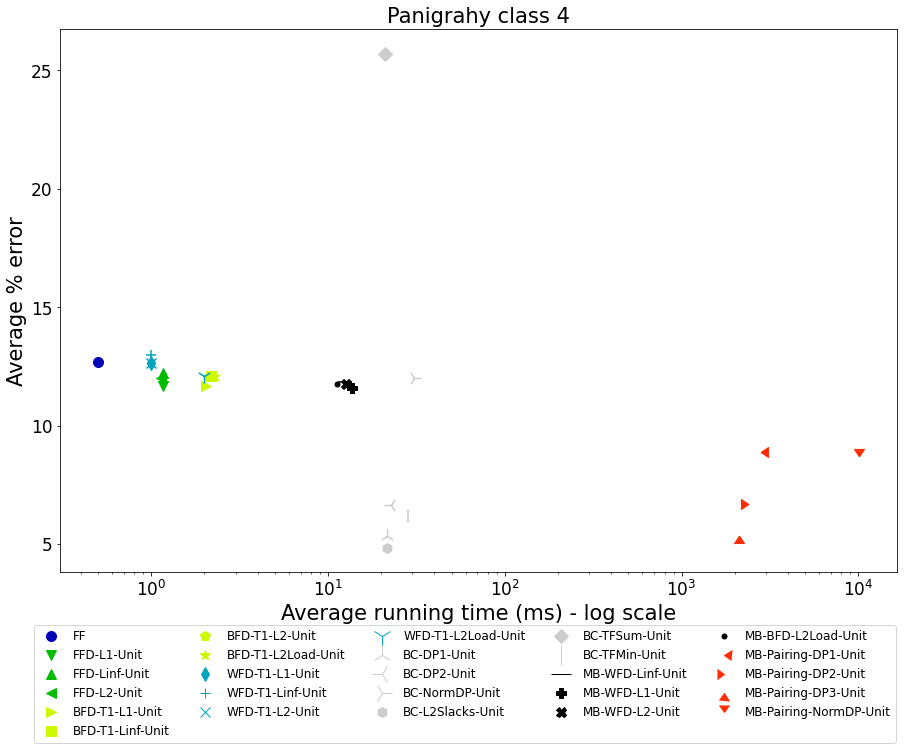

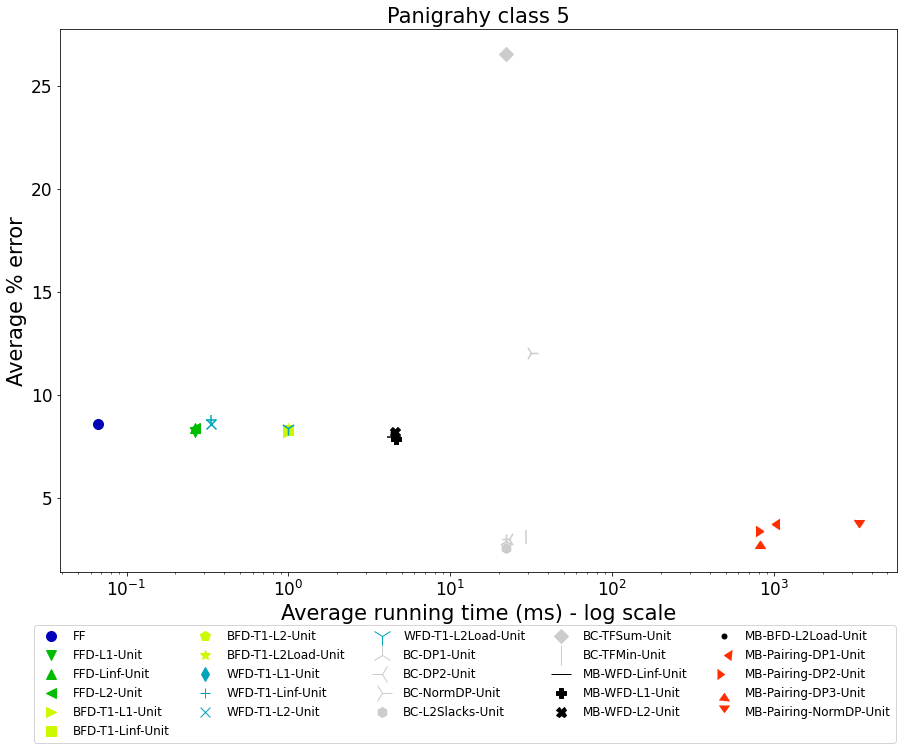

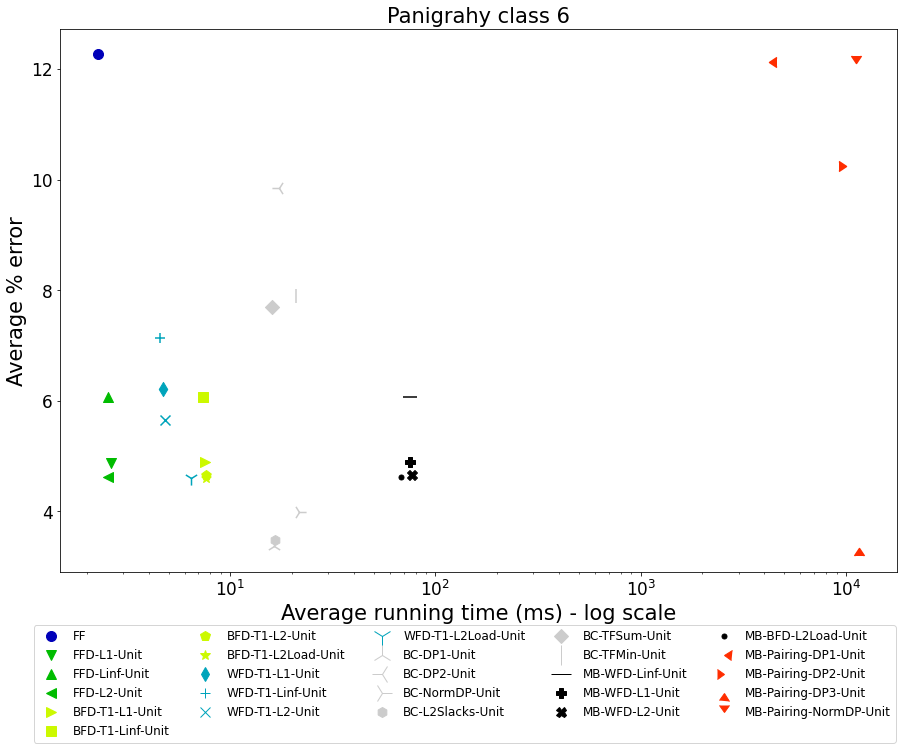

In [84]:
for c in range(1,10):
    fname = proj_path / f"plots/all_classes/unit_n500_P{c}.pdf"
    plot_summary_family(unit_results_P[1].loc[str(c), 500], unit_results_P[0].loc[str(c), 500], alg_names_unit,
            f"Panigrahy class {c}", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname,
            bbox_anchor_y=-0.12)

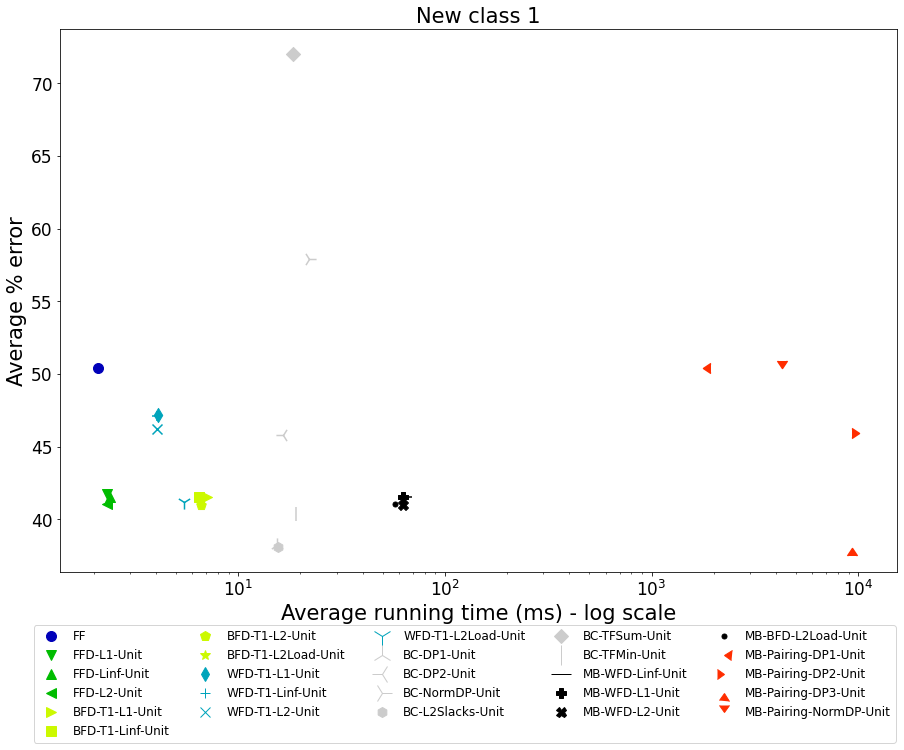

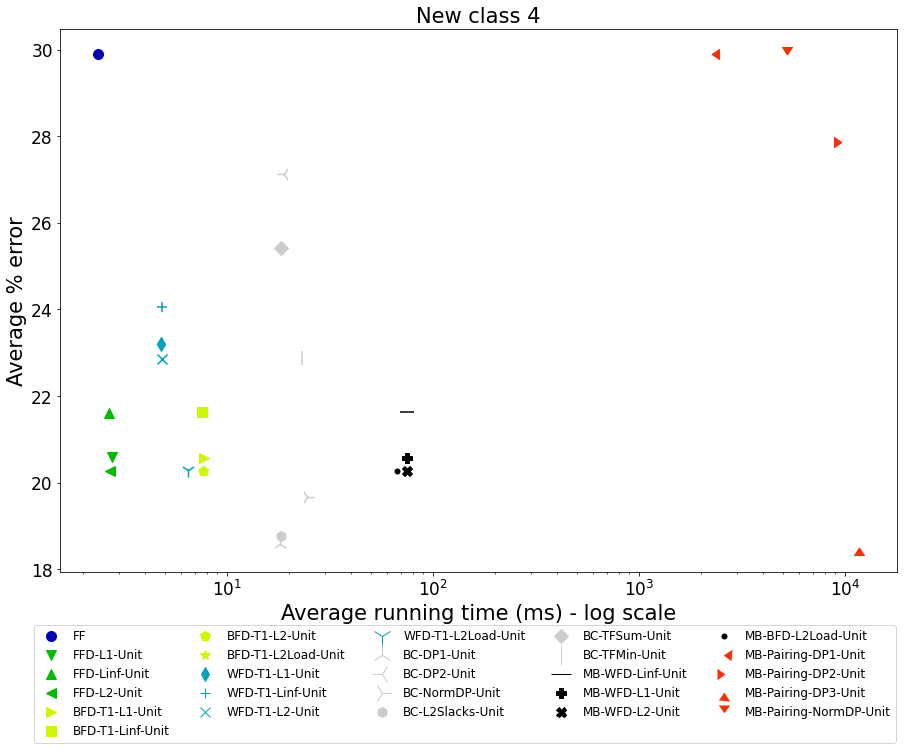

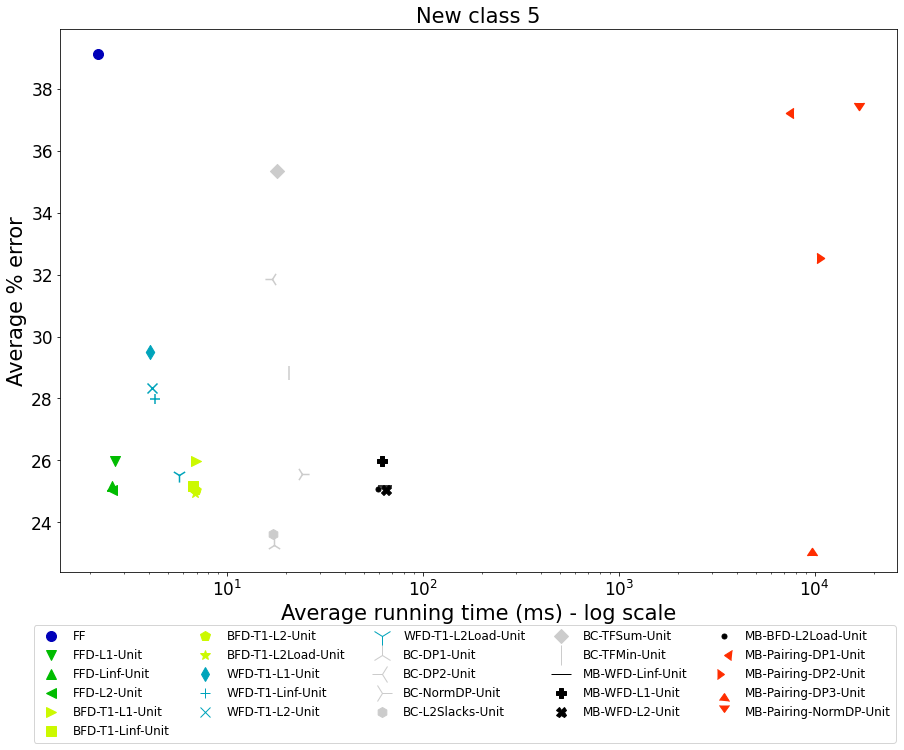

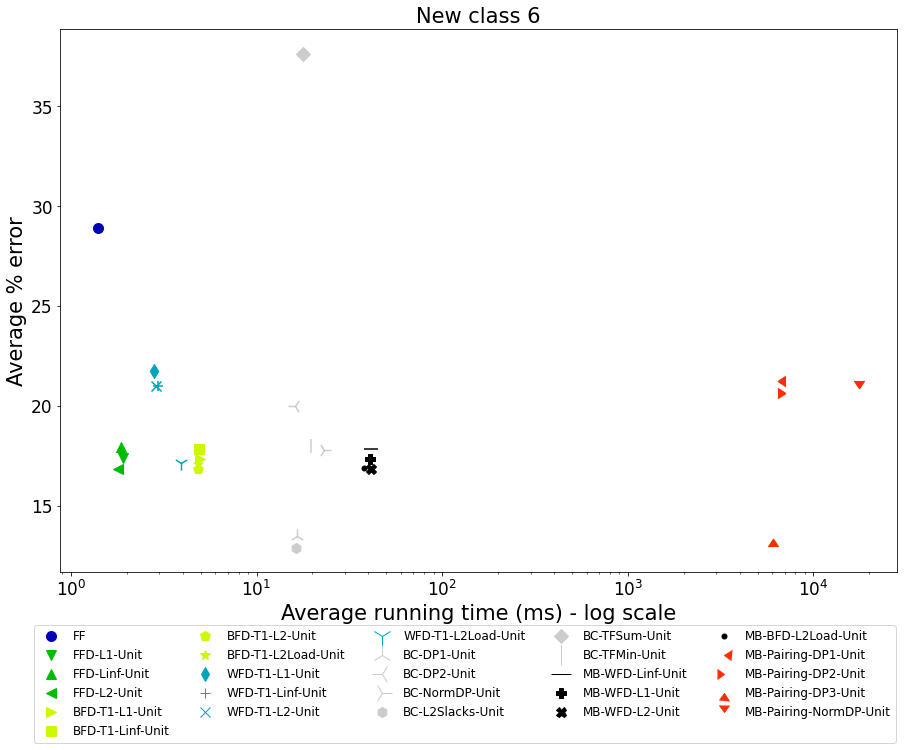

In [85]:
for c in range(1,7):
    fname = proj_path / f"plots/all_classes/unit_n500_I{c}.pdf"
    plot_summary_family(unit_results_I[1].loc[str(c), 500], unit_results_I[0].loc[str(c), 500], alg_names_unit,
            f"New class {c}", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname,
            simplify_dict=False,
            bbox_anchor_y=-0.12)

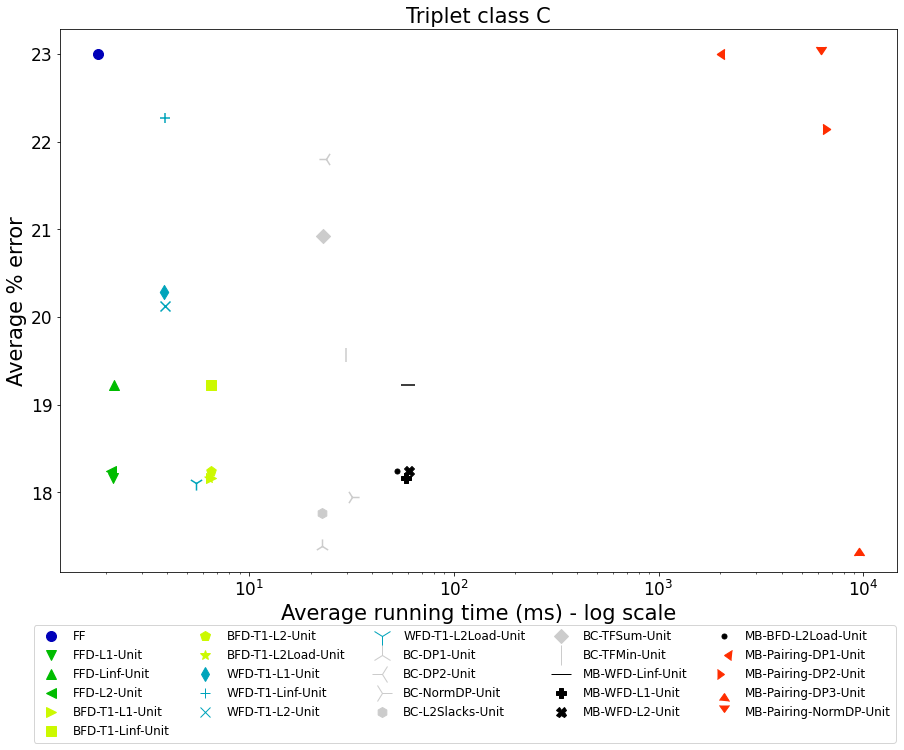

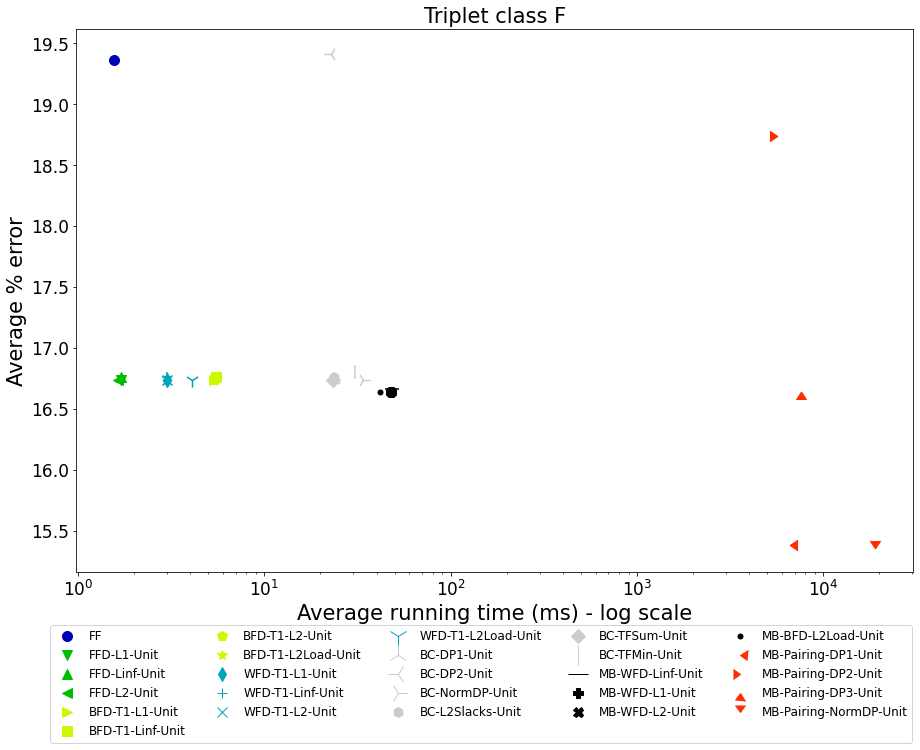

In [86]:
for c in ["C", "F"]:
    fname = proj_path / f"plots/all_classes/unit_n501_T{c}.pdf"
    plot_summary_family(unit_results_T[1].loc[str(c), 501], unit_results_T[0].loc[str(c), 501], alg_names_unit,
            f"Triplet class {c}", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname,
            simplify_dict=False,
            bbox_anchor_y=-0.12)

## Plot selected classes only - big average and n=500
### Class P5

In [ ]:
idxP5 = unit_results_P[0].loc["5"][alg_names_unit].mean().sort_values().head(15).index

In [ ]:
unit_results_P[0].loc["5"][idxP5].mean()

In [ ]:
unit_results_P[1].loc["5",500,:][idxP5].describe()

In [ ]:
alg_unit_P5 = alg_names_unit.copy()
alg_unit_P5.remove('BC-TFSum-Unit') # Removed because greatly outperformed by all others
fname = proj_path / "plots/algos_unit_P5.pdf"
plot_summary_family(unit_results_P[1].loc["5",500], unit_results_P[0].loc["5",500], alg_unit_P5,
            "", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname,
            bbox_anchor=(0.3, 0.12), ncols=2)

### Class P8

In [87]:
idxP8 = unit_results_P[0].loc["8",500][alg_names_unit].mean().sort_values().head(15).index

In [88]:
unit_results_P[0].loc["8",500][idxP8].mean()

FFD-Linf-Unit          0.000000
BFD-T1-Linf-Unit       0.000000
MB-WFD-Linf-Unit       0.000000
WFD-T1-Linf-Unit       0.013333
WFD-T1-L2-Unit         0.053333
FFD-L2-Unit            0.066667
BFD-T1-L2-Unit         0.066667
BFD-T1-L2Load-Unit     0.066667
MB-BFD-L2Load-Unit     0.066667
WFD-T1-L2Load-Unit     0.066667
MB-WFD-L2-Unit         0.066667
MB-WFD-L1-Unit         0.760000
MB-Pairing-DP3-Unit    0.800000
BC-DP1-Unit            0.840000
FFD-L1-Unit            0.866667
dtype: float64

In [91]:
unit_results_P[1].loc["8",500][idxP8].describe()

FFD-Linf-Unit  BFD-T1-Linf-Unit  MB-WFD-Linf-Unit  WFD-T1-Linf-Unit  \
count           3.00          3.000000          3.000000          3.000000   
mean            2.30          6.133333         65.666667          3.733333   
std             0.10          0.321455          4.921721          0.550757   
min             2.20          5.900000         62.200000          3.200000   
25%             2.25          5.950000         62.850000          3.450000   
50%             2.30          6.000000         63.500000          3.700000   
75%             2.35          6.250000         67.400000          4.000000   
max             2.40          6.500000         71.300000          4.300000   

       WFD-T1-L2-Unit  FFD-L2-Unit  BFD-T1-L2-Unit  BFD-T1-L2Load-Unit  \
count        3.000000     3.000000        3.000000            3.000000   
mean         4.133333     2.333333        6.366667            6.333333   
std          0.057735     0.057735        0.230940            0.208167   
min          4.100000     2.300000        6.100000            6.100000   
25%          4.100000     2.300000        6.300000            6.250000   
50%          4.100000     2.300000        6.500000            6.400000   
75%          4.150000     2.350000        6.500000            6.450000   
max          4.200000     2.400000        6.500000            6.500000   

       MB-BFD-L2Load-Unit  WFD-T1-L2Load-Unit  MB-WFD-L2-Unit  MB-WFD-L1-Unit  \
count            3.000000            3.000000        3.000000        3.000000   
mean            59.866667            5.166667       68.800000       57.466667   
std              4.200397            0.115470        5.692978        4.536886   
min             57.100000            5.100000       64.700000       52.300000   
25%             57.450000            5.100000       65.550000       55.800000   
50%             57.800000            5.100000       66.400000       59.300000   
75%             61.250000            5.200000       70.850000       60.050000   
max             64.700000            5.300000       75.300000       60.800000   

       MB-Pairing-DP3-Unit  BC-DP1-Unit  FFD-L1-Unit  
count             3.000000     3.000000     3.000000  
mean           9177.833333    15.266667     2.533333  
std            2978.445327     5.686241     0.057735  
min            7244.600000    10.600000     2.500000  
25%            7462.850000    12.100000     2.500000  
50%            7681.100000    13.600000     2.500000  
75%           10144.450000    17.600000     2.550000  
max           12607.800000    21.600000     2.600000

In [ ]:
fname = proj_path / "plots/algos_unit_P8.pdf"
plot_summary_family(unit_results_P[1].loc["8",500], unit_results_P[0].loc["8",500], alg_names_unit,
            "", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname,
            bbox_anchor=(0.64, 0.64), ncols=3)
####### legend VOLUNTARILY out of bound here BUT correctly placed in the output PDF

### Class I5

In [ ]:
idxI5 = unit_results_I[0].loc["5"][alg_names_unit].mean().sort_values().head(15).index

In [ ]:
unit_results_I[0].loc["5"][idxI5].mean()

In [ ]:
unit_results_I[1].loc["5",500,:][idxI5].describe()

In [ ]:
fname = proj_path / "plots/algos_unit_I5.pdf"
plot_summary_family(unit_results_I[1].loc["5"], unit_results_I[0].loc["5"], alg_names_unit,
            "", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname,
            bbox_anchor=(0.58, 0.54), ncols=2)
           ####### legend VOLUNTARILY out of bound here BUT correctly placed in the output PDF

### Class TF

In [ ]:
idxTF = unit_results_T[0].loc["F"][alg_names_unit].mean().sort_values().head(15).index

In [ ]:
unit_results_T[0].loc["F"][idxTF].mean()

In [ ]:
unit_results_T[1].loc["F",501,:][idxTF].describe()

In [ ]:
fname = proj_path / "plots/algos_unit_TF.pdf"
plot_summary_family(unit_results_T[1].loc["F"], unit_results_T[0].loc["F"], alg_names_unit,
            "", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname,
            bbox_anchor=(0.64, 0.64), ncols=3)
####### legend VOLUNTARILY out of bound here BUT correctly placed in the output PDF

### Count avg items per bin in a class

In [ ]:
P5 = df_P[df_P['class'] == '5'].index
(df_P.iloc[P5]['n'] / df_P.iloc[P5]['LB_or_OPT']).describe()

In [ ]:
P8 = df_P[df_P['class'] == '8'].index
(df_P.iloc[P8]['n'] / df_P.iloc[P8]['LB_or_OPT']).describe()

In [ ]:
I5 = df_I[df_I['class'] == '5'].index
(df_I.iloc[I5]['n'] / df_I.iloc[I5]['LB_or_OPT']).describe()

## Compare two algorithms together

In [ ]:
def my_sup(x):
    return x[x > 0].count()

def my_eq(x):
    return x[x == 0].count()

def my_low(x):
    return x[x < 0].count()

def make_diff(df, list1, list2):
    a = df[list1]
    b = df[list2]
    b.columns = a.columns
    df_diff = (a - b).agg(['mean', 'std', my_sup, my_eq, my_low])
    return df_diff

def make_all_diff(list1, list2):
    diff_P = make_diff(big_df_P, list1, list2)
    diff_I = make_diff(big_df_I, list1, list2)
    diff_T = make_diff(big_df_T, list1, list2)
    diff_df = pd.concat([diff_P, diff_I, diff_T], axis=1)
    diff_df.columns = ["diff_P", "diff_I", "diff_T"]
    return diff_df

# When comparing algo A with algo B
# Mean is negative when algo A is better than B
# my_sup counts when sol of A is worse than B
# my_low counts when sol of A is better than B

In [ ]:
df_diff = make_all_diff(["FFD-SumSq-Unit"], ["BFD-T1-SumSq-Unit"])
df_diff

In [ ]:
df_diff = make_all_diff(["FFD-SumSq-Unit"], ["WFD-T1-SumSqLoad-Unit"])
df_diff

In [ ]:
df_diff = make_all_diff(["FFD-SumSq-Unit"], ["BCS-DP1-Unit"])
df_diff

In [ ]:
df_diff = make_all_diff(["FFD-SumSq-Unit"], ["BIM-BS-DP3-Unit"])
df_diff

In [ ]:
df_diff = make_all_diff(["BCS-DP1-Unit"], ["BIM-BS-DP3-Unit"])
df_diff

In [ ]:
df_diff = make_all_diff(["BCS-DP1-Unit"], ["BCS-NormDP-Unit"])
df_diff

In [ ]:
# Find instances with identical result for the 4 algos
ddf = big_df_P
x = ddf[ddf["BCS-DP1-Unit"] == ddf["BIM-BS-DP3-Unit"]].index
y = ddf.loc[x][ddf["FFD-SumSq-Unit"].loc[x] == ddf["WFD-T1-SumSqLoad-Unit"].loc[x]].index
z = ddf.loc[y][ddf["FFD-SumSq-Unit"].loc[y] == ddf["BCS-DP1-Unit"].loc[y]]
z[["class", "n", "d", "FFD-SumSq-Unit", "WFD-T1-SumSqLoad-Unit", "BCS-DP1-Unit", "BIM-BS-DP3-Unit"]]

In [ ]:
# Find how many of these instances per class
aa = z[["class", "n", "d", "FFD-SumSq-Unit"]].groupby(by=["class", "n", "d"], as_index=True).count()

In [ ]:
for c in range(1,10):
    print("class", c)
    print(aa.loc[str(c)].sum())

## Check optimal solution found

In [74]:
def print_optimal_found(df, benchmark_name, algo_names, full=False):
    if benchmark_name == "P":
        l = range(1,10)
    elif benchmark_name == "I":
        l = range(1,7)
    else: # "T"
        l = ["C", "F"]
        
    sum1 = 0
    sum2 = 0
        
    for c in l:
        sub_df = df[df['class'] == str(c)]
        best_sol = sub_df[algo_names].min(axis=1)
        proved_opt = (sub_df["LB"] == best_sol).sum()
        found_opt = (sub_df["LB_or_OPT"] == best_sol).sum()
        sum1+=proved_opt
        sum2+=found_opt
        
        if full:
            print(f"Class {c}: {proved_opt} proved optimality (sol = LB) over {sub_df.shape[0]} instances")
            print(f"\t {found_opt} optimal solution found")
    
    print(f"Total: {sum1} proved optimality over {df.shape[0]} instances")
    print(f"Total: {sum2} optimal found over {df.shape[0]} instances")

In [75]:
centric_unit = [x for x in alg_names_unit if not "MB-" in x]

In [76]:
# With only the iten-centric and bin-centric algos with Unit weights
print("--- For Panigrahy instances ---")
print_optimal_found(df_P, "P", centric_unit)
print("\n--- For New instances ---")
print_optimal_found(df_I, "I", centric_unit)
print("\n--- For Triplet instances ---")
print_optimal_found(df_T, "T", centric_unit)

--- For Panigrahy instances ---
Total: 597 proved optimality over 1620 instances
Total: 889 optimal found over 1620 instances

--- For New instances ---
Total: 84 proved optimality over 1080 instances
Total: 197 optimal found over 1080 instances

--- For Triplet instances ---
Total: 0 proved optimality over 240 instances
Total: 0 optimal found over 240 instances


In [77]:
# With all algos with Unit weights
print("--- For Panigrahy instances ---")
print_optimal_found(df_P, "P", alg_names_unit)
print("\n--- For New instances ---")
print_optimal_found(df_I, "I", alg_names_unit)
print("\n--- For Triplet instances ---")
print_optimal_found(df_T, "T", alg_names_unit)

--- For Panigrahy instances ---
Total: 601 proved optimality over 1620 instances
Total: 893 optimal found over 1620 instances

--- For New instances ---
Total: 87 proved optimality over 1080 instances
Total: 200 optimal found over 1080 instances

--- For Triplet instances ---
Total: 0 proved optimality over 240 instances
Total: 0 optimal found over 240 instances


In [78]:
centric_all = [x for x in all_algos if not "MB-" in x]
print(len(centric_all))

275


In [79]:
# With only item-centric and bin-centric algos with all weights
print("--- For Panigrahy instances ---")
print_optimal_found(df_P, "P", centric_all)
print("\n--- For New instances ---")
print_optimal_found(df_I, "I", centric_all)
print("\n--- For Triplet instances ---")
print_optimal_found(df_T, "T", centric_all)

--- For Panigrahy instances ---
Total: 637 proved optimality over 1620 instances
Total: 985 optimal found over 1620 instances

--- For New instances ---
Total: 113 proved optimality over 1080 instances
Total: 257 optimal found over 1080 instances

--- For Triplet instances ---
Total: 0 proved optimality over 240 instances
Total: 0 optimal found over 240 instances


In [80]:
# With all algos and all weights
print("--- For Panigrahy instances ---")
print_optimal_found(df_P, "P", all_algos)
print("\n--- For New instances ---")
print_optimal_found(df_I, "I", all_algos)
print("\n--- For Triplet instances ---")
print_optimal_found(df_T, "T", all_algos)

--- For Panigrahy instances ---
Total: 643 proved optimality over 1620 instances
Total: 992 optimal found over 1620 instances

--- For New instances ---
Total: 116 proved optimality over 1080 instances
Total: 260 optimal found over 1080 instances

--- For Triplet instances ---
Total: 0 proved optimality over 240 instances
Total: 0 optimal found over 240 instances


# Comparison with Avg weight

In [87]:
# Computing aggregated results once and for all
# For all Centric + Multibin algos
big_results_P = get_results(df_P, all_algos, ['class', 'n', 'd'], group_as_index=True)
big_results_I = get_results(df_I, all_algos, ['class', 'n', 'd'], group_as_index=True)
big_results_T = get_results(df_T, all_algos, ['class', 'n', 'd'], group_as_index=True)
# results contains: eps, time, diff, diff_best, best, match_LB

In [88]:
avg_fam_dict = create_simple_family_dict(alg_names_unit)
del avg_fam_dict["FF"]
#del avg_fam_dict["BFD"]
#del avg_fam_dict["WFD"]

In [89]:
def augment_algo_list(l):
    newl = []
    for x in l:
        newl.append(x)
        newl.append(x.replace('Unit', 'Avg'))
        newl.append(x.replace('Unit', 'Avg-Dyn'))
    return newl

## selected class P5

In [90]:
temp_list = create_selected_list(unit_results_P[0].loc['5'], avg_fam_dict, with_meta=False)
test_unit_P5 = augment_algo_list(temp_list)

In [91]:
big_results_P[0].loc['5',500][test_unit_P5]

FFD-L2-Unit  FFD-L2-Avg  FFD-L2-Avg-Dyn  BFD-T1-L2Load-Unit  \
d                                                                 
3          5.24        4.62            4.31                5.24   
5          8.41        7.79            6.83                8.41   
10        11.47       10.86            9.33               11.47   

    BFD-T1-L2Load-Avg  BFD-T1-L2Load-Avg-Dyn  WFD-T1-L2Load-Unit  \
d                                                                  
3                4.62                   4.31                5.24   
5                7.79                   7.15                8.41   
10              11.17                  11.48               11.47   

    WFD-T1-L2Load-Avg  WFD-T1-L2Load-Avg-Dyn  BC-L2Slacks-Unit  \
d                                                                
3                4.62                   4.31              0.93   
5                7.79                   6.83              2.48   
10              11.17                   9.33              4.31   

    BC-L2Slacks-Avg  BC-L2Slacks-Avg-Dyn  MB-WFD-L2-Unit  MB-WFD-L2-Avg  \
d                                                                         
3              1.24                 1.24            5.24           4.62   
5              2.48                 2.48            8.11           7.79   
10             4.00                 4.00           11.17          10.86   

    MB-WFD-L2-Avg-Dyn  MB-Pairing-NormDP-Unit  MB-Pairing-NormDP-Avg  \
d                                                                      
3                5.55                    2.16                   1.85   
5                8.43                    3.40                   3.40   
10              11.48                    5.24                   5.24   

    MB-Pairing-NormDP-Avg-Dyn  
d                              
3                        1.85  
5                        3.40  
10                       5.24

In [92]:
big_results_P[1].loc['5',500][test_unit_P5]

FFD-L2-Unit  FFD-L2-Avg  FFD-L2-Avg-Dyn  BFD-T1-L2Load-Unit  \
d                                                                 
3           0.3         0.3            12.0                 1.0   
5           0.1         0.1            16.0                 1.0   
10          0.4         0.4            27.8                 1.0   

    BFD-T1-L2Load-Avg  BFD-T1-L2Load-Avg-Dyn  WFD-T1-L2Load-Unit  \
d                                                                  
3                 1.0                   14.0                 1.0   
5                 1.0                   18.0                 1.0   
10                1.0                   30.1                 1.0   

    WFD-T1-L2Load-Avg  WFD-T1-L2Load-Avg-Dyn  BC-L2Slacks-Unit  \
d                                                                
3                 1.0                   14.0              13.0   
5                 1.0                   18.0              19.0   
10                1.0                   30.8              34.0   

    BC-L2Slacks-Avg  BC-L2Slacks-Avg-Dyn  MB-WFD-L2-Unit  MB-WFD-L2-Avg  \
d                                                                         
3              13.0                 13.0             3.4            3.8   
5              19.0                 19.0             4.6            4.7   
10             34.1                 34.4             5.6            6.0   

    MB-WFD-L2-Avg-Dyn  MB-Pairing-NormDP-Unit  MB-Pairing-NormDP-Avg  \
d                                                                      
3                28.6                  1821.2                 1835.9   
5                46.1                  2817.2                 2821.2   
10               82.9                  5357.5                 5336.5   

    MB-Pairing-NormDP-Avg-Dyn  
d                              
3                      1822.4  
5                      2816.1  
10                     5329.7

In [93]:
big_results_P[1].loc['5',500,:][test_unit_P5].mean()

FFD-L2-Unit                     0.266667
FFD-L2-Avg                      0.266667
FFD-L2-Avg-Dyn                 18.600000
BFD-T1-L2Load-Unit              1.000000
BFD-T1-L2Load-Avg               1.000000
BFD-T1-L2Load-Avg-Dyn          20.700000
WFD-T1-L2Load-Unit              1.000000
WFD-T1-L2Load-Avg               1.000000
WFD-T1-L2Load-Avg-Dyn          20.933333
BC-L2Slacks-Unit               22.000000
BC-L2Slacks-Avg                22.033333
BC-L2Slacks-Avg-Dyn            22.133333
MB-WFD-L2-Unit                  4.533333
MB-WFD-L2-Avg                   4.833333
MB-WFD-L2-Avg-Dyn              52.533333
MB-Pairing-NormDP-Unit       3331.966667
MB-Pairing-NormDP-Avg        3331.200000
MB-Pairing-NormDP-Avg-Dyn    3322.733333
dtype: float64

In [94]:
big_results_P[1].loc['5'][test_unit_P5].max()

FFD-L2-Unit                     0.4
FFD-L2-Avg                      0.4
FFD-L2-Avg-Dyn                 27.8
BFD-T1-L2Load-Unit              1.0
BFD-T1-L2Load-Avg               1.0
BFD-T1-L2Load-Avg-Dyn          30.1
WFD-T1-L2Load-Unit              1.0
WFD-T1-L2Load-Avg               1.0
WFD-T1-L2Load-Avg-Dyn          30.8
BC-L2Slacks-Unit               34.0
BC-L2Slacks-Avg                34.1
BC-L2Slacks-Avg-Dyn            34.4
MB-WFD-L2-Unit                  5.6
MB-WFD-L2-Avg                   6.0
MB-WFD-L2-Avg-Dyn              82.9
MB-Pairing-NormDP-Unit       5357.5
MB-Pairing-NormDP-Avg        5336.5
MB-Pairing-NormDP-Avg-Dyn    5329.7
dtype: float64

In [95]:
big_results_P[1].loc[:,500,:][test_unit_P5].mean()

FFD-L2-Unit                      2.503704
FFD-L2-Avg                       2.481481
FFD-L2-Avg-Dyn                  20.037037
BFD-T1-L2Load-Unit               7.025926
BFD-T1-L2Load-Avg                7.025926
BFD-T1-L2Load-Avg-Dyn           39.074074
WFD-T1-L2Load-Unit               6.014815
WFD-T1-L2Load-Avg                6.018519
WFD-T1-L2Load-Avg-Dyn           39.696296
BC-L2Slacks-Unit                19.648148
BC-L2Slacks-Avg                 19.577778
BC-L2Slacks-Avg-Dyn             19.740741
MB-WFD-L2-Unit                  57.270370
MB-WFD-L2-Avg                   57.259259
MB-WFD-L2-Avg-Dyn              110.218519
MB-Pairing-NormDP-Unit       11628.062963
MB-Pairing-NormDP-Avg        11687.174074
MB-Pairing-NormDP-Avg-Dyn    11682.322222
dtype: float64

In [96]:
big_results_P[1][test_unit_P5].max()

FFD-L2-Unit                      6.1
FFD-L2-Avg                       6.1
FFD-L2-Avg-Dyn                  33.4
BFD-T1-L2Load-Unit              15.1
BFD-T1-L2Load-Avg               15.1
BFD-T1-L2Load-Avg-Dyn           84.4
WFD-T1-L2Load-Unit              13.1
WFD-T1-L2Load-Avg               13.2
WFD-T1-L2Load-Avg-Dyn           86.4
BC-L2Slacks-Unit                40.1
BC-L2Slacks-Avg                 39.6
BC-L2Slacks-Avg-Dyn             40.1
MB-WFD-L2-Unit                 101.3
MB-WFD-L2-Avg                  101.6
MB-WFD-L2-Avg-Dyn              382.7
MB-Pairing-NormDP-Unit       31657.9
MB-Pairing-NormDP-Avg        32881.0
MB-Pairing-NormDP-Avg-Dyn    33070.9
dtype: float64

In [97]:
fname = proj_path / f"plots/avg_n500d10_P5.pdf"
plot_summary_family(big_results_P[1].loc['5',500,10], big_results_P[0].loc['5',500,10], test_unit_P5,
        f"Panigrahy class 5 - n=500 d=10", "Average running time (ms) - log scale", "Average % error",
        log_scale=True, filename=fname, do_mean=False,
        bbox_anchor=(0.795, 0.38), ncols=1, short_markers=True)

### Plot all classes for n=500

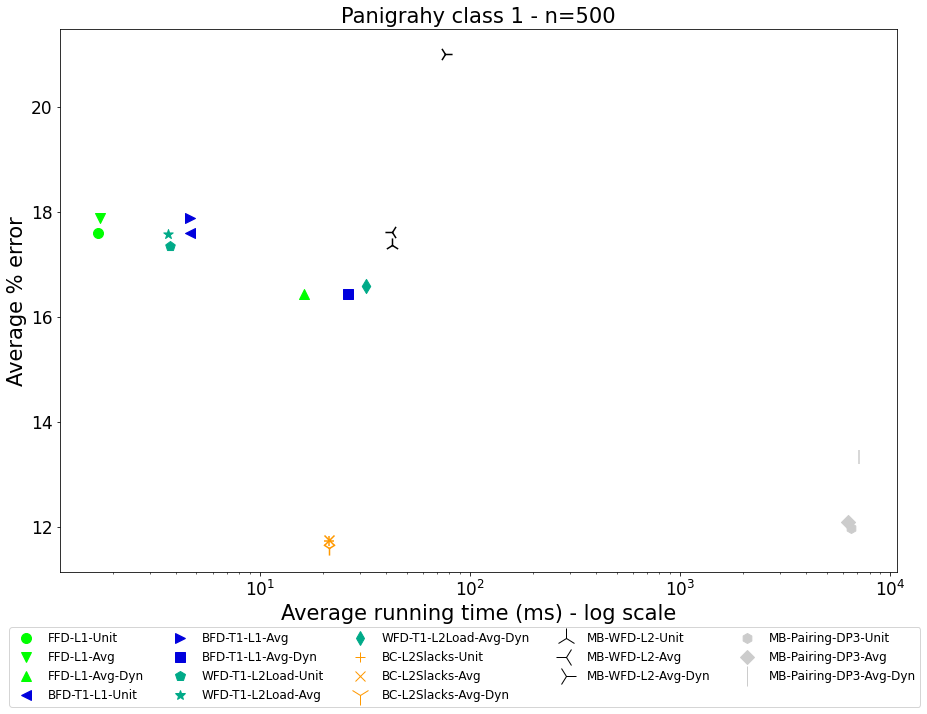

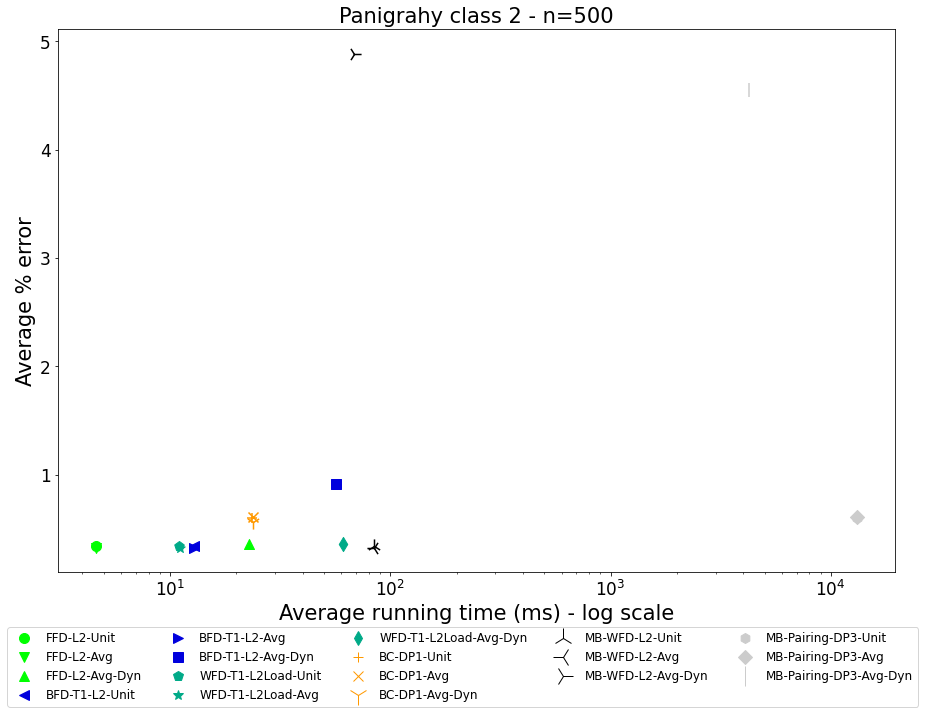

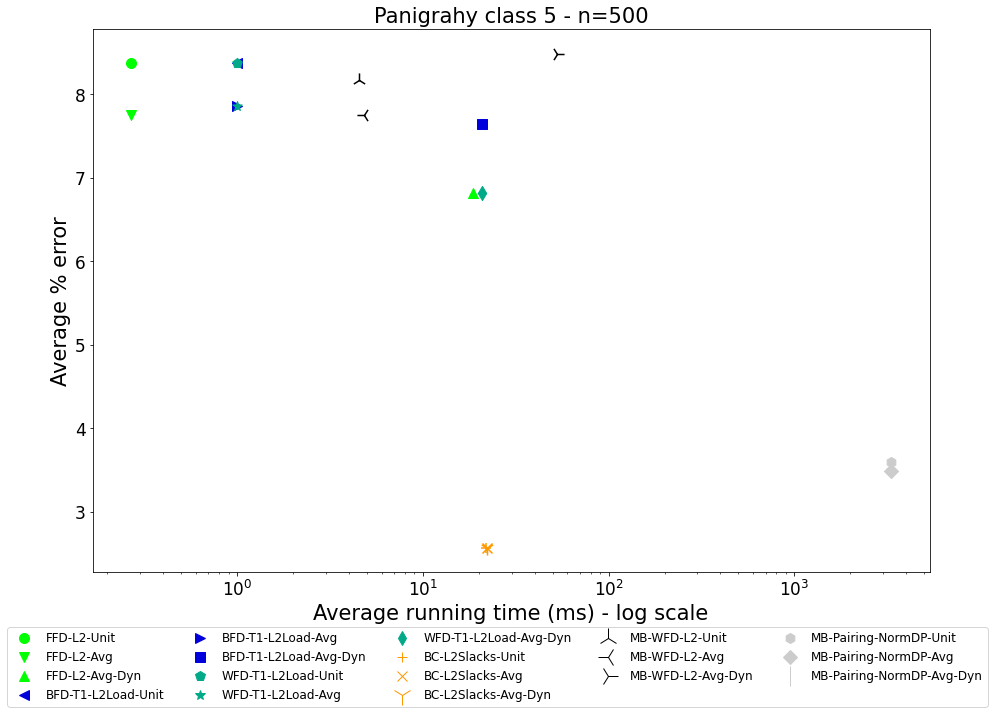

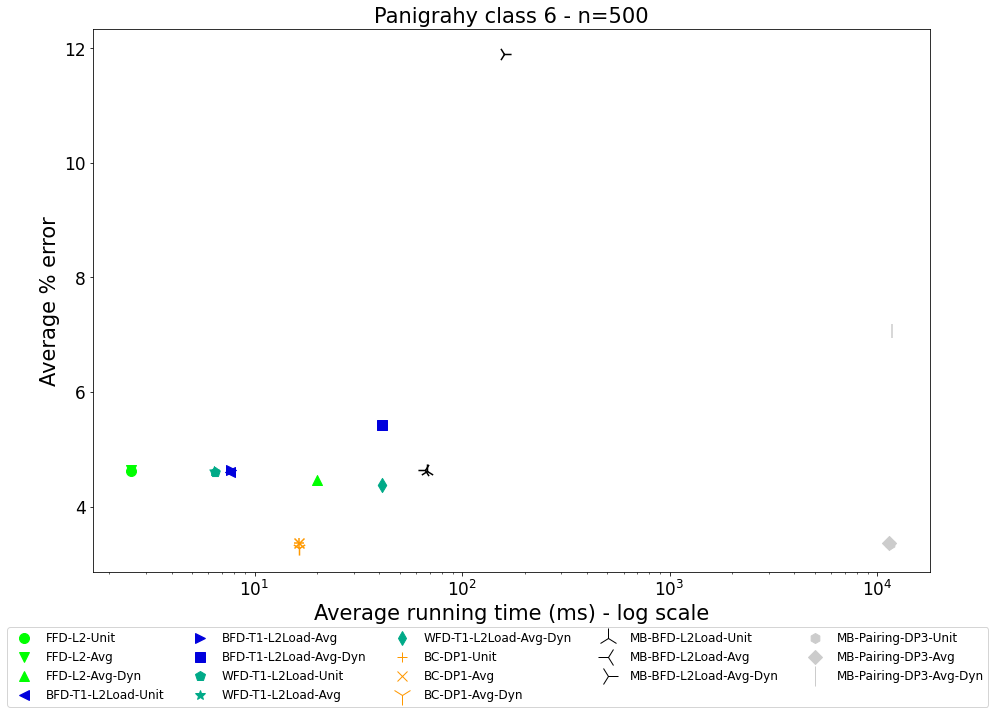

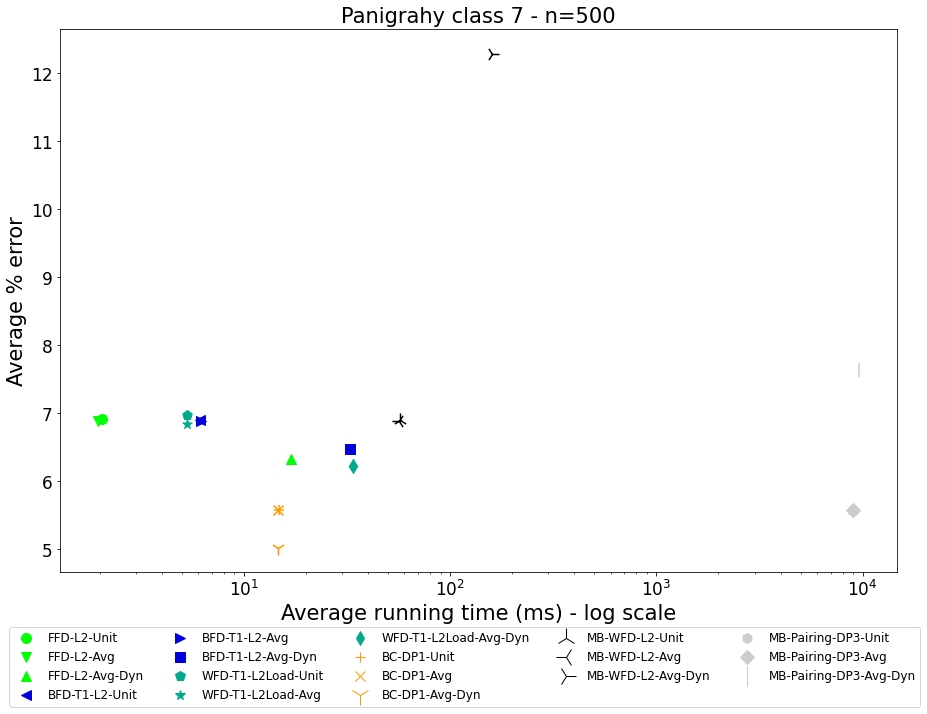

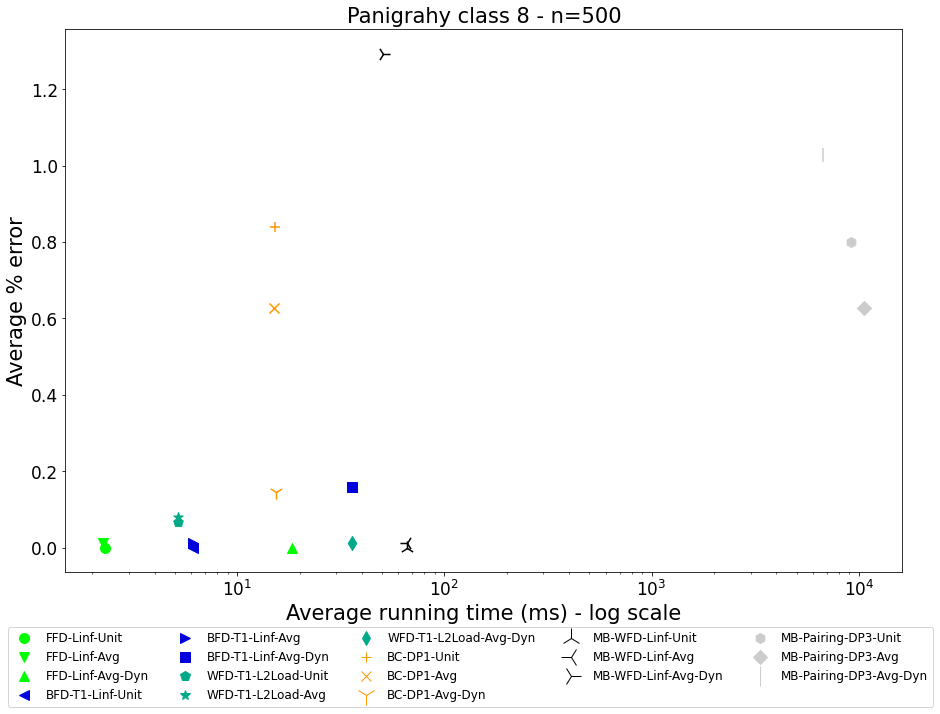

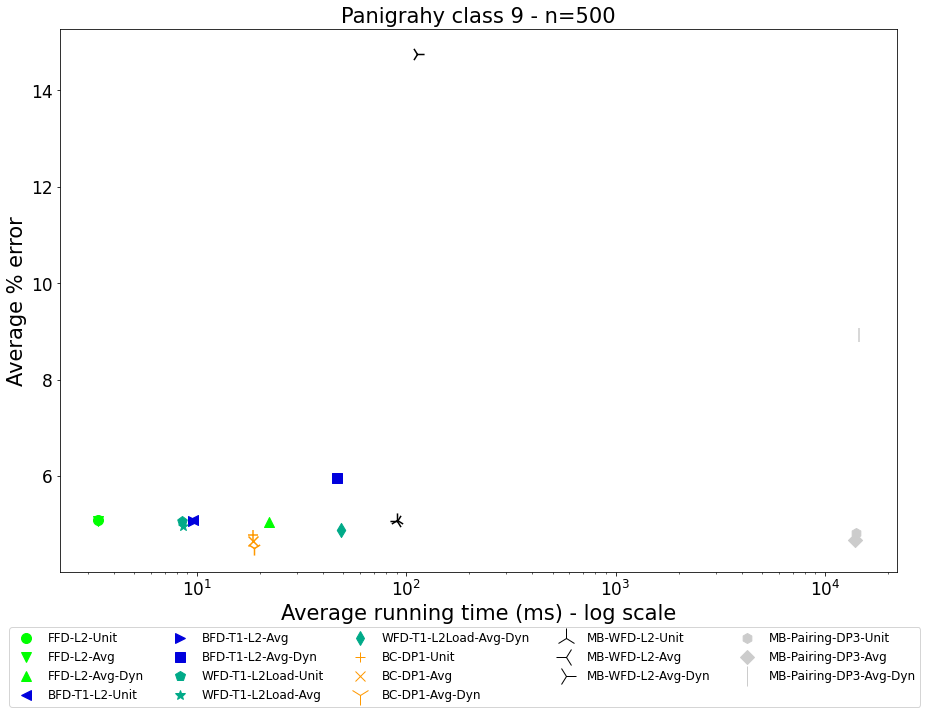

In [98]:
for c in range(1,10):
    fname = proj_path / f"plots/all_classes/avg_n500_P{c}.pdf"
    test_avg_P = augment_algo_list(create_selected_list(unit_results_P[0].loc[str(c)], avg_fam_dict, with_meta=False))
    plot_summary_family(big_results_P[1].loc[str(c),500], big_results_P[0].loc[str(c),500], test_avg_P,
            f"Panigrahy class {c} - n=500", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname, do_mean=True,
            bbox_anchor_y=-0.07, ncols=5, short_markers=True)

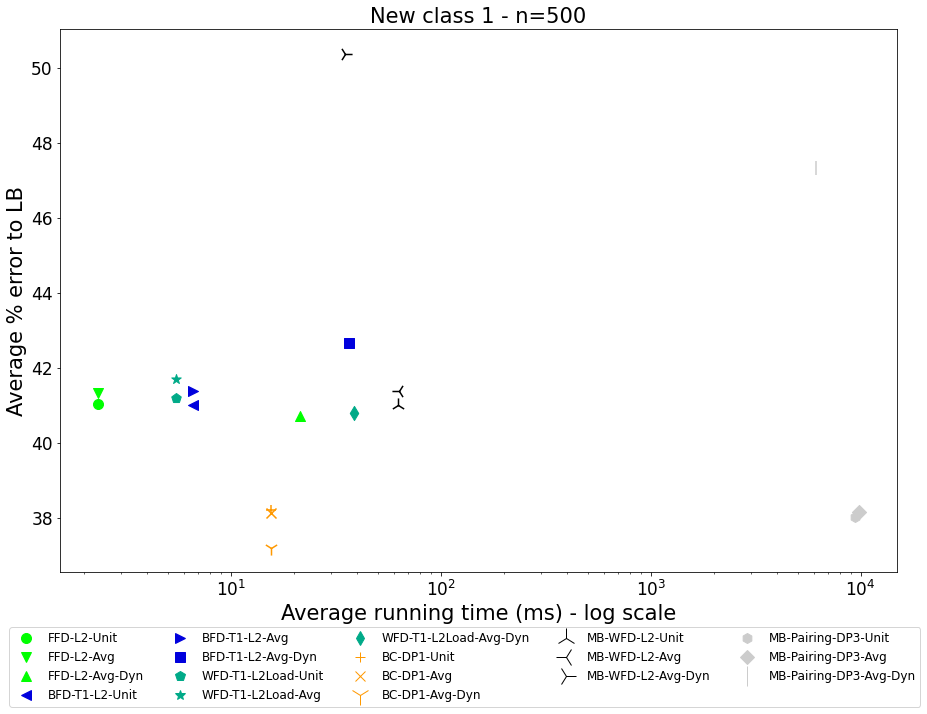

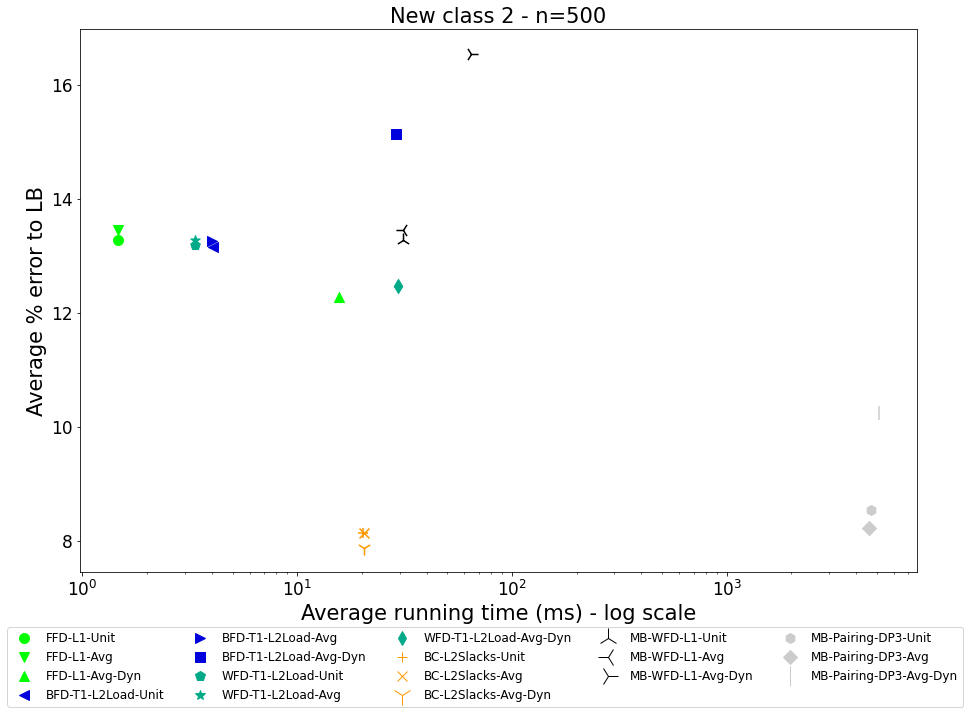

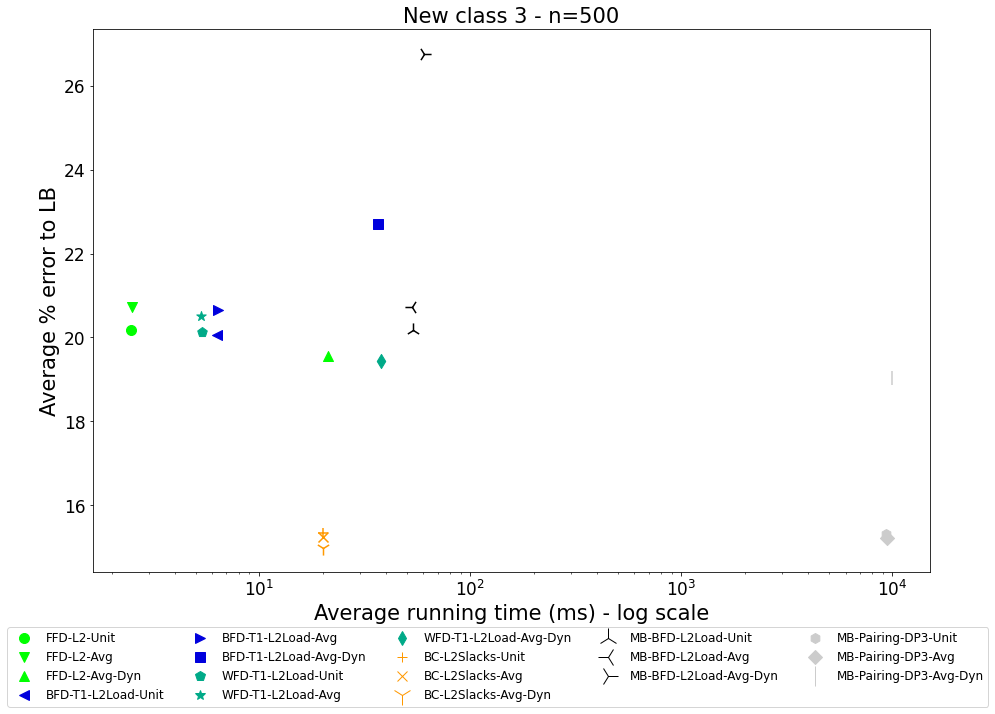

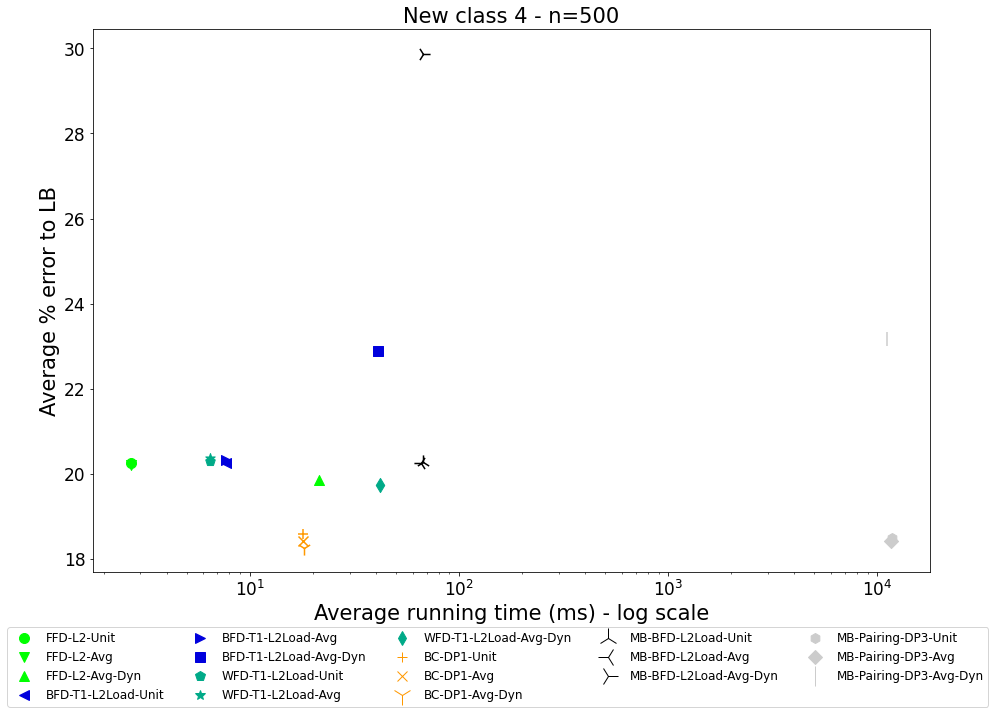

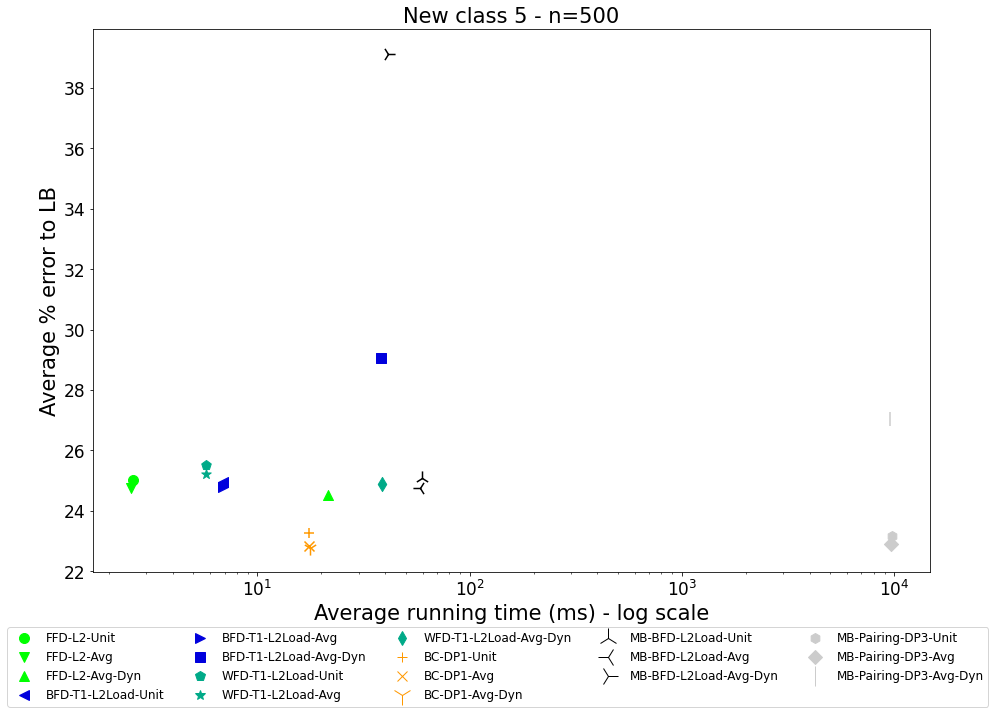

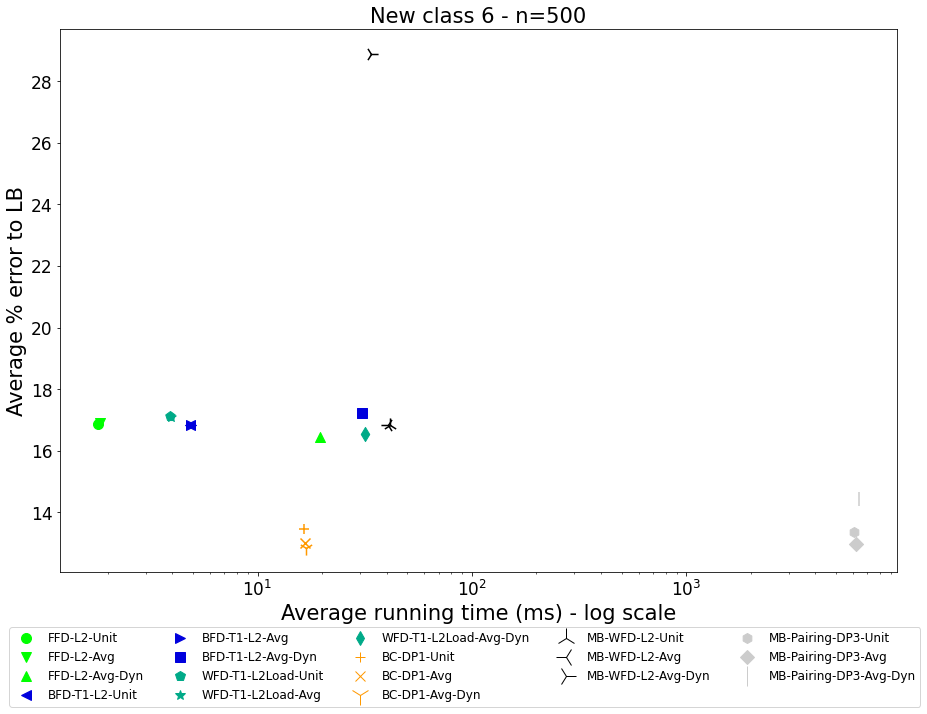

In [99]:
for c in range(1,7):
    fname = proj_path / f"plots/all_classes/avg_n500_I{c}.pdf"
    test_avg_I = augment_algo_list(create_selected_list(unit_results_I[0].loc[str(c)], avg_fam_dict, with_meta=False))
    plot_summary_family(big_results_I[1].loc[str(c),500], big_results_I[0].loc[str(c),500], test_avg_I,
            f"New class {c} - n=500", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname, do_mean=True,
            bbox_anchor_y=-0.07, ncols=5, short_markers=True)

In [100]:
for c in ["F", "C"]:
    fname = proj_path / f"plots/all_classes/avg_n501_T{c}.pdf"
    test_avg_T = augment_algo_list(create_selected_list(unit_results_T[0].loc[str(c)], avg_fam_dict, with_meta=False))
    plot_summary_family(big_results_T[1].loc[str(c),501], big_results_T[0].loc[str(c),501], test_avg_T,
            f"Triplet class {c} - n=501", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            bbox_anchor_y=-0.07, ncols=5, short_markers=True)

# Comparison with all algos and all weights

In [101]:
def add_meta_algos(df, alg_names):
    centric = [x for x in alg_names if not "MB-" in x]
    
    time_cols_centric = [i+'_timems' for i in centric]
    df['meta-centric'] = df[centric].min(axis=1)
    df['meta-centric_timems'] = df[time_cols_centric].sum(axis=1)
    
    time_cols_all = [i+'_timems' for i in alg_names]
    df['meta-all'] = df[alg_names].min(axis=1)
    df['meta-all_timems'] = df[time_cols_all].sum(axis=1)

In [102]:
add_meta_algos(df_P, all_algos)
add_meta_algos(df_I, all_algos)
add_meta_algos(df_T, all_algos)

In [103]:
algos_with_meta = all_algos + ["meta-centric", "meta-all"]

In [104]:
# Computing aggregated results once and for all
# For all Centric + Multibin algos
big_results_P = get_results(df_P, algos_with_meta, ['class', 'n', 'd'], group_as_index=True)
big_results_I = get_results(df_I, algos_with_meta, ['class', 'n', 'd'], group_as_index=True)
big_results_T = get_results(df_T, algos_with_meta, ['class', 'n', 'd'], group_as_index=True)

# results contains: eps, time, diff, diff_best, best, match_LB

In [105]:
it = [x for x in all_algos if "MB-" not in x and "BCS" not in x]
bi = [x for x in all_algos if "BCS" in x]
mb = [x for x in all_algos if "MB-" in x]

In [ ]:
print(len(all_algos), len(it), len(bi), len(mb))

In [ ]:
df = df_P
algs = all_algos

nb_instances = df.shape[0]
sub_list = algs.copy()
new_list = []
for i in range(len(algs)):
    algo_test = sub_list.pop(0)
    new_list.append(algo_test)
    # Find algos performing equally to algo_test
    counts = df[sub_list].apply(lambda x: x == df[algo_test]).sum()
    l = list(counts[counts == nb_instances].index)
    if (len(l) != 0):
        # If some are found, remove them from the sub_list
        print(f"{algo_test} identical to: {l}")
        sub_list = [x for x in sub_list if not x in l]
    if (len(sub_list) == 0):
        break
# Sub_list contains 'unique' algos
print(f"There are {len(new_list)} 'unique' algos")

In [106]:
to_remove = ['BCS-NormDP-Avg-Bin', 'MB-Pairing-DP1-UtilRatio',
             'MB-Pairing-NormDP-Avg', 'MB-Pairing-NormDP-Avg-Dyn',
             'MB-Pairing-DP3-UtilRatio',
             'MB-WFD-Linf-UtilRatio',
             'MB-WFD-L1-UtilRatio',
             'MB-WFD-L2-UtilRatio',
             'MB-BFD-L2Load-UtilRatio'
            ]
new_algos = [x for x in all_algos if not x in to_remove]

In [107]:
to_remove = ["BF-", "WF-"] # Need the dash after BF and WF to keep BFD/WFD
filtered_algos = filter_algo_list(new_algos, to_remove)

In [108]:
fam_dict = create_family_dict(filtered_algos)

## Plot lines %error as a function of n

For each class a selection of algorithms is made using 'create_selected_list'

In [109]:
simple_fam_dict = create_simple_family_dict(filtered_algos)
del simple_fam_dict["FF"]

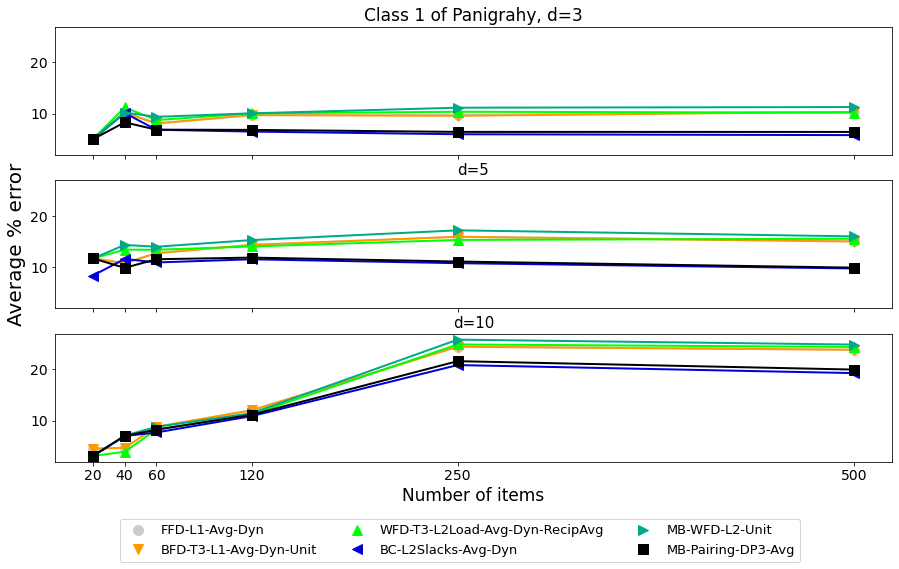

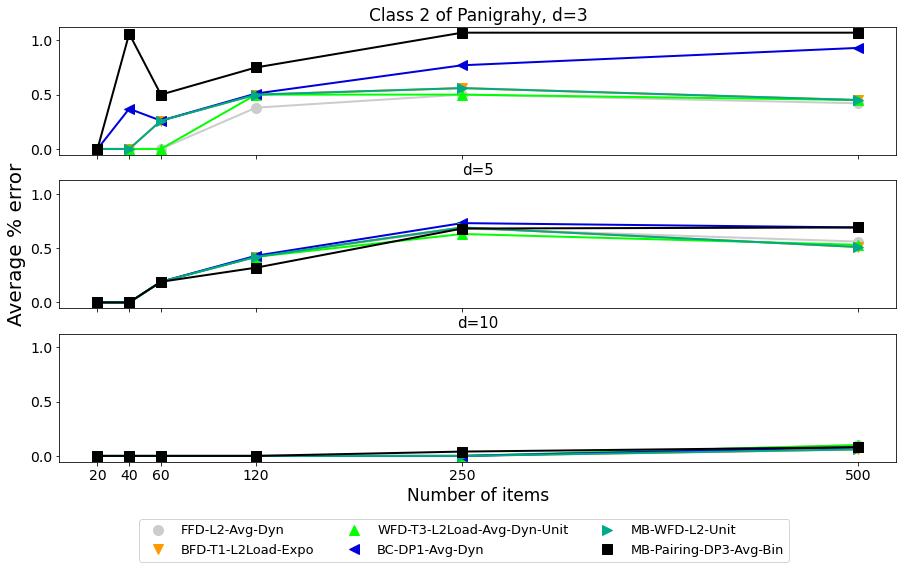

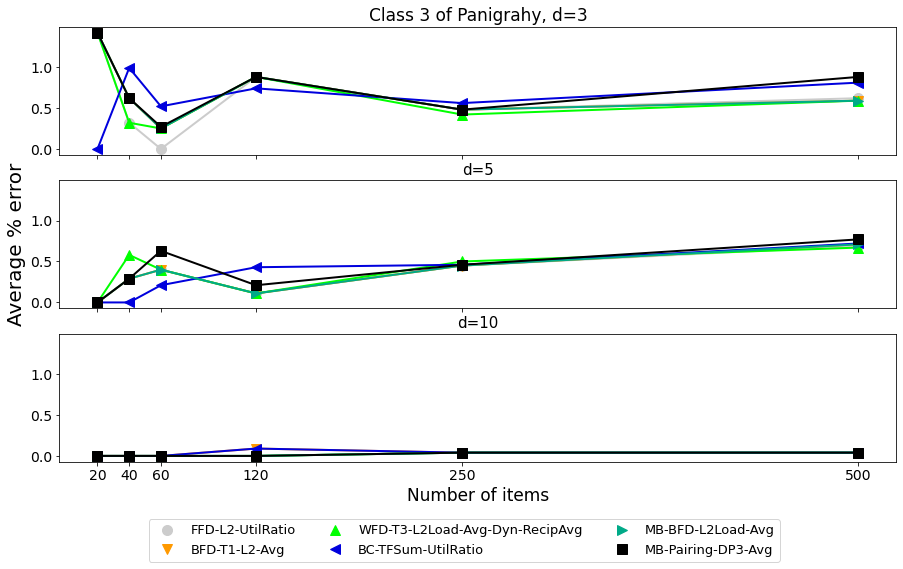

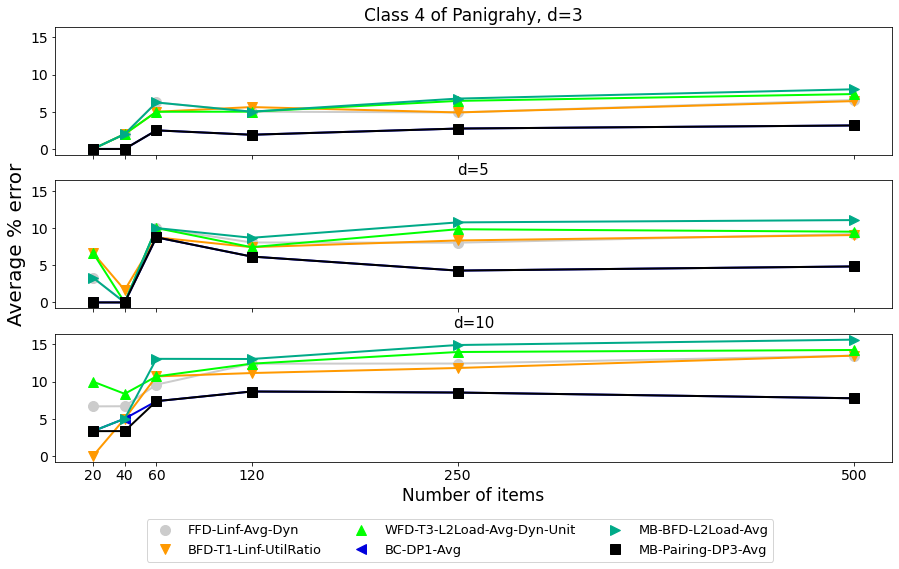

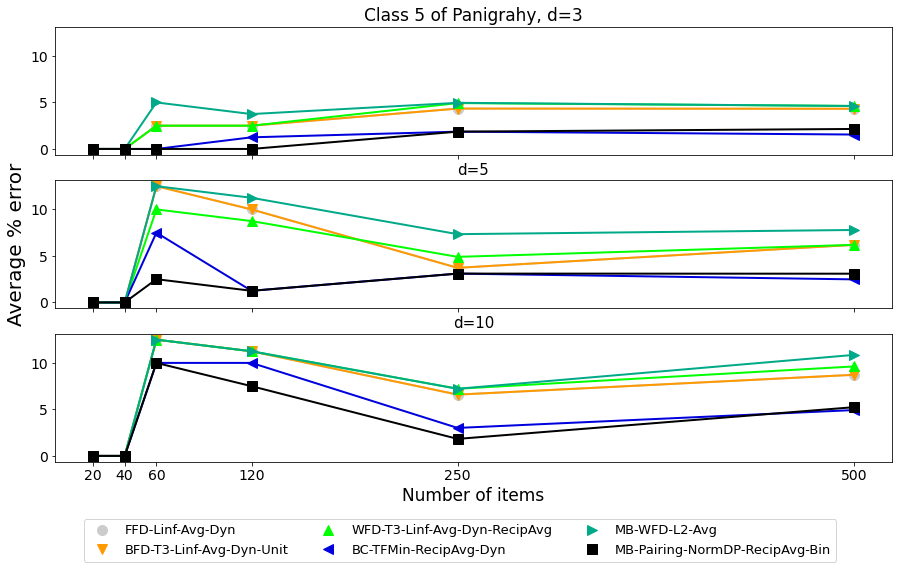

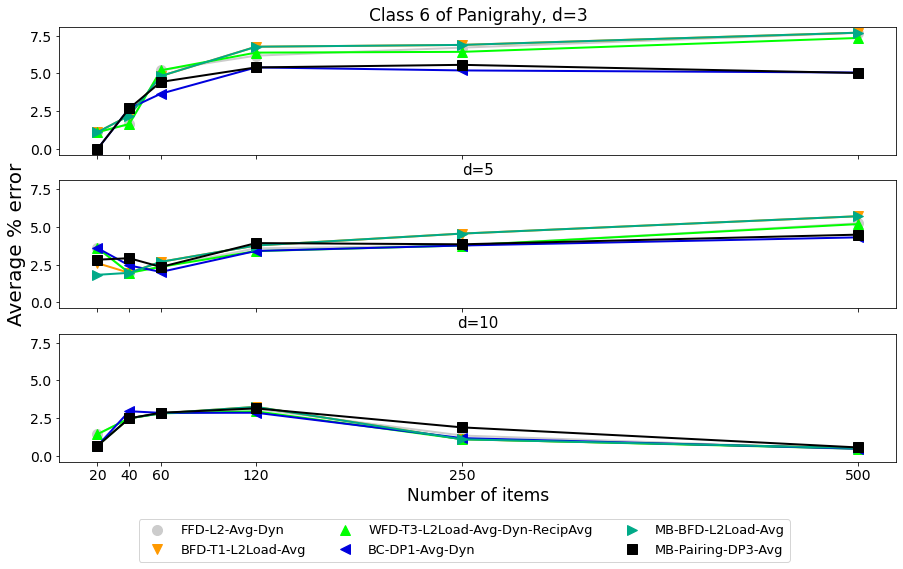

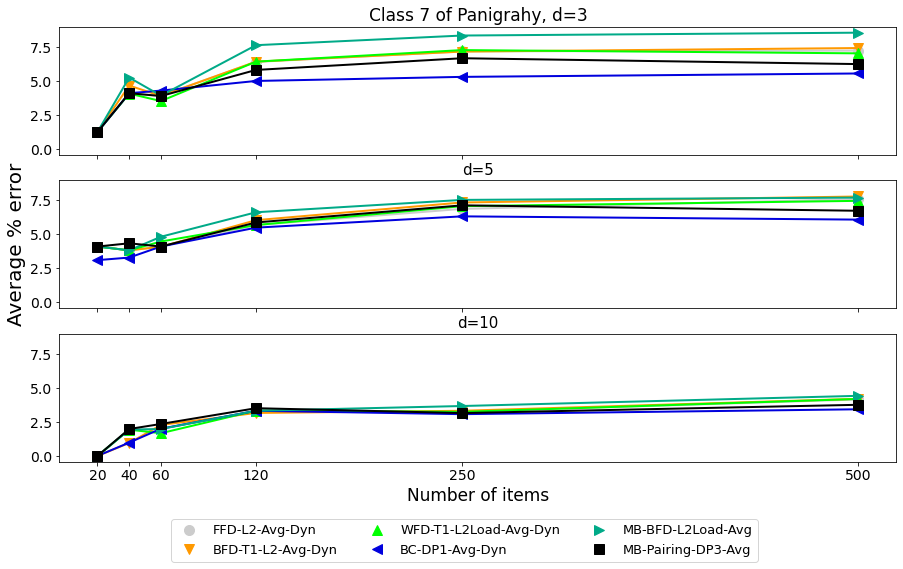

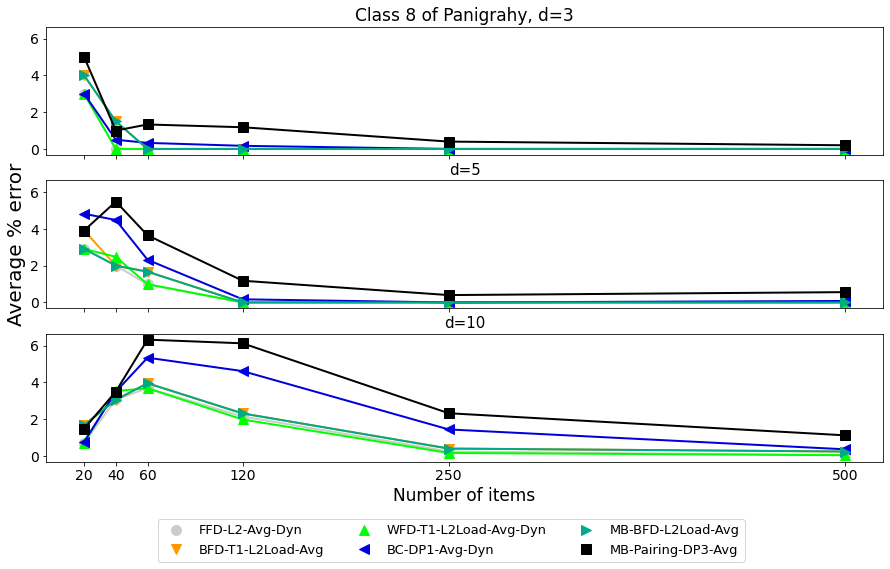

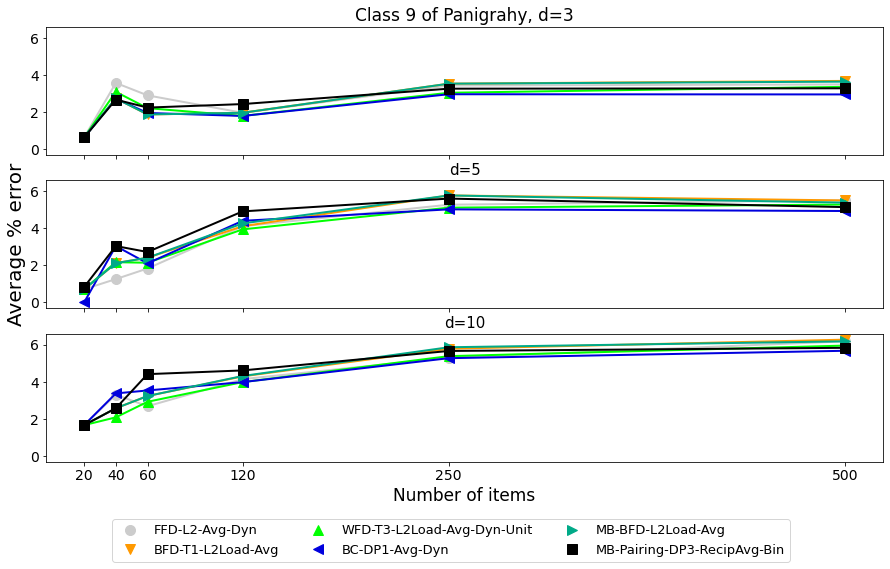

In [110]:
for c in range(1,10):
    fname = proj_path / f"plots/lines/all_lines_P{c}.pdf"
    sel_algos_test = create_selected_list(big_results_P[0].loc[str(c)], simple_fam_dict, with_meta=False)
    plot_n_eps([20, 40, 60, 120, 250, 500], big_results_P[0], str(c), sel_algos_test,
           f"Class {c} of Panigrahy", "Number of items", "Average % error",
           ncols=3, bbox_anchor=(0.5, -0.06), filename=fname)

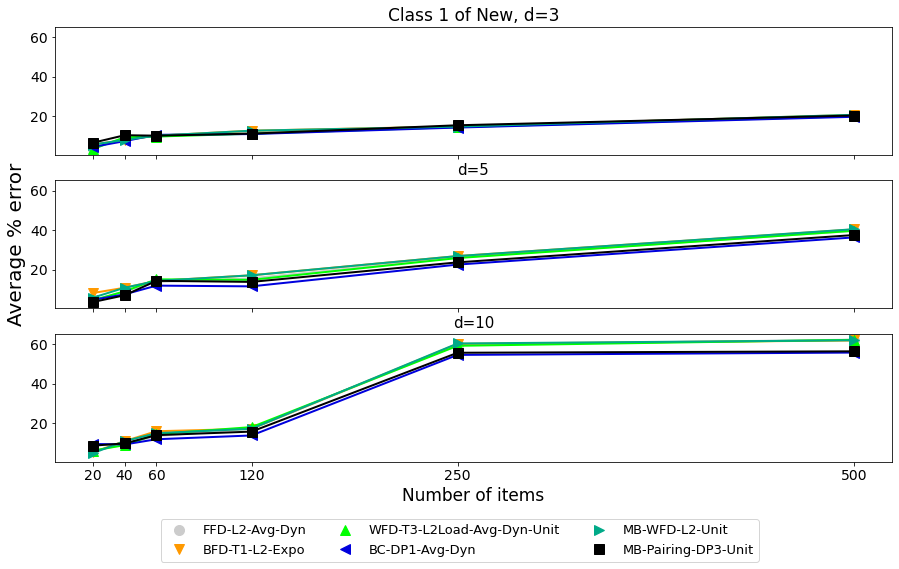

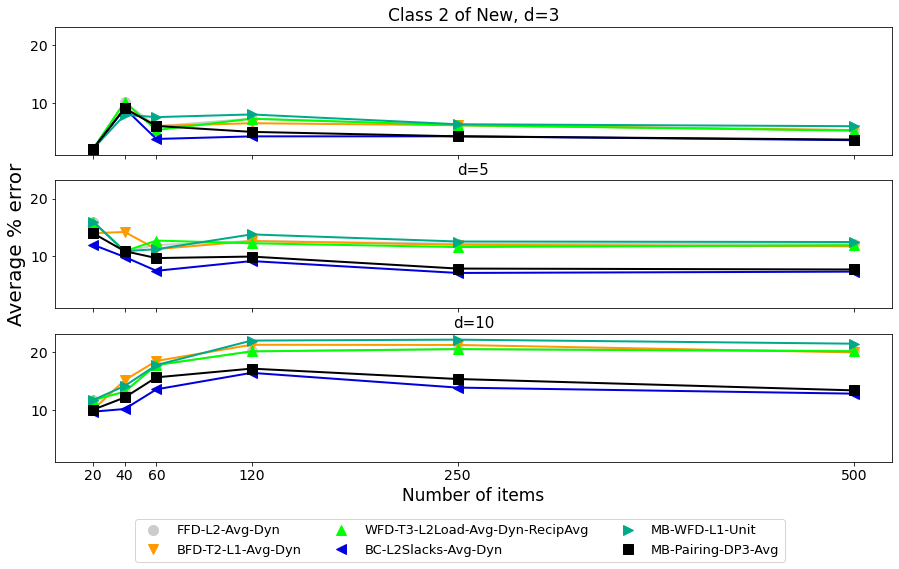

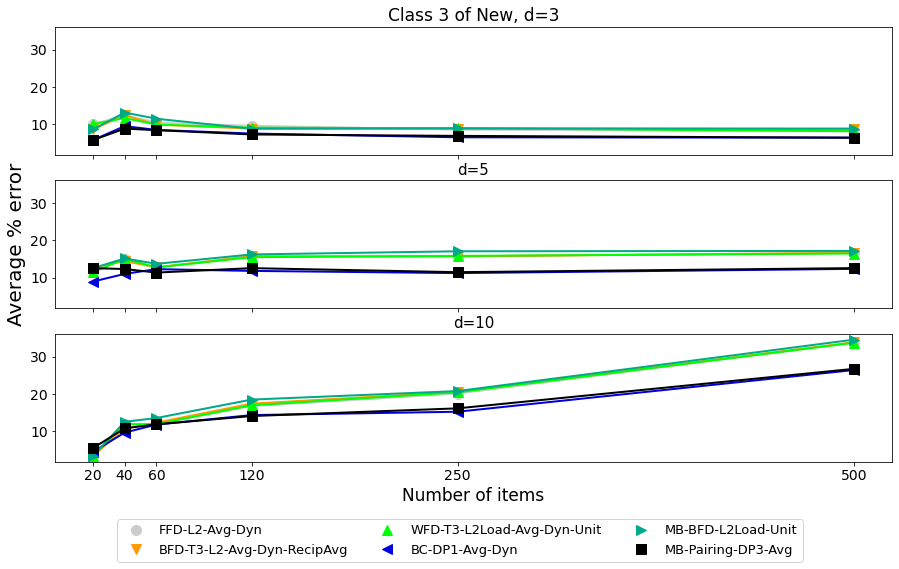

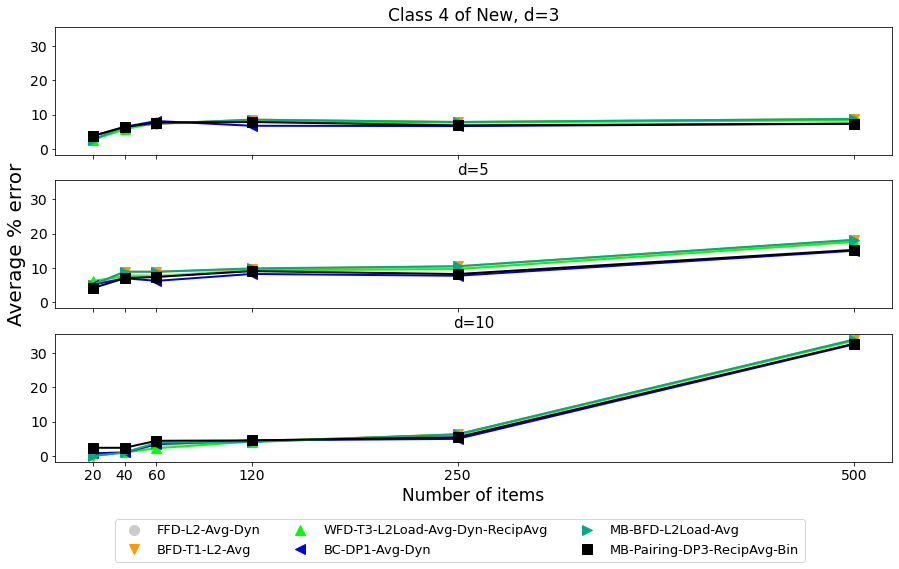

In [111]:
for c in range(1,7):
    fname = proj_path / f"plots/lines/all_lines_I{c}.pdf"
    sel_algos_test = create_selected_list(big_results_I[0].loc[str(c)], simple_fam_dict, with_meta=False)
    plot_n_eps([20, 40, 60, 120, 250, 500], big_results_I[0], str(c), sel_algos_test,
           f"Class {c} of New", "Number of items", "Average % error",
           ncols=3, bbox_anchor=(0.5, -0.06), filename=fname)

In [112]:
for c in ["F", "C"]:
    fname = proj_path / f"plots/lines/all_lines_T{c}.pdf"
    sel_algos_test = create_selected_list(big_results_T[0].loc[str(c)], simple_fam_dict, with_meta=False)
    plot_n_eps([60, 120, 249, 501], big_results_T[0], str(c), sel_algos_test,
           f"Class {c} of Triplet", "Number of items", "Average % error",
           ncols=3, bbox_anchor=(0.5, -0.06), filename=fname)

### Class P5

In [47]:
sel_algos_P5_bis = create_selected_list(big_results_P[0].loc["5"], fam_dict, with_meta=True)

In [48]:
big_results_P[0].loc["5",500,10][sel_algos_P5_bis]

FF                                11.48
FFD-L1-RecipAvg                   10.55
FFD-Linf-Avg-Dyn                   8.72
BFD-T1-L1-RecipAvg                10.55
BFD-T1-Linf-Avg-Dyn                8.72
BFD-T2-L1-RecipAvg                10.55
BFD-T2-Linf-Avg-Dyn                8.72
BFD-T3-L2-Avg-RecipAvg            11.17
BFD-T3-Linf-Avg-RecipAvg-Dyn       8.72
WFD-T1-L2Load-Avg                 11.17
WFD-T1-Linf-Avg-Dyn                9.63
WFD-T2-L2Load-Avg                 11.17
WFD-T2-Linf-Avg-Dyn                9.01
WFD-T3-L2Load-Avg-RecipAvg        11.17
WFD-T3-Linf-Avg-RecipAvg-Dyn       9.62
BC-TFMin-Expo                      5.24
BC-TFMin-RecipAvg-Dyn              4.93
BC-L2Norm-Avg-Bin                  4.31
MB-Pairing-NormDP-Unit             5.24
MB-Pairing-DP3-Avg-Dyn             4.00
MB-Pairing-NormDP-RecipAvg-Bin     5.24
MB-WFD-L2-Avg                     10.86
MB-WFD-L1-Expo-Dyn                11.48
meta-centric                       3.38
meta-all                           3.38


In [42]:
big_results_P[1].loc["5",500,10][sel_algos_P5_bis]

FF                                     0.2
FFD-L1-RecipAvg                        0.4
FFD-Linf-Avg-Dyn                      27.1
BFD-T1-L1-RecipAvg                     1.0
BFD-T1-Linf-Avg-Dyn                   30.3
BFD-T2-L1-RecipAvg                     3.0
BFD-T2-Linf-Avg-Dyn                   30.2
BFD-T3-L2-Avg-RecipAvg                 3.0
BFD-T3-Linf-Avg-RecipAvg-Dyn          30.2
WFD-T1-L2Load-Avg                      1.0
WFD-T1-Linf-Avg-Dyn                   29.8
WFD-T2-L2Load-Avg                      3.9
WFD-T2-Linf-Avg-Dyn                   29.9
WFD-T3-L2Load-Avg-RecipAvg             4.0
WFD-T3-Linf-Avg-RecipAvg-Dyn          30.1
BC-TFMin-Expo                         45.9
BC-TFMin-RecipAvg-Dyn                 46.0
BC-L2Norm-Avg-Bin                     34.7
MB-Pairing-NormDP-Unit              5357.5
MB-Pairing-DP3-Avg-Dyn              1293.7
MB-Pairing-NormDP-RecipAvg-Bin      5329.9
MB-WFD-L2-Avg                          6.0
MB-WFD-L1-Expo-Dyn                    61.9
meta-centri

In [103]:
sel_algos_P5 = create_selected_list(big_results_P[0].loc["5"], simple_fam_dict, with_meta=True)

In [104]:
big_results_P[0].loc["5", 500][sel_algos_P5]

FFD-Linf-Avg-Dyn  BFD-T3-Linf-Avg-Dyn-Unit  WFD-T3-Linf-Avg-Dyn-RecipAvg  \
d                                                                              
3               4.32                      4.32                          4.62   
5               6.19                      6.19                          6.19   
10              8.72                      8.72                          9.62   

    BC-TFMin-RecipAvg-Dyn  MB-Pairing-NormDP-RecipAvg-Bin  MB-WFD-L2-Avg  \
d                                                                          
3                    1.55                            2.15           4.62   
5                    2.48                            3.09           7.79   
10                   4.93                            5.24          10.86   

    meta-centric  meta-all  
d                           
3           0.93      0.93  
5           2.48      2.48  
10          3.38      3.38

In [105]:
eps_P5 = big_results_P[0].loc["5"][sel_algos_P5]
time_P5 = big_results_P[1].loc["5",500,:][sel_algos_P5]
idx_P5 = eps_P5[sel_algos_P5].mean().sort_values().index
for alg in idx_P5:
    print(f"{alg}\n\teps: {eps_P5[alg].mean():.2f}\n\ttime 500: {time_P5[alg].mean():.2f}\t{time_P5[alg].max()}")

meta-all
	eps: 1.21
	time 500: 83812.73	129235.6
meta-centric
	eps: 1.69
	time 500: 3618.37	5371.9
MB-Pairing-NormDP-RecipAvg-Bin
	eps: 2.14
	time 500: 3321.10	5329.9
BC-TFMin-RecipAvg-Dyn
	eps: 2.61
	time 500: 29.27	46.0
WFD-T3-Linf-Avg-Dyn-RecipAvg
	eps: 4.72
	time 500: 21.53	30.1
FFD-Linf-Avg-Dyn
	eps: 4.73
	time 500: 19.57	27.1
BFD-T3-Linf-Avg-Dyn-Unit
	eps: 4.73
	time 500: 21.60	30.0
MB-WFD-L2-Avg
	eps: 5.50
	time 500: 4.83	6.0


### Class P8

In [106]:
sel_algos_P8 = create_selected_list(big_results_P[0].loc["8"], simple_fam_dict, with_meta=True)

In [107]:
big_results_P[0].loc["8", 500][sel_algos_P8]

FFD-L2-Avg-Dyn  BFD-T1-L2Load-Avg  WFD-T1-L2Load-Avg-Dyn  BC-DP1-Avg-Dyn  \
d                                                                              
3             0.00               0.00                   0.00            0.00   
5             0.00               0.00                   0.00            0.08   
10            0.04               0.24                   0.04            0.36   

    MB-Pairing-DP3-Avg  MB-BFD-L2Load-Avg  meta-centric  meta-all  
d                                                                  
3                 0.20               0.00           0.0       0.0  
5                 0.56               0.00           0.0       0.0  
10                1.12               0.24           0.0       0.0

In [108]:
eps_P8 = big_results_P[0].loc["8"][sel_algos_P8]
time_P8 = big_results_P[1].loc["8",500,:][sel_algos_P8]
idx_P8 = eps_P8[sel_algos_P8].mean().sort_values().index
for alg in idx_P8:
    print(f"{alg}\n\teps: {eps_P8[alg].mean():.2f}\n\ttime 500: {time_P8[alg].mean():.2f}\t{time_P8[alg].max()}")

meta-centric
	eps: 0.16
	time 500: 5479.93	7353.5
meta-all
	eps: 0.16
	time 500: 494218.33	527520.2
FFD-L2-Avg-Dyn
	eps: 1.04
	time 500: 18.13	27.1
WFD-T1-L2Load-Avg-Dyn
	eps: 1.08
	time 500: 35.77	48.9
MB-BFD-L2Load-Avg
	eps: 1.32
	time 500: 59.73	65.1
BFD-T1-L2Load-Avg
	eps: 1.37
	time 500: 6.33	6.5
BC-DP1-Avg-Dyn
	eps: 1.77
	time 500: 15.43	21.6
MB-Pairing-DP3-Avg
	eps: 2.51
	time 500: 10622.20	14627.6


### Class I5

In [109]:
sel_algos_I5 = create_selected_list(big_results_I[0].loc["5"], simple_fam_dict, with_meta=True)

In [110]:
big_results_I[0].loc["5", 500][sel_algos_I5]

FFD-Linf-Avg-Dyn  BFD-T1-L2-Avg  WFD-T3-L2Load-Avg-Dyn-RecipAvg  \
d                                                                     
3               9.21           8.54                            8.47   
5              21.51          21.58                           21.38   
10             43.85          44.05                           44.19   

    BC-DP1-Avg-Dyn  MB-Pairing-DP3-Avg  MB-WFD-L2-Avg  meta-centric  meta-all  
d                                                                              
3             7.40                7.54           8.54          7.11      6.98  
5            19.00               18.99          21.58         18.56     18.56  
10           41.94               42.14          44.05         41.44     41.44

In [111]:
eps_I5 = big_results_I[0].loc["5"][sel_algos_I5]
time_I5 = big_results_I[1].loc["5",500,:][sel_algos_I5]
idx_I5 = eps_I5[sel_algos_I5].mean().sort_values().index
for alg in idx_I5:
    print(f"{alg}\n\teps: {eps_I5[alg].mean():.2f}\n\ttime 500: {time_I5[alg].mean():.2f}\t{time_I5[alg].max()}")

meta-all
	eps: 9.14
	time 500: 611212.53	885735.7
meta-centric
	eps: 9.16
	time 500: 5867.20	8355.1
BC-DP1-Avg-Dyn
	eps: 11.14
	time 500: 17.70	25.5
MB-Pairing-DP3-Avg
	eps: 11.17
	time 500: 9604.03	15301.5
FFD-Linf-Avg-Dyn
	eps: 11.57
	time 500: 21.90	30.7
MB-WFD-L2-Avg
	eps: 11.65
	time 500: 63.40	84.0
BFD-T1-L2-Avg
	eps: 11.71
	time 500: 6.87	8.4
WFD-T3-L2Load-Avg-Dyn-RecipAvg
	eps: 12.05
	time 500: 37.97	54.9


### Class TF

In [112]:
sel_algos_TF = create_selected_list(big_results_T[0].loc["F"], simple_fam_dict, with_meta=True)

In [113]:
big_results_T[0].loc["F", 501][sel_algos_TF]

FFD-L2-UtilRatio  BFD-T1-L1-UtilRatio  WFD-T1-L2Load-UtilRatio  \
d                                                                    
3              16.74                16.74                    16.74   
5              16.80                16.80                    16.80   
10             16.80                16.80                    16.80   

    BC-DP1-Unit  MB-Pairing-DP1-RecipAvg-Dyn  MB-WFD-L1-Unit  meta-centric  \
d                                                                            
3         16.62                         8.76           16.32         15.00   
5         16.80                        13.86           16.80         16.68   
10        16.80                        20.70           16.80         16.80   

    meta-all  
d             
3       8.34  
5      13.74  
10     16.80

In [114]:
eps_TF = big_results_T[0].loc["F"][sel_algos_TF]
time_TF = big_results_T[1].loc["F",501,:][sel_algos_TF]
idx_TF = eps_TF[sel_algos_TF].mean().sort_values().index
for alg in idx_TF:
    print(f"{alg}\n\teps: {eps_TF[alg].mean():.2f}\n\ttime 501: {time_TF[alg].mean():.2f}\t{time_TF[alg].max()}")

meta-all
	eps: 14.52
	time 501: 523823.90	692565.0
MB-Pairing-DP1-RecipAvg-Dyn
	eps: 16.48
	time 501: 10282.07	14158.3
meta-centric
	eps: 16.71
	time 501: 5830.13	8104.3
BFD-T1-L1-UtilRatio
	eps: 17.55
	time 501: 28.97	37.5
WFD-T1-L2Load-UtilRatio
	eps: 17.55
	time 501: 34.93	48.1
MB-WFD-L1-Unit
	eps: 17.56
	time 501: 47.80	58.2
FFD-L2-UtilRatio
	eps: 17.59
	time 501: 19.93	29.1
BC-DP1-Unit
	eps: 17.79
	time 501: 23.63	36.3


## Plot summary figures for all algos with n=500

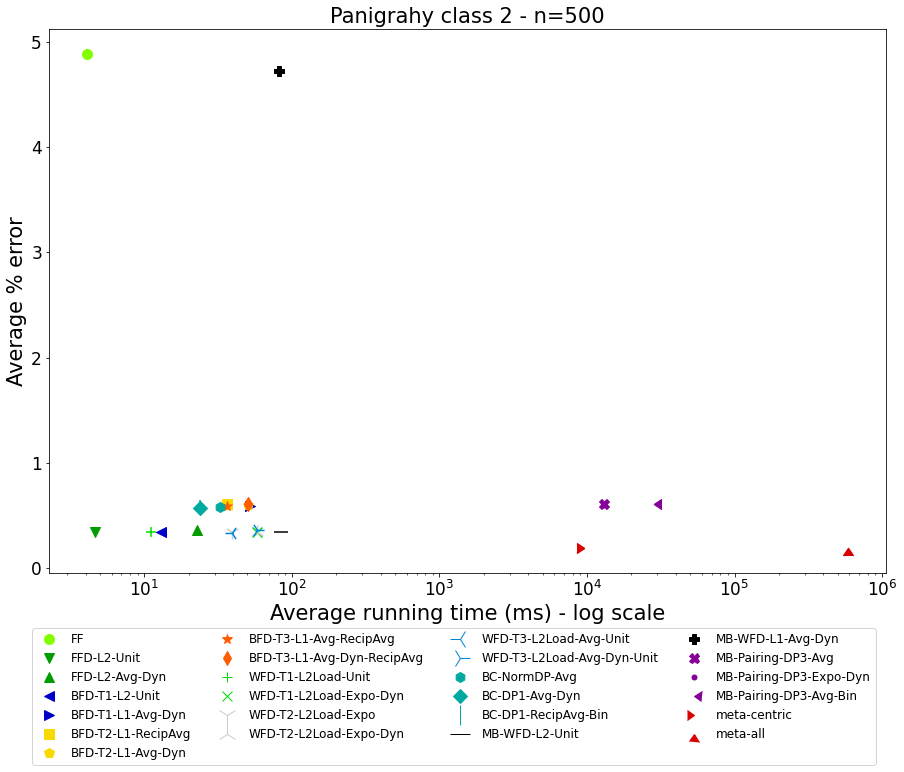

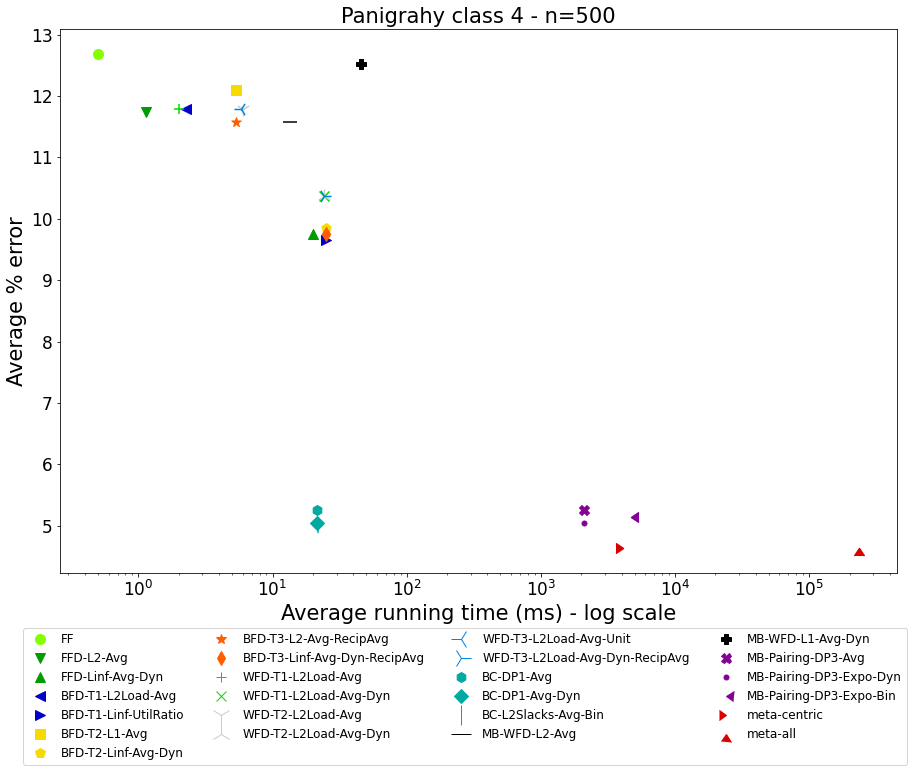

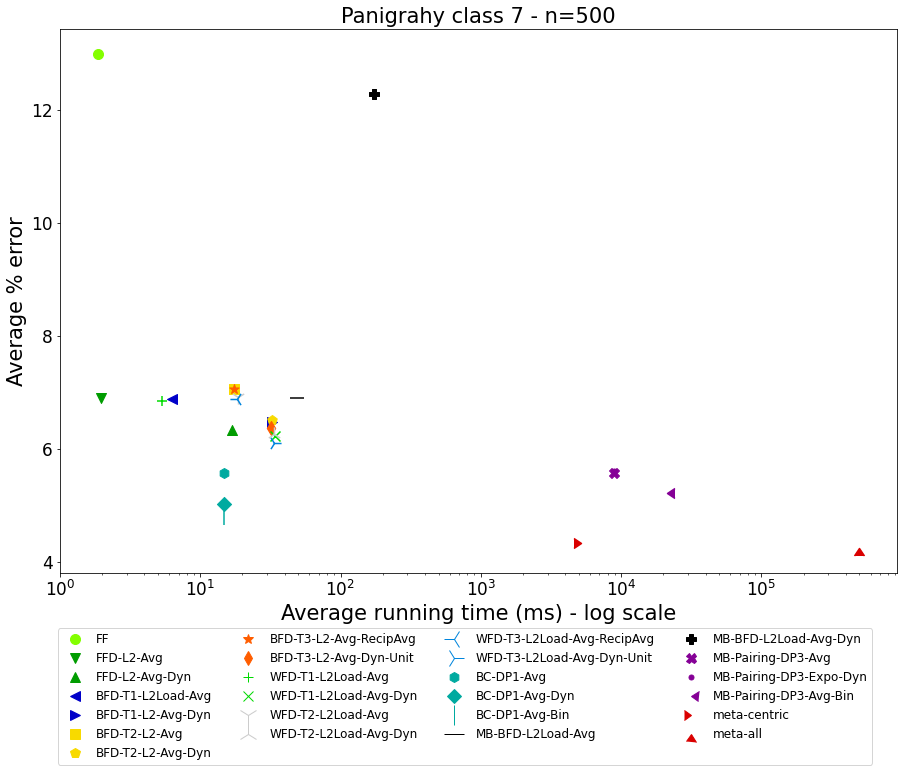

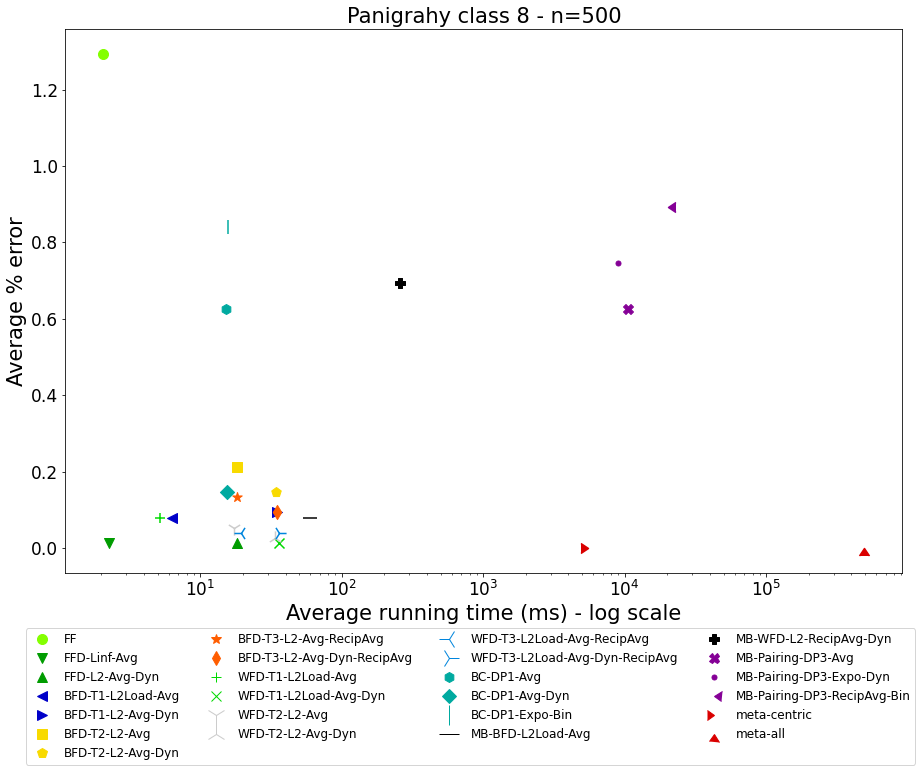

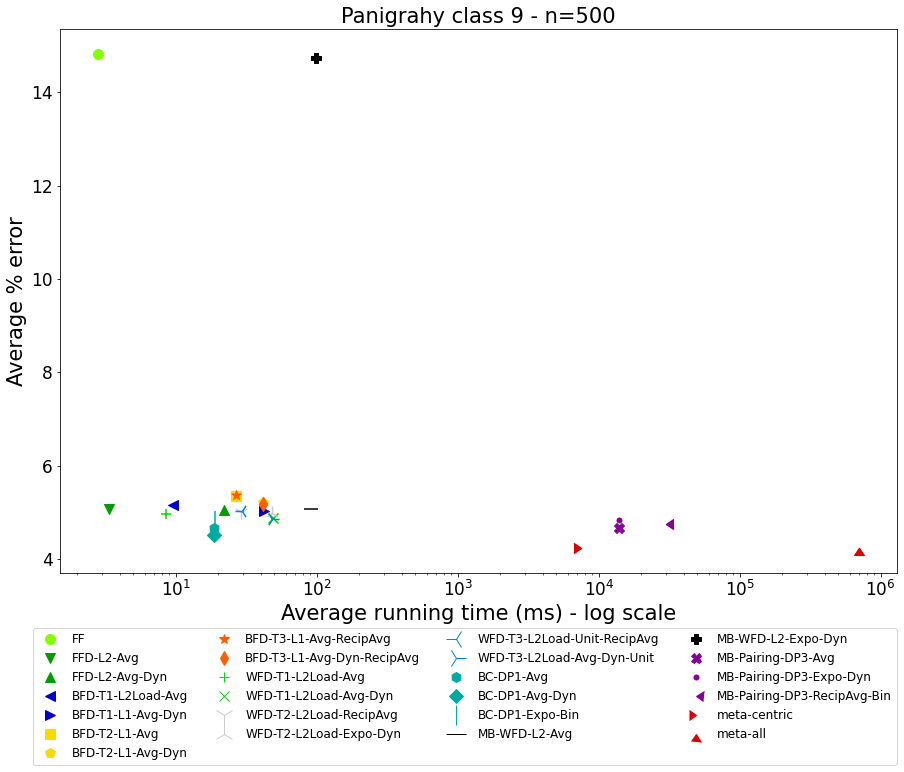

In [113]:
for c in range(1,10):
    fname = proj_path / f"plots/all_classes/all_weights_n500_P{c}.pdf"
    sel_algos = create_selected_list(big_results_P[0].loc[str(c)], fam_dict, with_meta=True)
    plot_summary_family(big_results_P[1].loc[str(c),500], big_results_P[0].loc[str(c),500], sel_algos,
            f"Panigrahy class {c} - n=500", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname,
            simplify_dict=True, show_legend=True,
            bbox_anchor=(0.5,-0.15), ncols=4, short_markers=True)

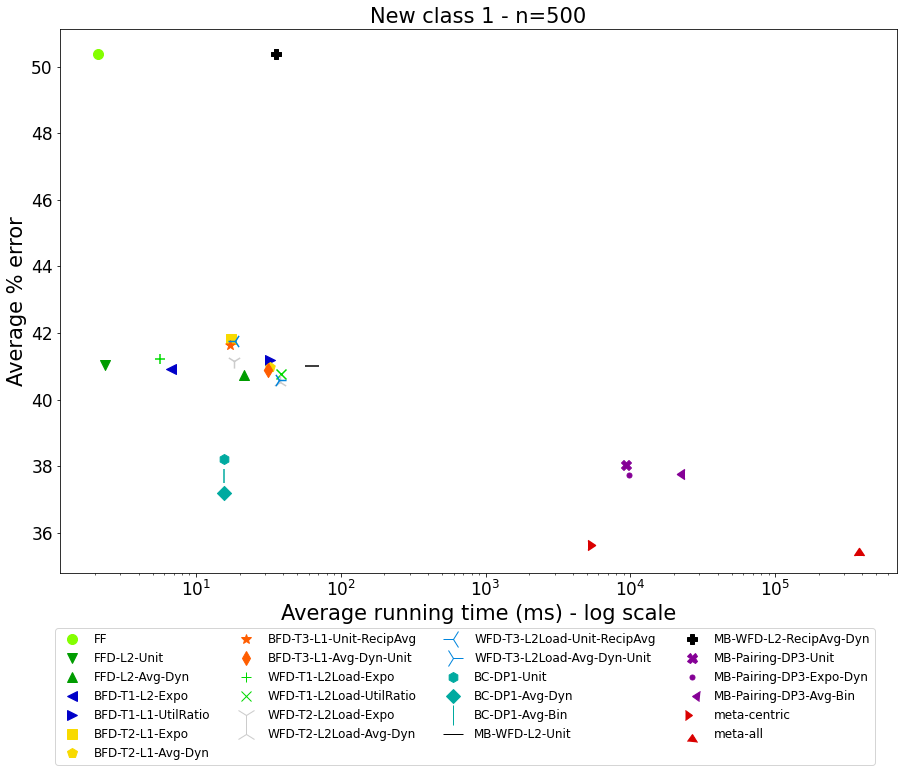

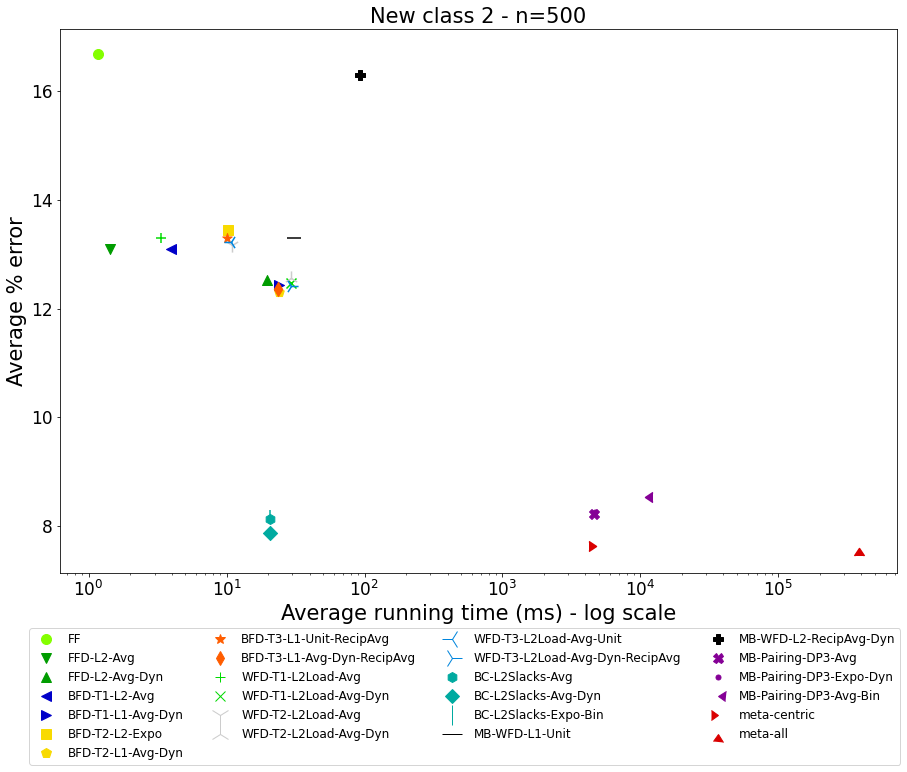

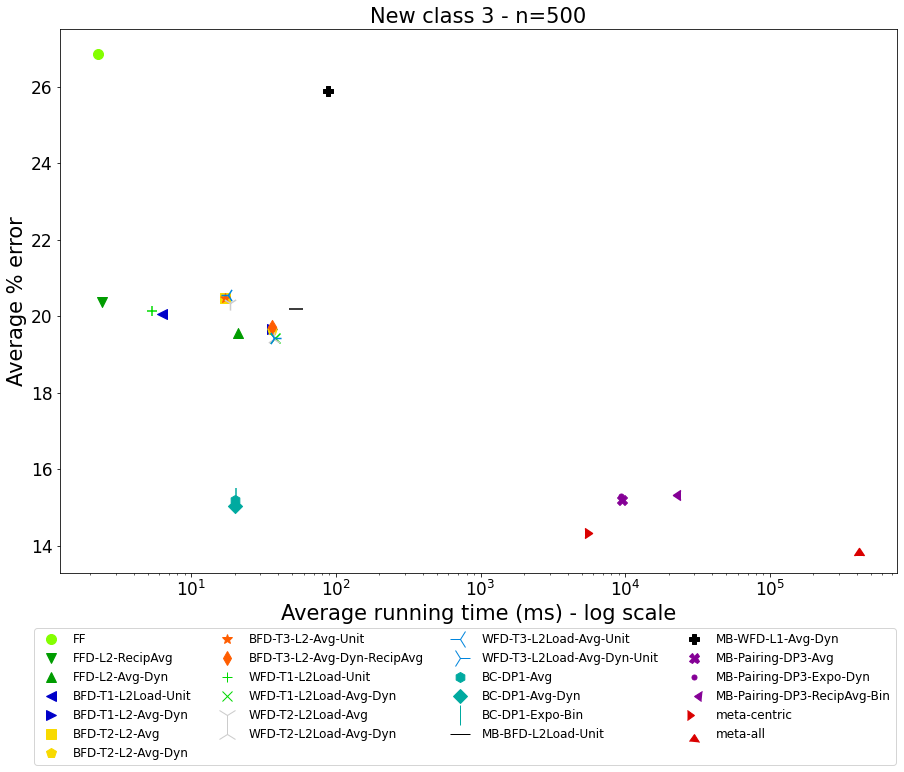

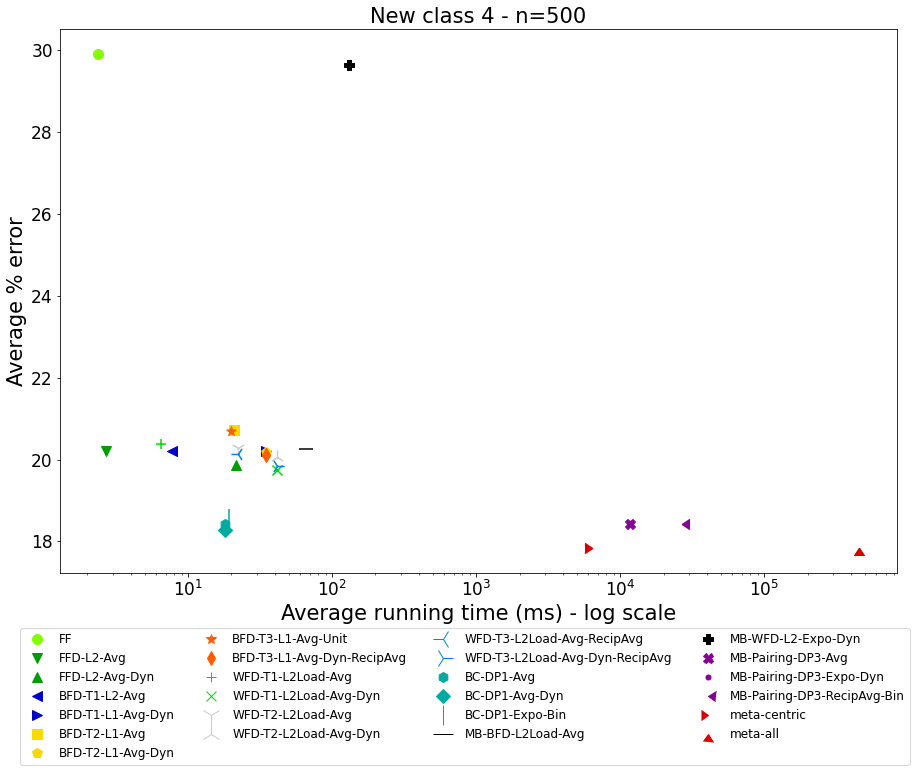

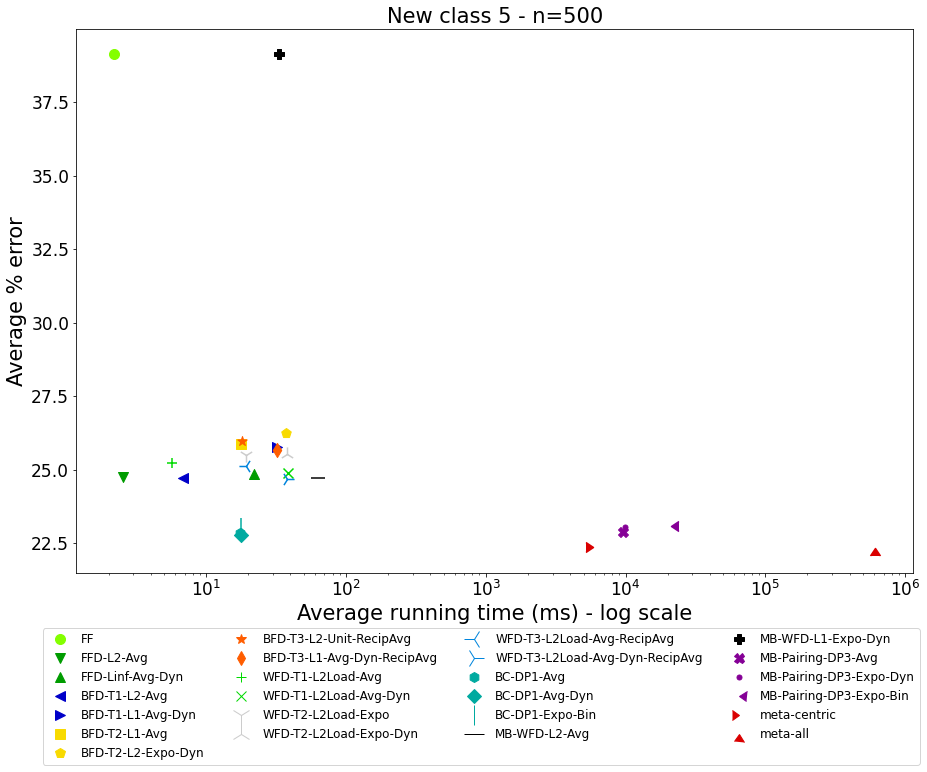

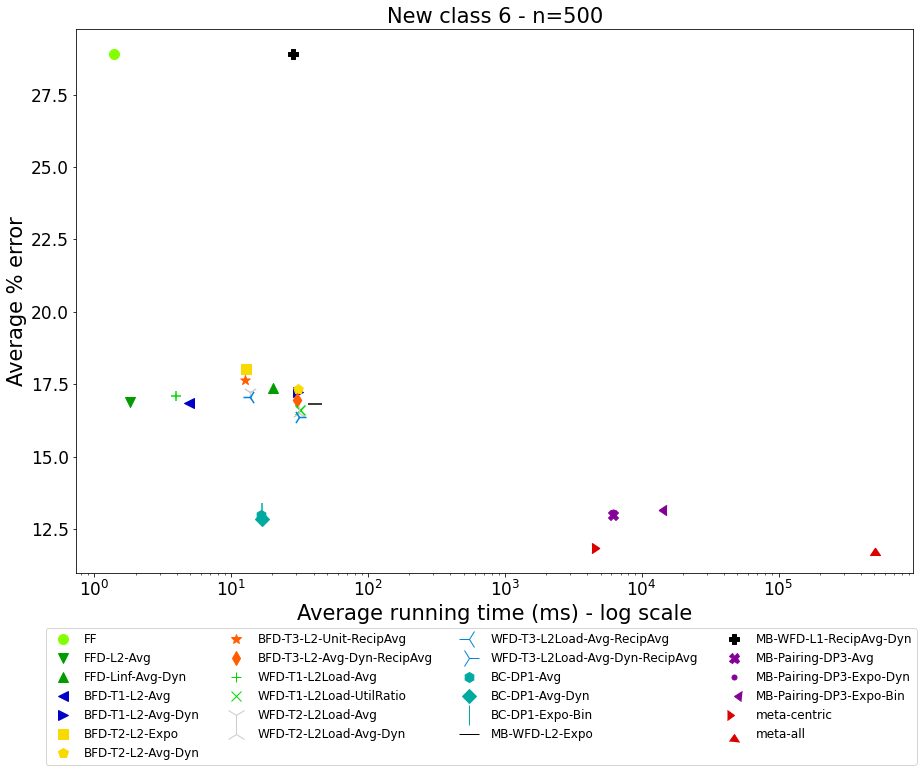

In [114]:
for c in range(1,7):
    fname = proj_path / f"plots/all_classes/all_weights_n500_I{c}.pdf"
    sel_algos = create_selected_list(big_results_I[0].loc[str(c)], fam_dict, with_meta=True)
    plot_summary_family(big_results_I[1].loc[str(c),500], big_results_I[0].loc[str(c),500], sel_algos,
            f"New class {c} - n=500", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname,
            simplify_dict=True, show_legend=True,
            bbox_anchor=(0.5,-0.15), ncols=4, short_markers=True)

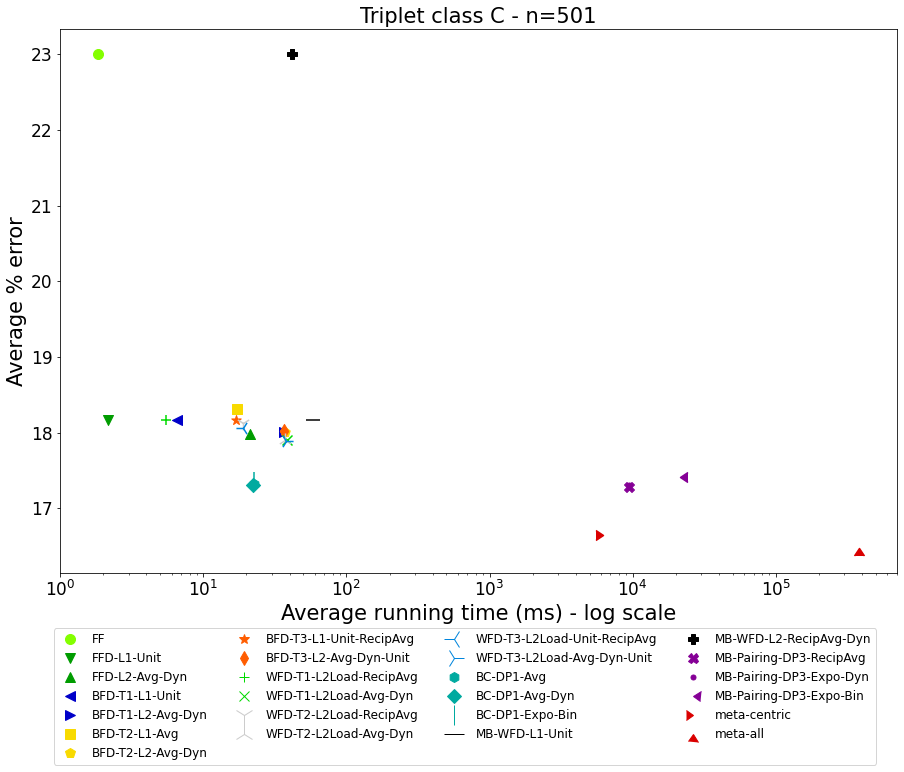

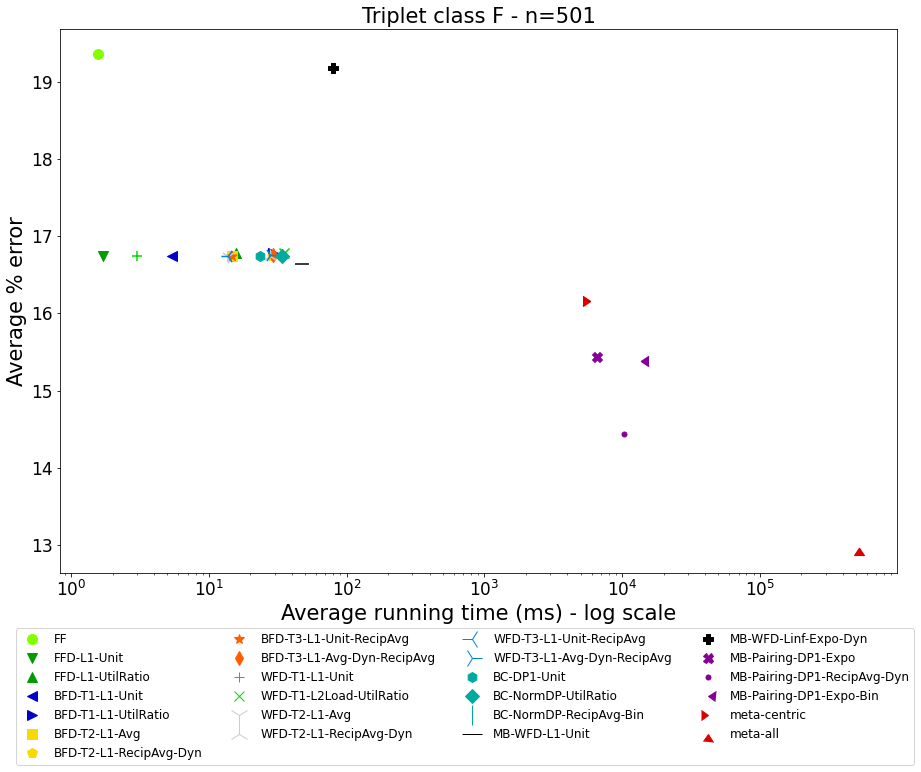

In [115]:
for c in ["C", "F"]:
    fname = proj_path / f"plots/all_classes/all_weights_n501_T{c}.pdf"
    sel_algos = create_selected_list(big_results_T[0].loc[str(c)], fam_dict, with_meta=True)
    plot_summary_family(big_results_T[1].loc[str(c),501], big_results_T[0].loc[str(c),501], sel_algos,
            f"Triplet class {c} - n=501", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname,
            simplify_dict=True, show_legend=True,
            bbox_anchor=(0.5,-0.15), ncols=4, short_markers=True)

## Plots of selected classes with specific n and d
### Class P5

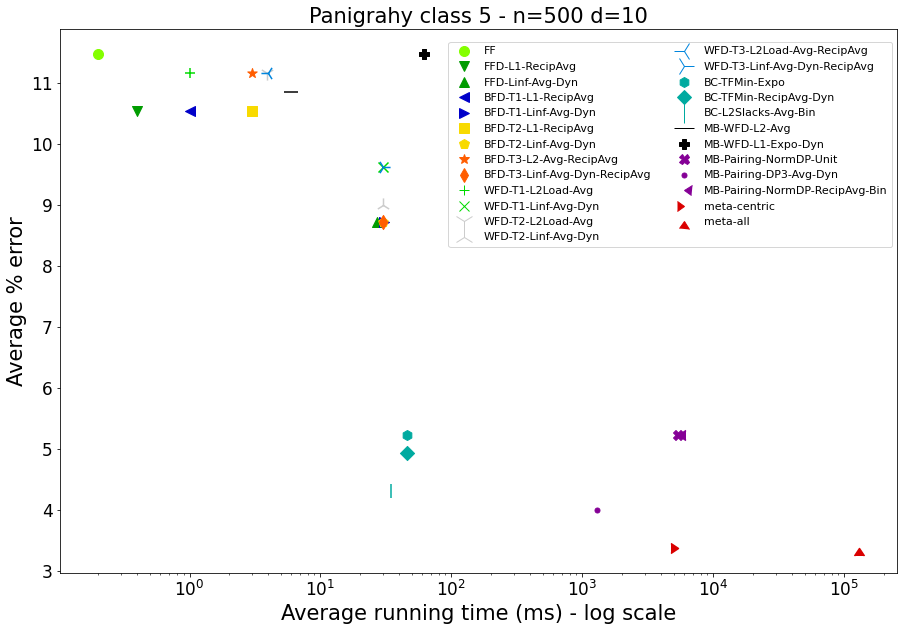

In [116]:
sel_algos_P5 = create_selected_list(big_results_P[0].loc["5"], fam_dict, with_meta=True)
fname = proj_path / "plots/all_n500d10_P5.pdf"
plot_summary_family(big_results_P[1].loc["5",500,10], big_results_P[0].loc["5",500,10], sel_algos_P5,
            "Panigrahy class 5 - n=500 d=10", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname, do_mean=False,
            simplify_dict=True, show_legend=True,
            ncols = 2, bbox_anchor=(0.69, 0.57),
            legend_size=FONT_SIZE-6, short_markers=True
            )

### Class P8

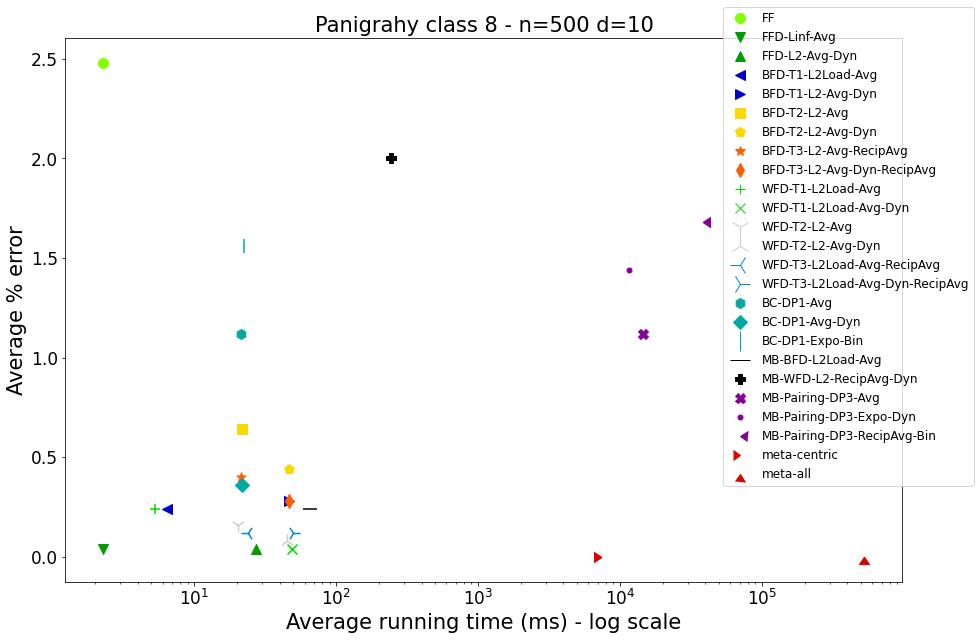

In [117]:
sel_algos_P8 = create_selected_list(big_results_P[0].loc["8"], fam_dict, with_meta=True)
fname = proj_path / "plots/all_n500d10_P8.pdf"
plot_summary_family(big_results_P[1].loc["8",500,10], big_results_P[0].loc["8",500,10], sel_algos_P8,
            "Panigrahy class 8 - n=500 d=10", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname, do_mean=False,
            simplify_dict=True, show_legend=True,
            #ncols = 2, bbox_anchor=(0.675, 0.54)
            ncols = 1, bbox_anchor=(0.85, 0.25), short_markers=True
        ####### legend VOLUNTARILY out of bound here BUT correctly placed in the output PDF
            )

### class I5

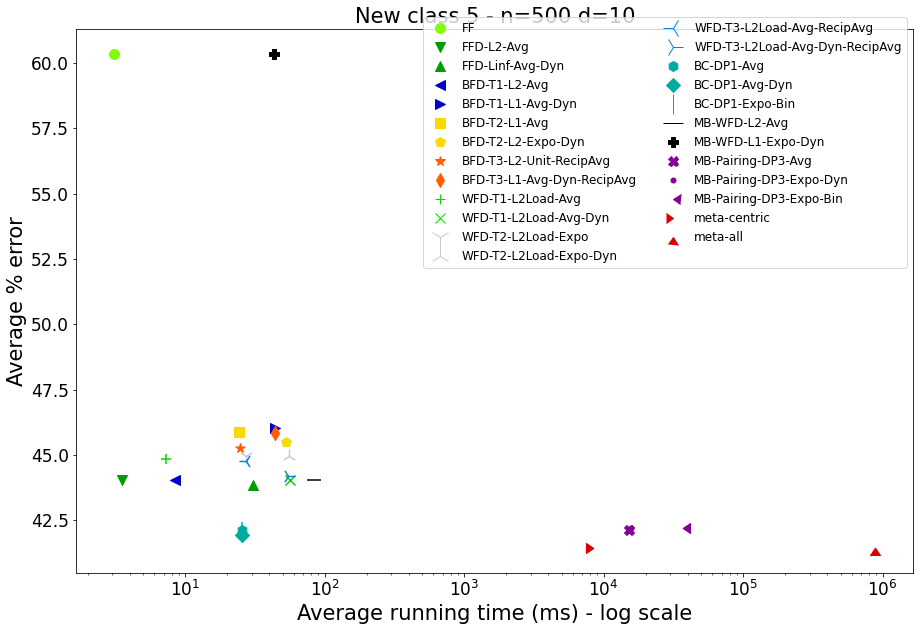

In [118]:
sel_algos_I5 = create_selected_list(big_results_I[0].loc["5"], fam_dict, with_meta=True)
fname = proj_path / "plots/all_n500d10_I5.pdf"
plot_summary_family(big_results_I[1].loc["5",500,10], big_results_I[0].loc["5",500,10], sel_algos_I5,
            "New class 5 - n=500 d=10", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname, do_mean=False,
            simplify_dict=True, show_legend=True,
            ncols = 2, bbox_anchor=(0.67, 0.54), short_markers=True
            ####### legend VOLUNTARILY out of bound here BUT correctly placed in the output PDF
            )

### class TF

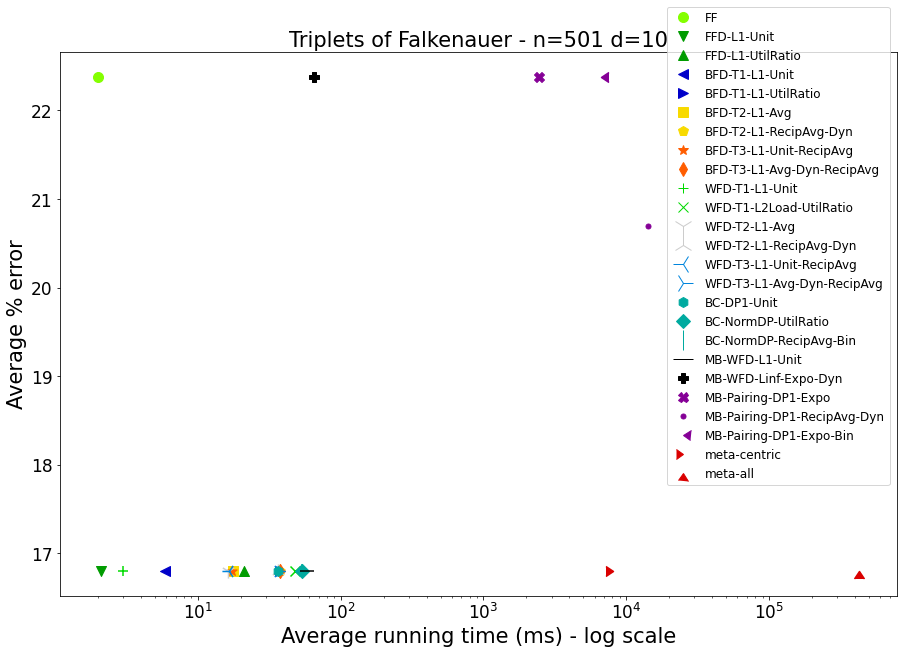

In [119]:
sel_algos_TF = create_selected_list(big_results_T[0].loc["F"], fam_dict, with_meta=True)
fname = proj_path / "plots/all_n501d10_TF.pdf"
plot_summary_family(big_results_T[1].loc["F",501,10], big_results_T[0].loc["F",501,10], sel_algos_TF,
            "Triplets of Falkenauer - n=501 d=10", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname, do_mean=False,
            simplify_dict=True, show_legend=True,
            ncols = 1, bbox_anchor=(0.79, 0.27), short_markers=True
            #ncols = 2, bbox_anchor=(0.34, 0.13)
            )

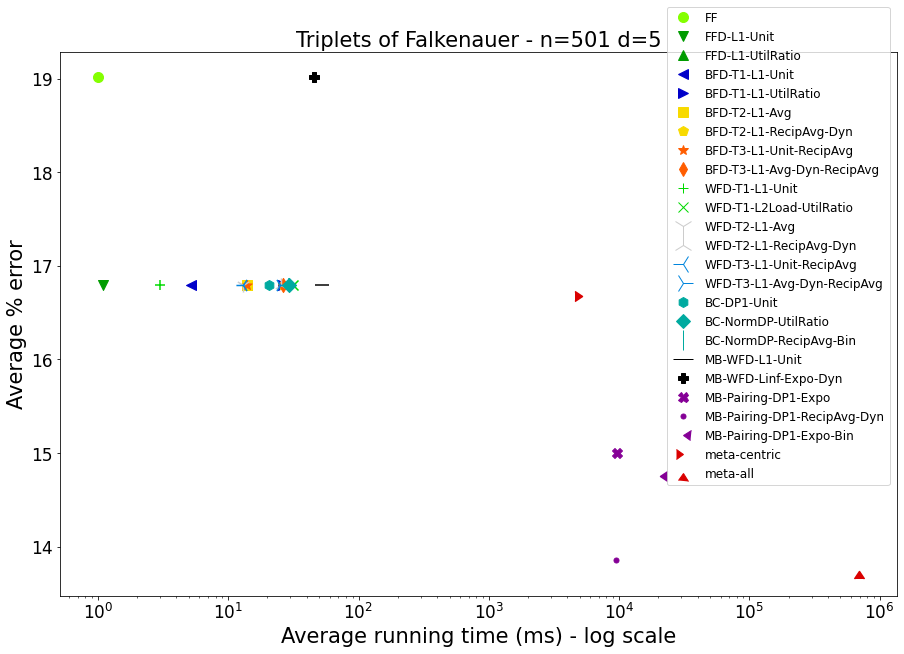

In [120]:
sel_algos_TF = create_selected_list(big_results_T[0].loc["F"], fam_dict, with_meta=True)
fname = proj_path / "plots/all_n501d5_TF.pdf"
plot_summary_family(big_results_T[1].loc["F",501,5], big_results_T[0].loc["F",501,5], sel_algos_TF,
            "Triplets of Falkenauer - n=501 d=5", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname, do_mean=False,
            simplify_dict=True, show_legend=True,
            ncols = 1, bbox_anchor=(0.79, 0.27), short_markers=True
            #ncols = 2, bbox_anchor=(0.34, 0.13)
            )

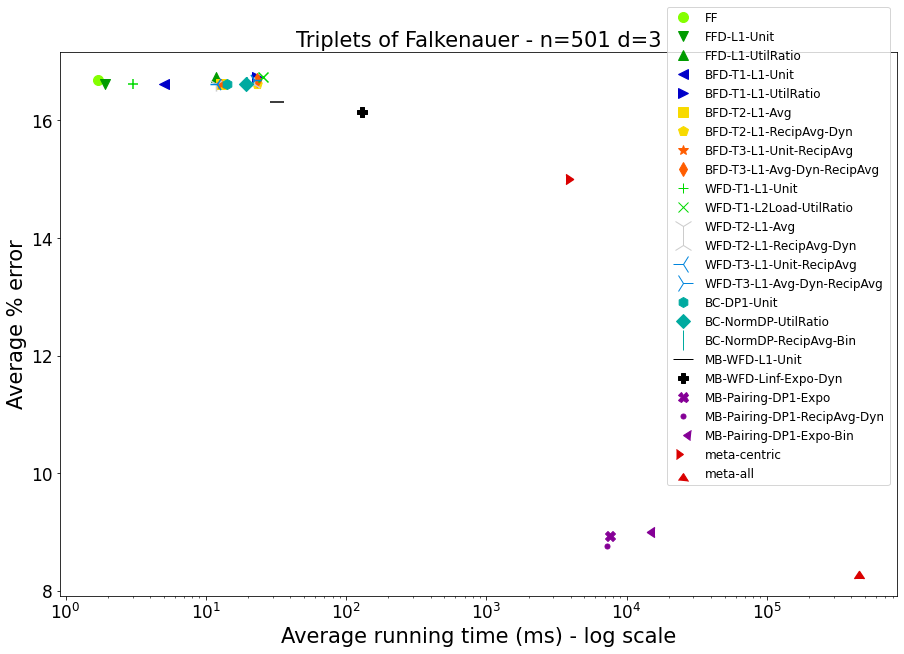

In [121]:
sel_algos_TF = create_selected_list(big_results_T[0].loc["F"], fam_dict, with_meta=True)
fname = proj_path / "plots/all_n501d3_TF.pdf"
plot_summary_family(big_results_T[1].loc["F",501,3], big_results_T[0].loc["F",501,3], sel_algos_TF,
            "Triplets of Falkenauer - n=501 d=3", "Average running time (ms) - log scale", "Average % error",
            log_scale=True, filename=fname, do_mean=False,
            simplify_dict=True, show_legend=True,
            ncols = 1, bbox_anchor=(0.79, 0.27), short_markers=True
            #ncols = 2, bbox_anchor=(0.34, 0.13)
            )

## Check optimal found with all algos and weights

In [126]:
print("--- For Panigrahy instances ---")
print_optimal_found(df_P, "P", all_algos)
print("\n--- For New instances ---")
print_optimal_found(df_I, "I", all_algos)
print("\n--- For Triplet instances ---")
print_optimal_found(df_T, "T", all_algos)

--- For Panigrahy instances ---
Total: 643 proved optimality over 1620 instances
Total: 992 optimal found over 1620 instances

--- For New instances ---
Total: 116 proved optimality over 1080 instances
Total: 260 optimal found over 1080 instances

--- For Triplet instances ---
Total: 0 proved optimality over 240 instances
Total: 0 optimal found over 240 instances


In [127]:
centric_algos = [x for x in all_algos if "MB-" not in x]

In [128]:
print("--- For Panigrahy instances ---")
print_optimal_found(df_P, "P", centric_algos)
print("\n--- For New instances ---")
print_optimal_found(df_I, "I", centric_algos)
print("\n--- For Triplet instances ---")
print_optimal_found(df_T, "T", centric_algos)

--- For Panigrahy instances ---
Total: 637 proved optimality over 1620 instances
Total: 985 optimal found over 1620 instances

--- For New instances ---
Total: 113 proved optimality over 1080 instances
Total: 257 optimal found over 1080 instances

--- For Triplet instances ---
Total: 0 proved optimality over 240 instances
Total: 0 optimal found over 240 instances


# Compute file with OPT and best known results

In [34]:
df_P, all_algos, multi_algos = load_df(file_P, with_classes=True)
df_I, _, _ = load_df(file_I, with_classes=True)
df_T, _, _ = load_df(file_T, with_classes=True)

print(f"Loaded {len(all_algos)} algos including {len(multi_algos)} MB algos!")

Loaded 351 algos including 76 MB algos!


In [35]:
algos_bc = [x for x in all_algos if x.startswith("BC-")]
algos_pairing = [x for x in all_algos if x.startswith("MB-Pairing-")]
algos_wfdm = [x for x in all_algos if x.startswith("MB-WFD-") or x.startswith("MB-BFD")]
algos_ic = [x for x in all_algos if not x in algos_bc and not x in algos_pairing and not x in algos_wfdm]

### For Panigrahy

In [49]:
file_P_OPT = proj_path / "Panigrahy_base_OPT.csv"
df_P_OPT = pd.read_csv(file_P_OPT, sep='\t', encoding='utf-8')

In [50]:
df_P_OPT["best_overall"] = df_P[all_algos].min(axis=1)
df_P_OPT["best_IC"] = df_P[algos_ic].min(axis=1)
df_P_OPT["best_BC"] = df_P[algos_bc].min(axis=1)
df_P_OPT["best_MB-Pairing"] = df_P[algos_pairing].min(axis=1)
df_P_OPT["best_MB-WFD"] = df_P[algos_wfdm].min(axis=1)

In [53]:
df_P_OPT.set_index("instance_name", inplace=True)
outfile_P = proj_path / "Panigrahy_summary_known.csv"
df_P_OPT.to_csv(outfile_P, sep='\t')

### For New

In [54]:
file_I_OPT = proj_path / "New_base_OPT.csv"
df_I_OPT = pd.read_csv(file_I_OPT, sep='\t', encoding='utf-8')

In [55]:
df_I_OPT["best_overall"] = df_I[all_algos].min(axis=1)
df_I_OPT["best_IC"] = df_I[algos_ic].min(axis=1)
df_I_OPT["best_BC"] = df_I[algos_bc].min(axis=1)
df_I_OPT["best_MB-Pairing"] = df_I[algos_pairing].min(axis=1)
df_I_OPT["best_MB-WFD"] = df_I[algos_wfdm].min(axis=1)

In [56]:
df_I_OPT.set_index("instance_name", inplace=True)
outfile_I = proj_path / "New_summary_known.csv"
df_I_OPT.to_csv(outfile_I, sep='\t')

### For Triplet

In [70]:
df_T_OPT = pd.read_csv(file_T, sep='\t', encoding='utf-8', usecols=['instance_name', 'LB'])

In [71]:
df_T_OPT["OPT"] = df_T_OPT["LB"]

In [72]:
df_T_OPT["best_overall"] = df_T[all_algos].min(axis=1)
df_T_OPT["best_IC"] = df_T[algos_ic].min(axis=1)
df_T_OPT["best_BC"] = df_T[algos_bc].min(axis=1)
df_T_OPT["best_MB-Pairing"] = df_T[algos_pairing].min(axis=1)
df_T_OPT["best_MB-WFD"] = df_T[algos_wfdm].min(axis=1)

In [74]:
df_T_OPT.set_index("instance_name", inplace=True)
outfile_T = proj_path / "Triplet_summary_known.csv"
df_T_OPT.to_csv(outfile_T, sep='\t')

# Compare several algorithms

In [ ]:
def my_sup(x):
    return x[x > 0].count()

def my_eq(x):
    return x[x == 0].count()

def my_low(x):
    return x[x < 0].count()

def make_diff(df, list1, list2):
    a = df[list1]
    b = df[list2]
    b.columns = a.columns
    df_diff = (a - b).agg(['mean', 'std', my_sup, my_eq, my_low])
    return df_diff

def make_diff_classes(algo1, algo2, base_df, bench_name):
    if bench_name == "P":
        l = range(1,10)
    elif bench_name == "I":
        l = range(1,7)
    else:
        l = ["C", "F"]
        
    dfs = []
    cols = []
    for c in l:
        dfs.append(make_diff(base_df[base_df["class"] ==str(c)], [algo1], [algo2]))
        cols.append(f"{algo1}_{c}")
    
    diff_df = pd.concat(dfs, axis=1)
    diff_df.columns = cols
    return diff_df

# When comparing algo A with algo B
# Mean is negative when algo A is better than B
# my_sup counts when sol of A is worse than B
# my_low counts when sol of A is better than B

In [ ]:
alA = "FFD-Sum-Avg"
alB = "FFD-SumSq-Avg"
df_diff = make_diff_classes(alA, alB, big_df_P, "P")
print(df_diff)

In [ ]:
df_diff = make_diff_classes(alA, alB, big_df_I, "I")
print(df_diff)

In [ ]:
df_diff = make_diff_classes("BCS-DP1-Expo", "BCS-DP2-Avg-Dyn", big_df_P, "P")
print(df_diff)

In [ ]:
df_diff = make_diff_classes("BIM-BS-DP3-Avg", "BIM-BS-DP1-DivAvg-Dyn", big_df_T, "T")
print(df_diff)

In [ ]:
df_diff = make_diff_classes("FFD-Sum-Avg-Dyn", "WFD-T1-SumSqLoad-Avg-Dyn", big_df_P, "P")
print(df_diff)

In [ ]:
df_diff = make_diff(big_df_P, ["FFD-SumSq-Unit", "FFD-Sum-Unit"],["FFD-SumSq-Avg", "FFD-Sum-Avg"])
print(df_diff)

In [ ]:
df_diff = make_all_diff(["FFD-SumSq-Unit", "FFD-Sum-Unit"],
                        ["FFD-SumSq-Avg", "FFD-Sum-Avg"])
df_diff

In [ ]:
df_diff = make_all_diff(["FFD-SumSq-Unit"],
                        ["FFD-SumSq-Avg"])
df_diff

# OLD CELLS

## For Latex tables

In [ ]:
def create_table_df(main_df, results, alg_names):
    sub_df = main_df[['class', 'n', 'd', 'best_sol']].copy()
    sub_df["best_opt"] = sub_df["best_sol"] == main_df["LB_or_OPT"]
    sub_df["best_eps"] = round(sub_df["best_sol"] / main_df["LB_or_OPT"] - 1, 3)*100

    avg_best = sub_df[['class', 'n', 'd', 'best_sol']].groupby(by=['class', 'n', 'd'], as_index=True).mean()
    opt_best = sub_df[['class', 'n', 'd', 'best_opt']].groupby(by=['class', 'n', 'd'], as_index=True).sum()
    eps_best = sub_df[['class', 'n', 'd', 'best_eps']].groupby(by=['class', 'n', 'd'], as_index=True).mean()

    eps, time, _, diff_best, _, match_LB = results
    time_best = time.sum(axis=1) # The cumulated time taken by all algorithms
    list_df = [avg_best, opt_best, eps_best, time_best]
    cols = ["avg_best", "opt_best", "eps_best", "time_best"]
    for alg in alg_names:
        list_df.append(eps[alg])
        list_df.append(diff_best[alg])
        list_df.append(match_LB[alg])
        list_df.append(time[alg])
        cols.extend([alg+"_eps", alg+"_diff", alg+"_opt", alg+"_time"])
        
    res_df = pd.concat(list_df, axis=1)
    res_df.columns = cols
    return res_df

In [ ]:
table_path = proj_path / "results/tables"
print(table_path)

def write_table(filename, s):
    with open(filename, 'w') as f:
        f.write(s)

### Tables for Unit weights

In [ ]:
def simple_name_unit(alg_name):
    v = alg_name.split('-')
    if len(v) < 2:
        return alg_name
    
    if 'T1' in alg_name or 'BS' in alg_name:
        return f"{v[0]}-{v[2]}"
    
    return f"{v[0]}-{v[1]}"

In [ ]:
def generate_table_unit(df, algo_list, class_range, n_range,
                       stitle, slabel):
    shead = "\\begin{landscape}\n\\begin{table}\n\\footnotesize\n\\centering\n\\caption{" + stitle + "}"
    shead+= "\label{" + slabel + "}\n"
    shead+= "\\begin{tabular}{|lrrr|rrr|" + "rrr|"*(len(algo_list)) + "}\n"
    shead+= "\\hline\n"
    shead+= " & & & & \multicolumn{3}{c|}{Combined best}"
    salgs = "\\rule{0pt}{.4cm}Class & n & d & Avg.Bins & \%err & Time & \#opt"
    for alg in algo_list:
        shead+= " & \multicolumn{3}{c|}{" + simple_name_unit(alg) + "}"
        salgs += " & \%err & Diff & Time"
    shead+= "\\\\\n" + salgs + "\\\\\n\hline\n"

    sbody = ""
    for c in class_range:
        cfirst = str(c)
        sbody+= cfirst
        for n in n_range:
            sbody+= "\\rule{0pt}{.6cm} & " + str(n)
            smid = " &"
            for d in [3, 5, 10]:
                avg_best = df.loc[cfirst,n,d]['avg_best']
                eps_best = df.loc[cfirst,n,d]['eps_best']
                opt_best = df.loc[cfirst,n,d]['opt_best']
                time_best = df.loc[cfirst,n,d]['time_best']
                smid+= f" {d} & {avg_best:.1f} & {eps_best:.1f} & {time_best:.1f} & {opt_best:.0f}"
                for alg in algo_list:
                    smid+= f" & {df.loc[cfirst,n,d][alg+'_eps']:.1f} & {df.loc[cfirst,n,d][alg+'_diff']:.1f}"
                    smid+= f" & {df.loc[cfirst,n,d][alg+'_time']:.1f}"
                sbody+= smid + "\\\\\n"
                smid = " & &"

        sbody+= "\multicolumn{4}{|c|}{\\rule{0pt}{.5cm}Summary over all instances}"
        sbody+= f" & {df.loc[cfirst]['eps_best'].mean():.1f} & {df.loc[cfirst]['time_best'].mean():.1f}"
        sbody+= f" & {df.loc[cfirst]['opt_best'].sum():.0f}"
        for alg in algo_list:
            sbody+= f" & {df.loc[cfirst][alg+'_eps'].mean():.1f} & {df.loc[cfirst][alg+'_diff'].mean():.1f}"
            sbody+= f" & {df.loc[cfirst][alg+'_time'].mean():.1f}"
        sbody+= "\\\\\n" + "\\hline\n"
        
    sfull = shead + sbody + "\end{tabular}\n\end{table}\n\end{landscape}"
    
    return sfull

In [ ]:
table_df_P = create_table_df(big_df_P, big_results_P, all_algos)
table_df_I = create_table_df(big_df_I, big_results_I, all_algos)
table_df_T = create_table_df(big_df_T, big_results_T, all_algos)
#table_df_Q = create_table_df(big_df_Q, big_results_Q, all_algos)

In [ ]:
# Panigrahy instances
s1 = generate_table_unit(table_df_P,
        ["FFD-Max-Unit", "FFD-Sum-Unit", "FFD-SumSq-Unit", "BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [1, 2, 3],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit weights - Panigrahy instances", "tab:unit-P11")
write_table(table_path / "unit-P11.tex", s1)


###
s2 = generate_table_unit(table_df_P,
        ["FFD-Max-Unit", "FFD-Sum-Unit", "FFD-SumSq-Unit", "BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [4, 5, 6],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit weights - Panigrahy instances", "tab:unit-P21")
write_table(table_path / "unit-P21.tex", s2)


###
s3 = generate_table_unit(table_df_P,
        ["FFD-Max-Unit", "FFD-Sum-Unit", "FFD-SumSq-Unit", "BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [7, 8, 9],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit weights - Panigrahy instances", "tab:unit-P31")
write_table(table_path / "unit-P31.tex", s3)

In [ ]:
# New instances
s1 = generate_table_unit(table_df_I,
        ["FFD-Max-Unit", "FFD-Sum-Unit", "FFD-SumSq-Unit", "BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [1, 2, 3],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit weights - New instances", "tab:unit-I11")
write_table(table_path / "unit-I11.tex", s1)

s2 = generate_table_unit(table_df_I,
        ["FFD-Max-Unit", "FFD-Sum-Unit", "FFD-SumSq-Unit", "BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [4, 5, 6],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit weights - New instances", "tab:unit-I21")
write_table(table_path / "unit-I21.tex", s2)

In [ ]:
# Triplet instances
s1 = generate_table_unit(table_df_T,
        ["FFD-Max-Unit", "FFD-Sum-Unit", "FFD-SumSq-Unit", "BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        ['C', 'F'],
        [60, 120, 249, 501],
        "Unit weights - Triplet instances", "tab:unit-T11")
write_table(table_path / "unit-T11.tex", s1)

### Generate summary table with average over all n and d for each class

In [ ]:
def generate_table_unit_average(df, algo_list, class_range,
                       stitle, slabel):
    shead = "\\begin{landscape}\n\\begin{table}\n\\footnotesize\n\\centering\n\\caption{" + stitle + "}"
    shead+= "\label{" + slabel + "}\n"
    shead+= "\\begin{tabular}{|lr|rrr|" + "rrr|"*(len(algo_list)) + "}\n"
    shead+= "\\hline\n"
    shead+= " & & \multicolumn{3}{c|}{Combined best}"
    salgs = "\multicolumn{2}{|l|}{Class} & \%err & Time & \#opt"
    for alg in algo_list:
        shead+= " & \multicolumn{3}{c|}{" + simple_name_unit(alg) + "}"
        salgs += " & \%err & Diff & Time"
    shead+= "\\\\\n" + salgs + "\\\\\n\hline\n"

    sbody = "Panigrahy"
    for c in class_range:
        cfirst = str(c)
        
        sbody+= "\\rule{0pt}{.5cm} & " + cfirst
        sbody+= f" & {df.loc[cfirst]['eps_best'].mean():.1f} & {df.loc[cfirst]['time_best'].mean():.1f}"
        sbody+= f" & {df.loc[cfirst]['opt_best'].sum():.0f}"
        for alg in algo_list:
            sbody+= f" & {df.loc[cfirst][alg+'_eps'].mean():.1f} & {df.loc[cfirst][alg+'_diff'].mean():.1f}"
            sbody+= f" & {df.loc[cfirst][alg+'_time'].mean():.1f}"
        sbody+= "\\\\\n"
        
    
        
    sfull = shead + sbody + "\\hline\n\end{tabular}\n\end{table}\n\end{landscape}"
    
    return sfull

In [ ]:
# Panigrahy instances
s1 = generate_table_unit_average(table_df_P,
        ["FFD-SumSq-Unit", "WFD-T1-SumSqLoad-Unit", "BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        range(1,10),
        "Unit weights - Panigrahy instances", "tab:summary-unit-P")
write_table(table_path / "summary-unit-P.tex", s1)


## Generate Latex tables for comparing Avg weights

In [ ]:
table_df_P = create_table_df(big_df_P, big_results_P, all_algos)
table_df_I = create_table_df(big_df_I, big_results_I, all_algos)
table_df_T = create_table_df(big_df_T, big_results_T, all_algos)

In [ ]:
def generate_algo_shortnames(alg_name):
    s = alg_name.split('-')
    if 'T1' in alg_name or 'BS' in alg_name:
        s.pop(1)
    a1 = '-'.join(s)
    a2 = "/-Avg"
    a3 = "/-Avg-Dyn"
    return [a1, a2, a3]

In [ ]:
def generate_algo_names(alg_name):
    s = alg_name.split('-')
    a1 = '-'.join(s)
    s[-1] = "Avg"
    a2 = '-'.join(s)
    s.append("Dyn")
    a3 = '-'.join(s)
    return [a1, a2, a3]

In [ ]:
def generate_table_avg(df, algo_list, class_range, n_range,
                       stitle, slabel):
    shead = "\\begin{landscape}\n\\begin{table}\n\\footnotesize\n\\centering\n\\caption{" + stitle + "}"
    shead+= "\label{" + slabel + "}\n"
    shead+= "\\begin{tabular}{|lrrr|" + "rrr|"*(len(algo_list)*3) + "}\n"
    shead+= "\\hline\n"
    shead+= " & & &"
    salgs = "\\rule{0pt}{.4cm}Class & n & d & Avg.Bins"
    for alg in algo_list:
        a1, a2, a3 = generate_algo_shortnames(alg)
        shead+= " & \multicolumn{3}{c|}{" + a1 + "} & \multicolumn{3}{c|}{" + a2 + "} & \multicolumn{3}{c|}{" + a3 + "}"
        salgs += " & \%err & Diff & Time & \%err & Diff & Time & \%err & Diff & Time"
    shead+= "\\\\\n" + salgs + "\\\\\n\hline\n"

    sbody = ""
    for c in class_range:
        cfirst = str(c)
        sbody+= cfirst
        for n in n_range:
            sbody+= "\\rule{0pt}{.6cm} & " + str(n)
            smid = " &"
            for d in [3, 5, 10]:
                smid+= f" {d} & {df.loc[cfirst,n,d]['avg_best']:.1f}"
                for base_alg in algo_list:
                    l = generate_algo_names(base_alg)
                    for alg in l:
                        smid+= f" & {df.loc[cfirst,n,d][alg+'_eps']:.1f} & {df.loc[cfirst,n,d][alg+'_diff']:.1f}"
                        smid+= f" & {df.loc[cfirst,n,d][alg+'_time']:.1f}"
                sbody+= smid + "\\\\\n"
                smid = " & &"

        sbody+= "\multicolumn{4}{|c|}{\\rule{0pt}{.5cm}Summary over all instances}"
        for base_alg in algo_list:
            l = generate_algo_names(base_alg)
            for alg in l:
                sbody+= f" & {df.loc[cfirst][alg+'_eps'].mean():.1f} & {df.loc[cfirst][alg+'_diff'].mean():.1f}"
                sbody+= f" & {df.loc[cfirst][alg+'_time'].mean():.1f}"
        sbody+= "\\\\\n" + "\\hline\n"
        
    sfull = shead + sbody + "\end{tabular}\n\end{table}\n\end{landscape}"
    
    return sfull

In [ ]:
# Panigrahy instances
s1 = generate_table_avg(table_df_P,
        ["FFD-SumSq-Unit", "WFD-T1-SumSqLoad-Unit"],
        [1, 2, 3],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - Panigrahy instances", "tab:avg-P11")
write_table(table_path / "avg-P11.tex", s1)

# Panigrahy instances
s2 = generate_table_avg(table_df_P,
        ["FFD-SumSq-Unit", "WFD-T1-SumSqLoad-Unit"],
        [4, 5, 6],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - Panigrahy instances", "tab:avg-P21")
write_table(table_path / "avg-P21.tex", s2)

# Panigrahy instances
s3 = generate_table_avg(table_df_P,
        ["FFD-SumSq-Unit", "WFD-T1-SumSqLoad-Unit"],
        [7, 8, 9],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - Panigrahy instances", "tab:avg-P31")
write_table(table_path / "avg-P31.tex", s3)



# Panigrahy instances
s1 = generate_table_avg(table_df_P,
        ["BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [1, 2, 3],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - Panigrahy instances", "tab:avg-P12")
write_table(table_path / "avg-P12.tex", s1)

# Panigrahy instances
s2 = generate_table_avg(table_df_P,
        ["BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [4, 5, 6],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - Panigrahy instances", "tab:avg-P22")
write_table(table_path / "avg-P22.tex", s2)

# Panigrahy instances
s3 = generate_table_avg(table_df_P,
        ["BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [7, 8, 9],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - Panigrahy instances", "tab:avg-P32")
write_table(table_path / "avg-P32.tex", s3)

In [ ]:
# New instances
s1 = generate_table_avg(table_df_I,
        ["FFD-SumSq-Unit", "WFD-T1-SumSqLoad-Unit"],
        [1, 2, 3],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - New instances", "tab:avg-I11")
write_table(table_path / "avg-I11.tex", s1)

s2 = generate_table_avg(table_df_I,
        ["FFD-SumSq-Unit", "WFD-T1-SumSqLoad-Unit"],
        [4, 5, 6],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - New instances", "tab:avg-I21")
write_table(table_path / "avg-I21.tex", s2)



# New instances
s1 = generate_table_avg(table_df_I,
        ["BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [1, 2, 3],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - New instances", "tab:avg-I12")
write_table(table_path / "avg-I12.tex", s1)

s2 = generate_table_avg(table_df_I,
        ["BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        [4, 5, 6],
        [20, 120, 500],
        #[20, 40, 60, 120, 250, 500],
        "Unit and Average weights - New instances", "tab:avg-I22")
write_table(table_path / "avg-I22.tex", s2)


In [ ]:
# Triplet instances
s1 = generate_table_avg(table_df_T,
        ["FFD-SumSq-Unit", "WFD-T1-SumSqLoad-Unit"],
        ['C', 'F'],
        [60, 120, 249, 501],
        "Unit and Average weights - Triplet instances", "tab:avg-T11")
write_table(table_path / "avg-T11.tex", s1)


# Triplet instances
s1 = generate_table_avg(table_df_T,
        ["BCS-DP1-Unit", "BIM-BS-DP3-Unit"],
        ['C', 'F'],
        [60, 120, 249, 501],
        "Unit and Average weights - Triplet instances", "tab:avg-T12")
write_table(table_path / "avg-T12.tex", s1)

# Seminar plots

In [40]:
len(new_algos)

343

In [41]:
algos_centric = [x for x in new_algos if "MB-" not in x]

In [42]:
len(algos_centric)

275

In [ ]:
fname = proj_path / "plots/seminar_all_I3.pdf"
plot_summary_family(big_results_I[1].loc["3"], big_results_I[0].loc["3"], algos_centric,
            "Average over class 3 of Irregular instances", "Average running time (ms)", "Average % error to LB",
            log_scale=False, filename=None,
            simplify_dict=True, show_legend=True,
            ncols = 6, bbox_anchor=(0.2, -1),#(0.70, 0.57),
            legend_size=FONT_SIZE-6
            )

In [ ]:
fname = proj_path / "plots/seminar_all_P5.pdf"
plot_summary_family(big_results_P[1].loc["5"], big_results_P[0].loc["5"], algos_centric,
            "Average over class 5 of Panigrahy instances", "Average running time (ms)", "Average % error to LB",
            log_scale=False, filename=fname,
            simplify_dict=True, show_legend=False,
            ncols = 6, bbox_anchor=(0.2, -0.2),#(0.70, 0.57),
            legend_size=FONT_SIZE-6
            )

In [48]:
seminar_fam_dict = create_family_dict(algos_centric)

In [52]:
simple_sem_dict = simplify_family_dict(seminar_fam_dict)

In [55]:
seminar_algos_P5 = create_selected_list(big_results_P[0].loc["5"], seminar_fam_dict, with_meta=False)

In [62]:
seminar_P5 = [
    'FF', 'FFD-L1-Avg', 'BFD-T1-L1-Avg', 'WFD-T1-L2Load-Avg', 'FFD-Linf-Avg-Dyn', 'BFD-T1-Linf-Avg-Dyn',
    'WFD-T1-Linf-Avg-Dyn', 'BC-DP1-Avg', 'BC-DP1-Avg-Dyn',
]

In [65]:
seminar_algos_I3 = create_selected_list(big_results_I[0].loc["3"], seminar_fam_dict, with_meta=False)

In [70]:
seminar_I3 = [
    'FF', 'FFD-L2-RecipAvg', 'BFD-T1-L2Load-Unit', 'WFD-T1-L2Load-Unit',
    'FFD-L2-Avg-Dyn', 'BFD-T1-Linf-Avg-Dyn',
    'WFD-T1-L2Load-Avg-Dyn', 'BC-DP1-Avg', 'BC-DP1-Avg-Dyn',
]

In [ ]:
fname = proj_path / "plots/seminar_sel_I3.pdf"
plot_summary_family(big_results_I[1].loc["3"], big_results_I[0].loc["3"], seminar_I3,
            "Average over class 3 of Irregular instances", "Average running time (ms)", "Average % error to LB",
            log_scale=False, filename=fname,
            simplify_dict=True, show_legend=False,
            ncols = 2, bbox_anchor=(0.20, -0.2),
            legend_size=FONT_SIZE-6
            )

In [ ]:
fname = proj_path / "plots/seminar_sel_P5.pdf"
plot_summary_family(big_results_P[1].loc["5"], big_results_P[0].loc["5"], seminar_P5,
            "Average over class 5 of Panigrahy instances", "Average running time (ms)", "Average % error to LB",
            log_scale=False, filename=fname,
            simplify_dict=True, show_legend=False,
            ncols = 2, bbox_anchor=(0.20, -0.2),
            legend_size=FONT_SIZE-6
            )

### Now add MB algos

In [76]:
seminarMB_fam_dict = create_family_dict(new_algos)

In [78]:
seminar_algosMB_P5 = create_selected_list(big_results_P[0].loc["5"], seminarMB_fam_dict, with_meta=False)

In [98]:
seminarMB_P5 = [
    'FF', 'FFD-L1-Avg', 'BFD-T1-L1-Avg', 'WFD-T1-L2Load-Avg', 'FFD-Linf-Avg-Dyn', 'BFD-T1-Linf-Avg-Dyn',
    'WFD-T1-Linf-Avg-Dyn', 'BC-DP1-Avg', 'BC-DP1-Avg-Dyn',
    'MB-WFD-L2-Avg', 'MB-WFD-L1-Expo-Dyn',
    'MB-Pairing-DP1-Unit', 'MB-Pairing-DP3-Avg-Dyn',
]

In [ ]:
fname = proj_path / "plots/seminar_selMB_P5.pdf"
plot_summary_family(big_results_P[1].loc["5"], big_results_P[0].loc["5"], seminarMB_P5,
            "Average over class 5 of Panigrahy instances", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            simplify_dict=True, show_legend=False,
            ncols = 2, bbox_anchor=(0.20, -0.2),
            legend_size=FONT_SIZE-6
            )

In [101]:
seminar_algosMB_I3 = create_selected_list(big_results_I[0].loc["3"], seminarMB_fam_dict, with_meta=False)

In [105]:
seminarMB_I3 = [
    'FF', 'FFD-L2-RecipAvg', 'BFD-T1-L2Load-Unit', 'WFD-T1-L2Load-Unit',
    'FFD-L2-Avg-Dyn', 'BFD-T1-Linf-Avg-Dyn',
    'WFD-T1-L2Load-Avg-Dyn', 'BC-DP1-Avg', 'BC-DP1-Avg-Dyn',
    'MB-Pairing-DP3-Avg', 'MB-Pairing-DP3-Expo-Dyn',
    'MB-BFD-L2Load-Unit'
]

In [ ]:
fname = proj_path / "plots/seminar_selMB_I3.pdf"
plot_summary_family(big_results_I[1].loc["3"], big_results_I[0].loc["3"], seminarMB_I3,
            "Average over class 3 of Irregular instances", "Average running time (ms) - log scale", "Average % error to LB",
            log_scale=True, filename=fname,
            simplify_dict=True, show_legend=False,
            ncols = 2, bbox_anchor=(0.20, -0.2),
            legend_size=FONT_SIZE-6
            )